# Uncertainty analysis

Here we will demonstrate a full uncertainty analysis of the inversion. We use a stochastic approach, where we 1) choose the important input parameters to the inversion, 2) define each of there uncertainty distributions, 3) run a series of inversions which sample these inputs from their uncertainty distributions, and 4) use the ensemble of inverted topography models to define the mean result and the uncertainty.

## Import packages

In [34]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import copy
import logging
import pathlib
import pickle
import string

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

from invert4geom import (
    plotting,
    regional,
    uncertainty,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load results from notebook `Combining it all`

In [2]:
# load pickle files
params = []
with pathlib.Path("../tmp/combining_it_all_results.pickle").open("rb") as file:
    while True:
        try:
            params.append(pickle.load(file))
        except EOFError:
            break
(
    grav_df,
    constraint_points,
    starting_topography_kwargs,
    grids,
    inversion_results,
    kwargs,
    regional_grav_kwargs,
    _,
) = params

In [3]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_df.describe()

,northing,easting,upward,upper_surface_grav,lower_surface_grav,observed_grav,gravity_anomaly,uncert,starting_gravity,true_res,misfit,reg,res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1271.0,1271.000000,1271.000000,1271.000000,1.271000e+03,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.128924,0.004007,-0.124917,-0.124917,0.1,1.130048,-1.258972,-1.254965,-7.021979e-01,-0.552767
std,8947.792584,11836.81698,0.0,7.128555,0.714063,7.271000,7.269461,0.0,6.906876,4.602393,4.828938,1.110660e-16,4.828938
min,0.000000,0.00000,1001.0,-17.179165,-1.033526,-16.887669,-17.040892,0.1,-8.029374,-19.592049,-19.972714,-7.021979e-01,-19.270516
25%,7000.000000,10000.00000,1001.0,-5.448853,-0.601914,-5.750137,-5.739415,0.1,-4.384273,-3.001264,-3.103592,-7.021979e-01,-2.401394
50%,15000.000000,20000.00000,1001.0,-1.160222,-0.153040,-0.758131,-0.713654,0.1,-0.620986,-1.444045,-1.845960,-7.021979e-01,-1.143762
75%,23000.000000,30000.00000,1001.0,3.675021,0.541706,3.825804,3.815224,0.1,5.463603,0.461464,0.793943,-7.021979e-01,1.496141
max,30000.000000,40000.00000,1001.0,19.599674,1.599823,19.781652,19.936108,0.1,23.315668,13.969991,14.301612,-7.021979e-01,15.003810


In [4]:
constraint_points.describe()

,easting,northing,true_upward,upward,uncert,weight,inverted_topography
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,18971.649226,16518.655913,489.096872,487.025168,9.781937,0.011132,489.096068
std,10839.669022,8540.046257,79.152932,81.118110,1.583059,0.003039,82.092374
min,3505.581182,1697.178371,406.379413,405.305719,8.127588,0.005624,399.658551
25%,11575.107009,10553.975772,429.926990,424.663596,8.598540,0.009240,431.634458
50%,19995.535031,16357.717739,454.924262,458.214230,9.098485,0.012080,455.870858
75%,27651.208305,24233.535276,520.183444,514.207570,10.403669,0.013525,524.215444
max,38163.601456,27603.626012,666.725645,668.402196,13.334513,0.015138,666.034477


In [5]:
true_topography = grids.true
lower_topography = grids.lower
starting_topography = grids.starting
final_topography = grids.inverted

In [6]:
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [7]:
kwargs

{'max_iterations': 200,
 'l2_norm_tolerance': 0.3,
 'delta_l2_norm_tolerance': 1.008}

In [8]:
regional_grav_kwargs["constraints_df"] = constraint_points
regional_grav_kwargs

{'method': 'constraints',
 'grid_method': 'eq_sources',
 'constraints_weights_column': 'weight',
 'cv': True,
 'cv_kwargs': {'n_trials': 50,
  'damping_limits': (1e-10, 1),
  'progressbar': False,
  'fname': '../tmp/regional_sep'},
 'depth': 'default',
 'block_size': None,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight  \
 0    3899.714996  26468.618776   666.725645  668.402196  13.334513  0.005624   
 1   30636.914105   6974.789900   406.379413  405.305719   8.127588  0.015138   
 2   17659.550795  13659.470931   480.393921  486.547024   9.607878  0.010833   
 3   28491.676758  27073.768551   517.183455  518.268507  10.343669  0.009347   
 4   38163.601456   1697.178371   435.459979  430.794727   8.709200  0.013184   
 5   21462.843076  17815.369689   454.924262  458.214230   9.098485  0.012080   
 6   20042.577619  27603.626012   411.155008  421.877931   8.223100  0.014789   
 7    3737.943068   7448.480613   582.902996  593.944123  11

In [9]:
starting_topography_kwargs

{'method': 'splines',
 'region': (0, 40000, 0, 30000),
 'spacing': 1000,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight
 0    3899.714996  26468.618776   666.725645  668.402196  13.334513  0.005624
 1   30636.914105   6974.789900   406.379413  405.305719   8.127588  0.015138
 2   17659.550795  13659.470931   480.393921  486.547024   9.607878  0.010833
 3   28491.676758  27073.768551   517.183455  518.268507  10.343669  0.009347
 4   38163.601456   1697.178371   435.459979  430.794727   8.709200  0.013184
 5   21462.843076  17815.369689   454.924262  458.214230   9.098485  0.012080
 6   20042.577619  27603.626012   411.155008  421.877931   8.223100  0.014789
 7    3737.943068   7448.480613   582.902996  593.944123  11.658060  0.007358
 8   11200.681244  16357.717739   511.624141  504.423182  10.232483  0.009551
 9   19995.535031  26455.594497   450.505648  439.104058   9.010113  0.012318
 10  26810.739853   4728.744481   430.317216  424.9

# Extract parameters

In [10]:
parameters

{'Density contrast(s)': '[2688] kg/m3',
 'Reference level': '490.31137109098535 m',
 'Max iterations': 200,
 'L2 norm tolerance': '0.3',
 'Delta L2 norm tolerance': '1.008',
 'Deriv type': 'annulus',
 'Solver type': 'scipy least squares',
 'Solver damping': 0.02239318117126179,
 'Upper confining layer': 'Not enabled',
 'Lower confining layer': 'Not enabled',
 'Regularization weighting grid': 'Not enabled',
 'Time elapsed': '2 seconds',
 'Avg. iteration time': '0.78 seconds',
 'Final misfit RMSE / L2-norm': '0.0681 /0.2609 mGal',
 'Termination reason': ['l2-norm tolerance'],
 'Iteration times': [0.8850224130001152,
  0.9297022370010382,
  0.5312978470028611]}

In [11]:
density_contrast = float(parameters["Density contrast(s)"][1:-7])
zref = float(parameters["Reference level"][:-2])
spacing = utils.get_spacing(grav_df)
region = vd.get_region((grav_df.easting, grav_df.northing))
solver_damping = parameters["Solver damping"]

print(f"Density contrast: {density_contrast} kg/m3")
print(f"Reference level: {zref} m")
print(f"Spacing: {spacing} m")
print(f"Region: {region}")
print(f"Solver damping: {solver_damping}")

Density contrast: 2688.0 kg/m3
Reference level: 490.31137109098535 m
Spacing: 1000.0 m
Region: (np.float64(0.0), np.float64(40000.0), np.float64(0.0), np.float64(30000.0))
Solver damping: 0.02239318117126179


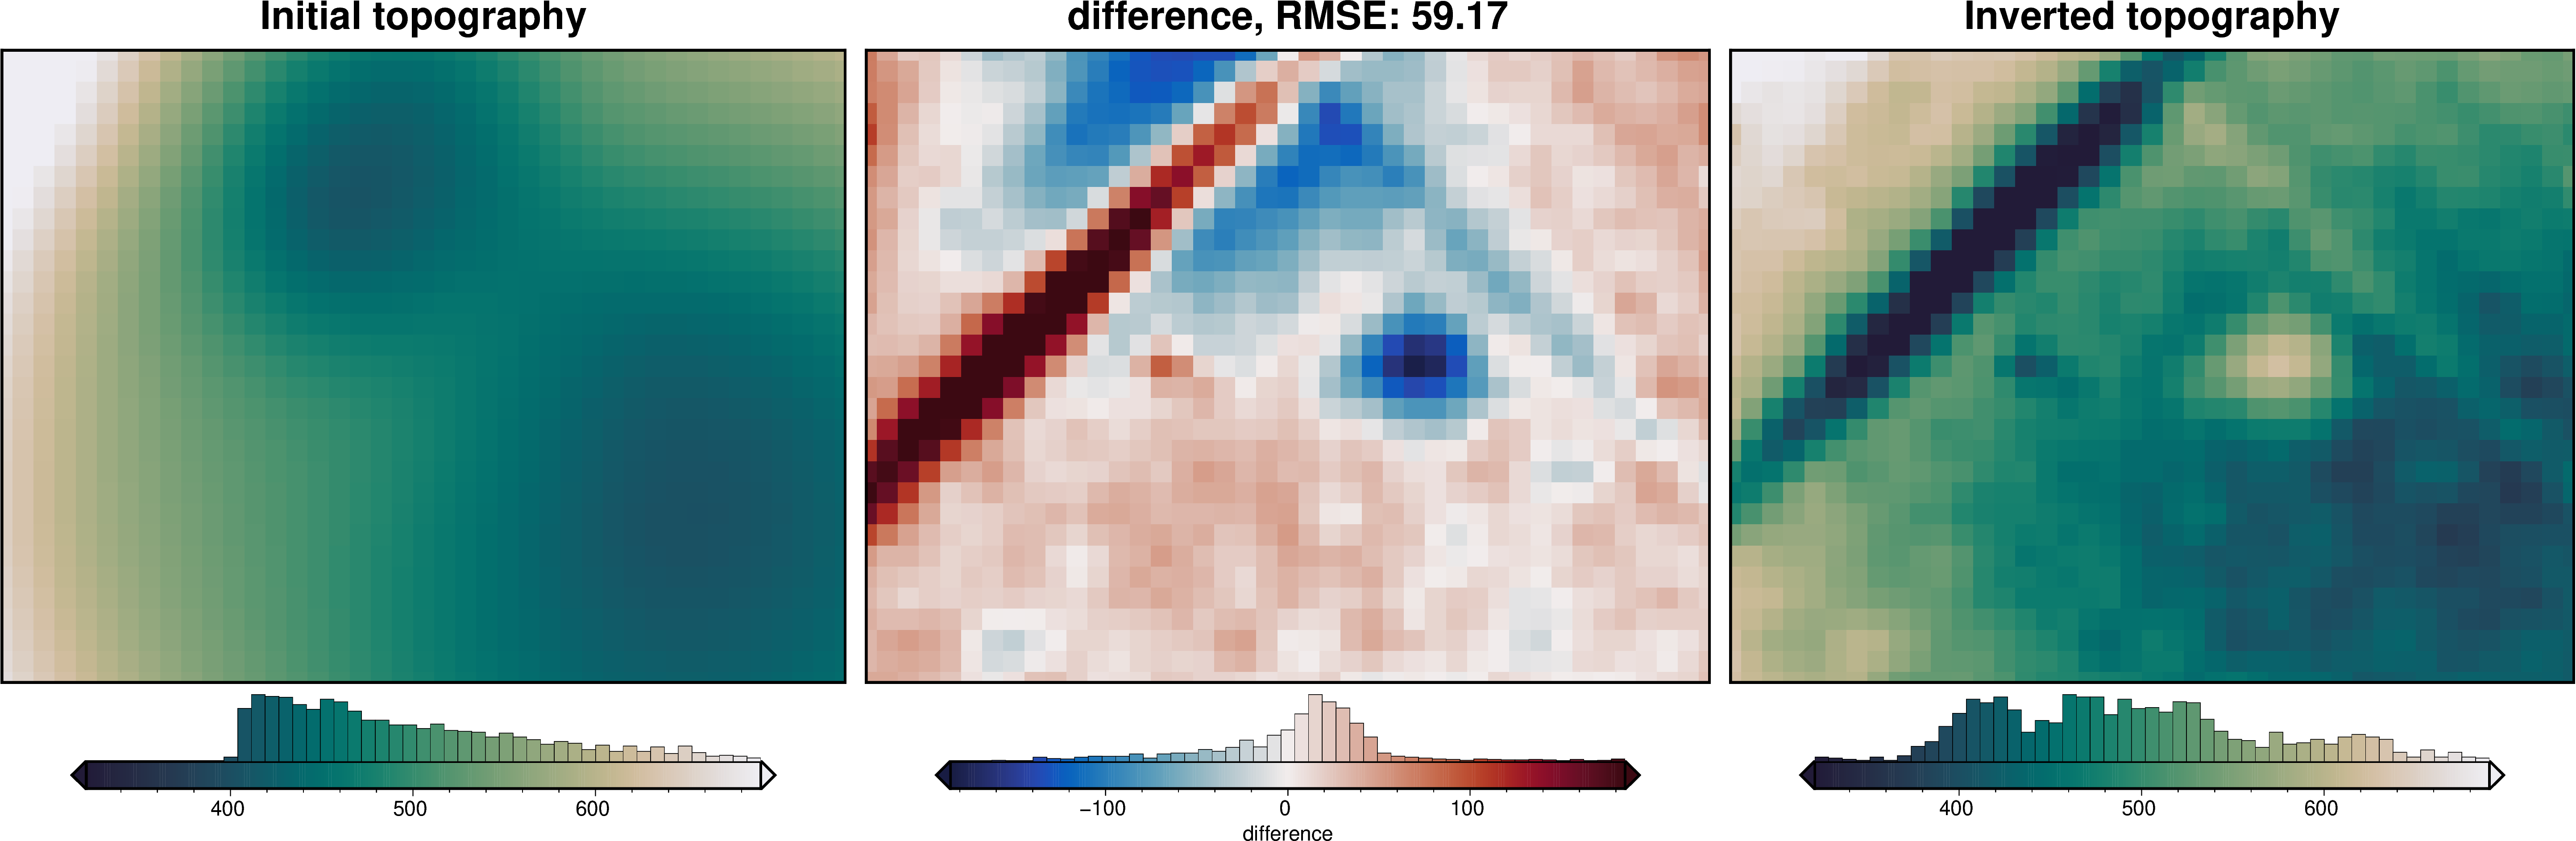

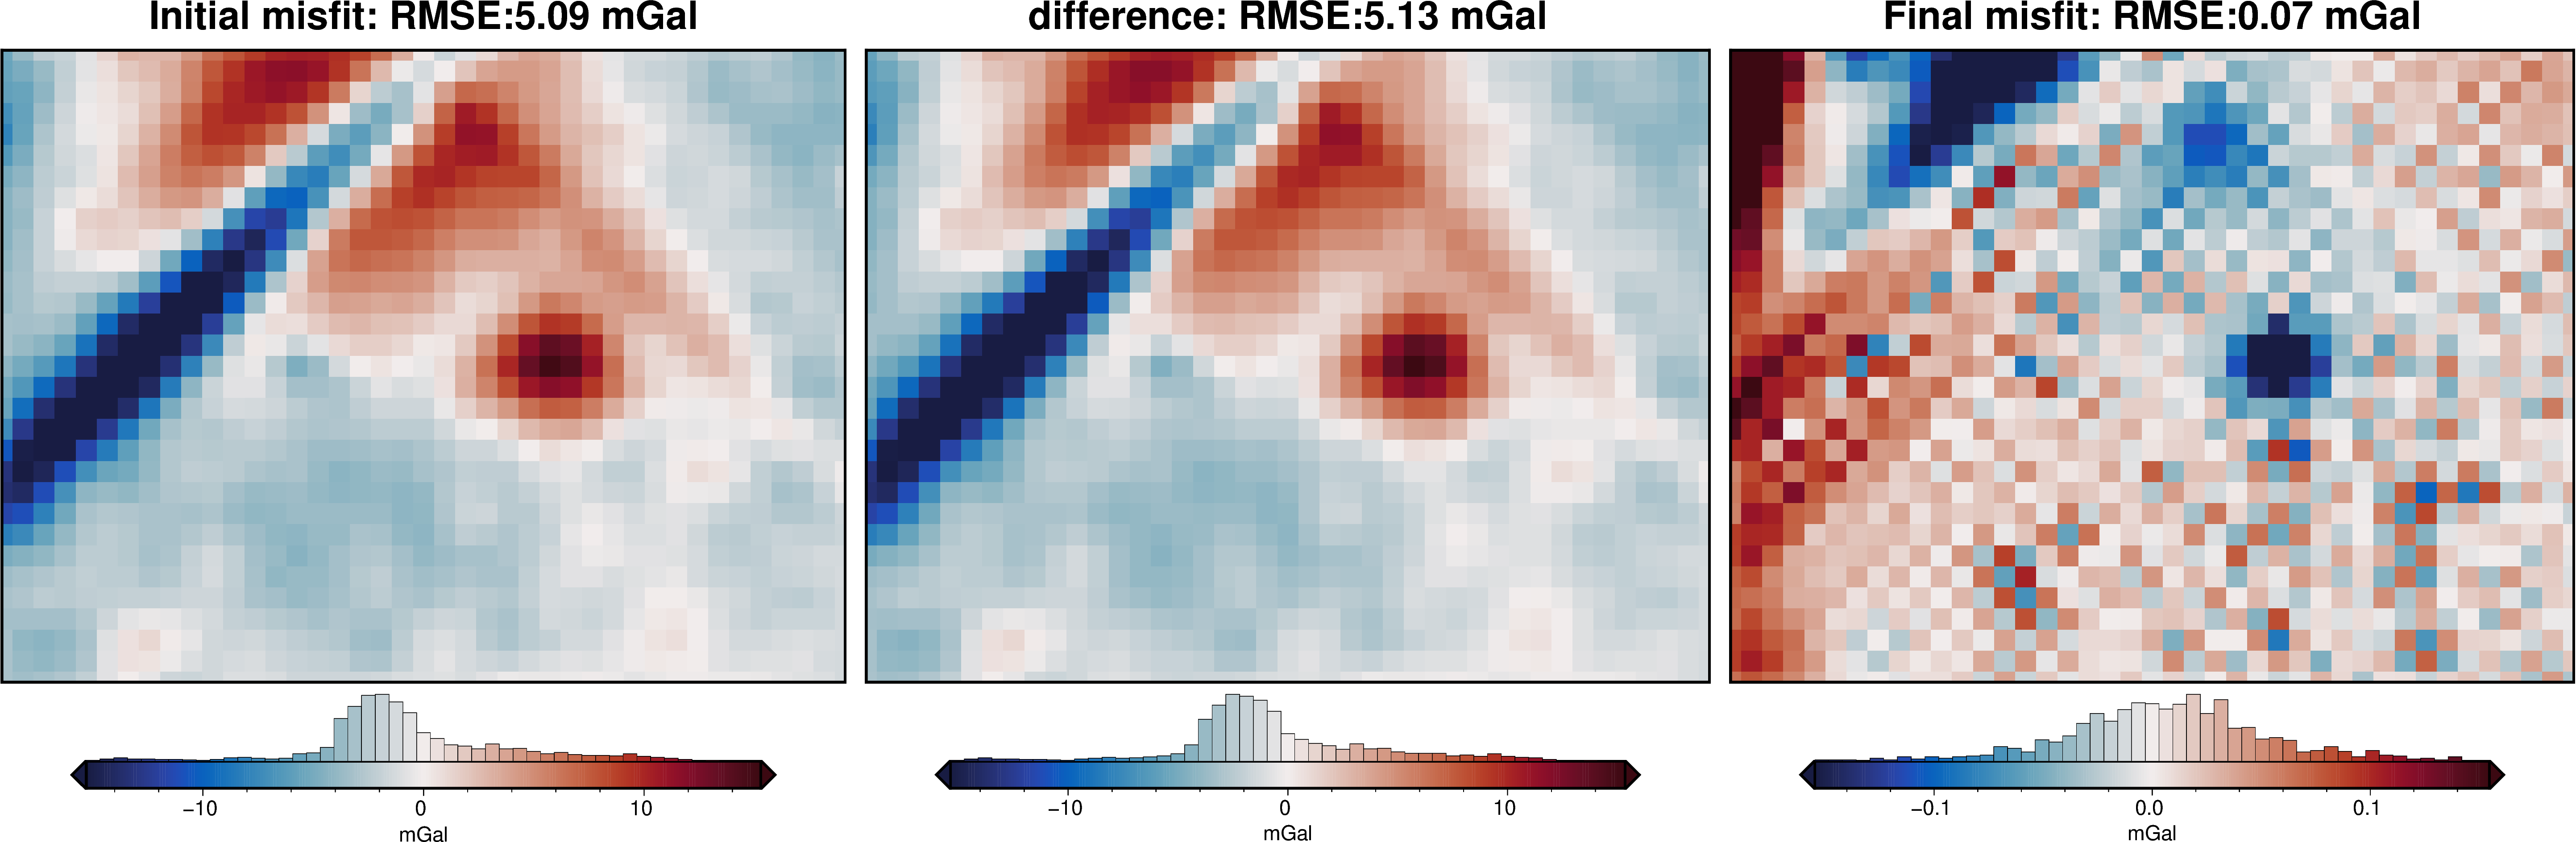

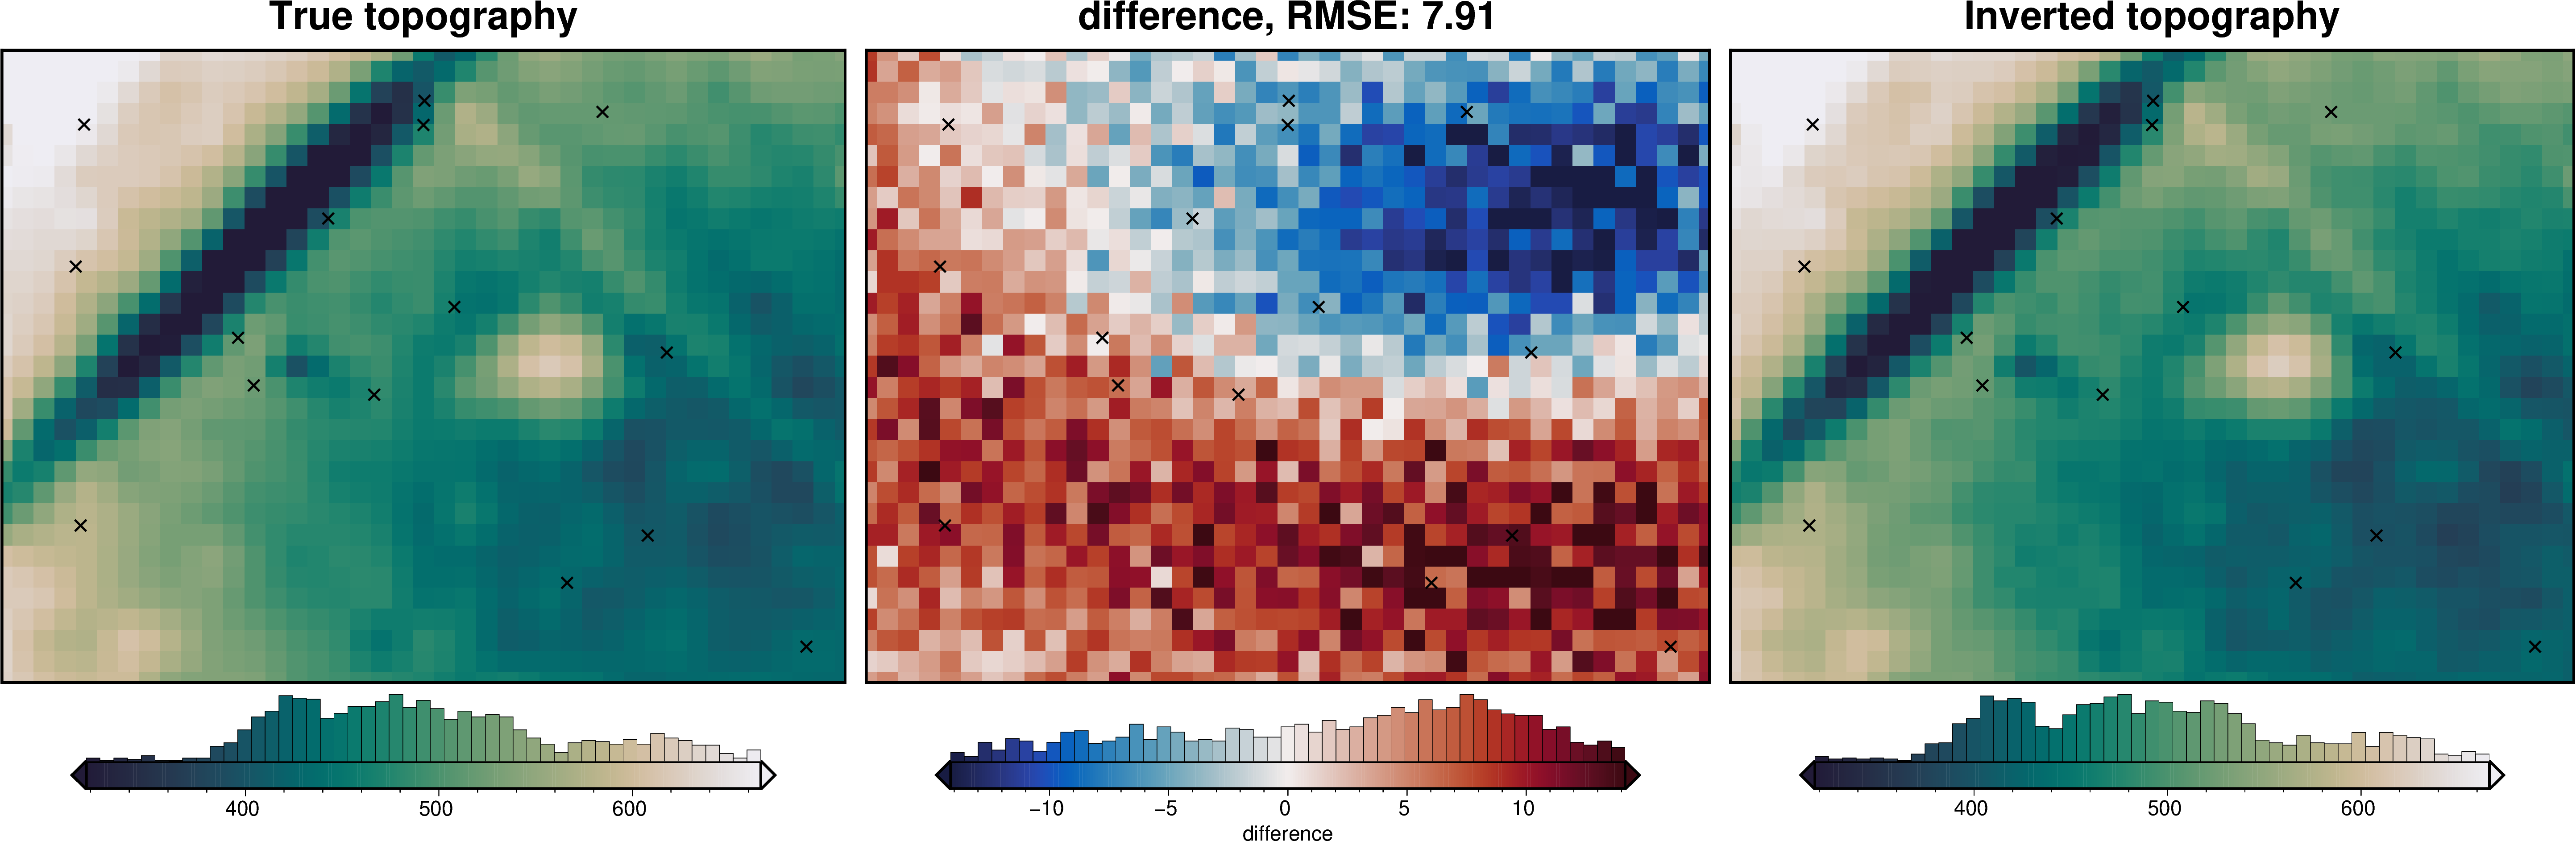

In [12]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=False,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

# Absolute value of inversion error

plot [WARNING]: .4c, not a valid number and may not be decoded properly.


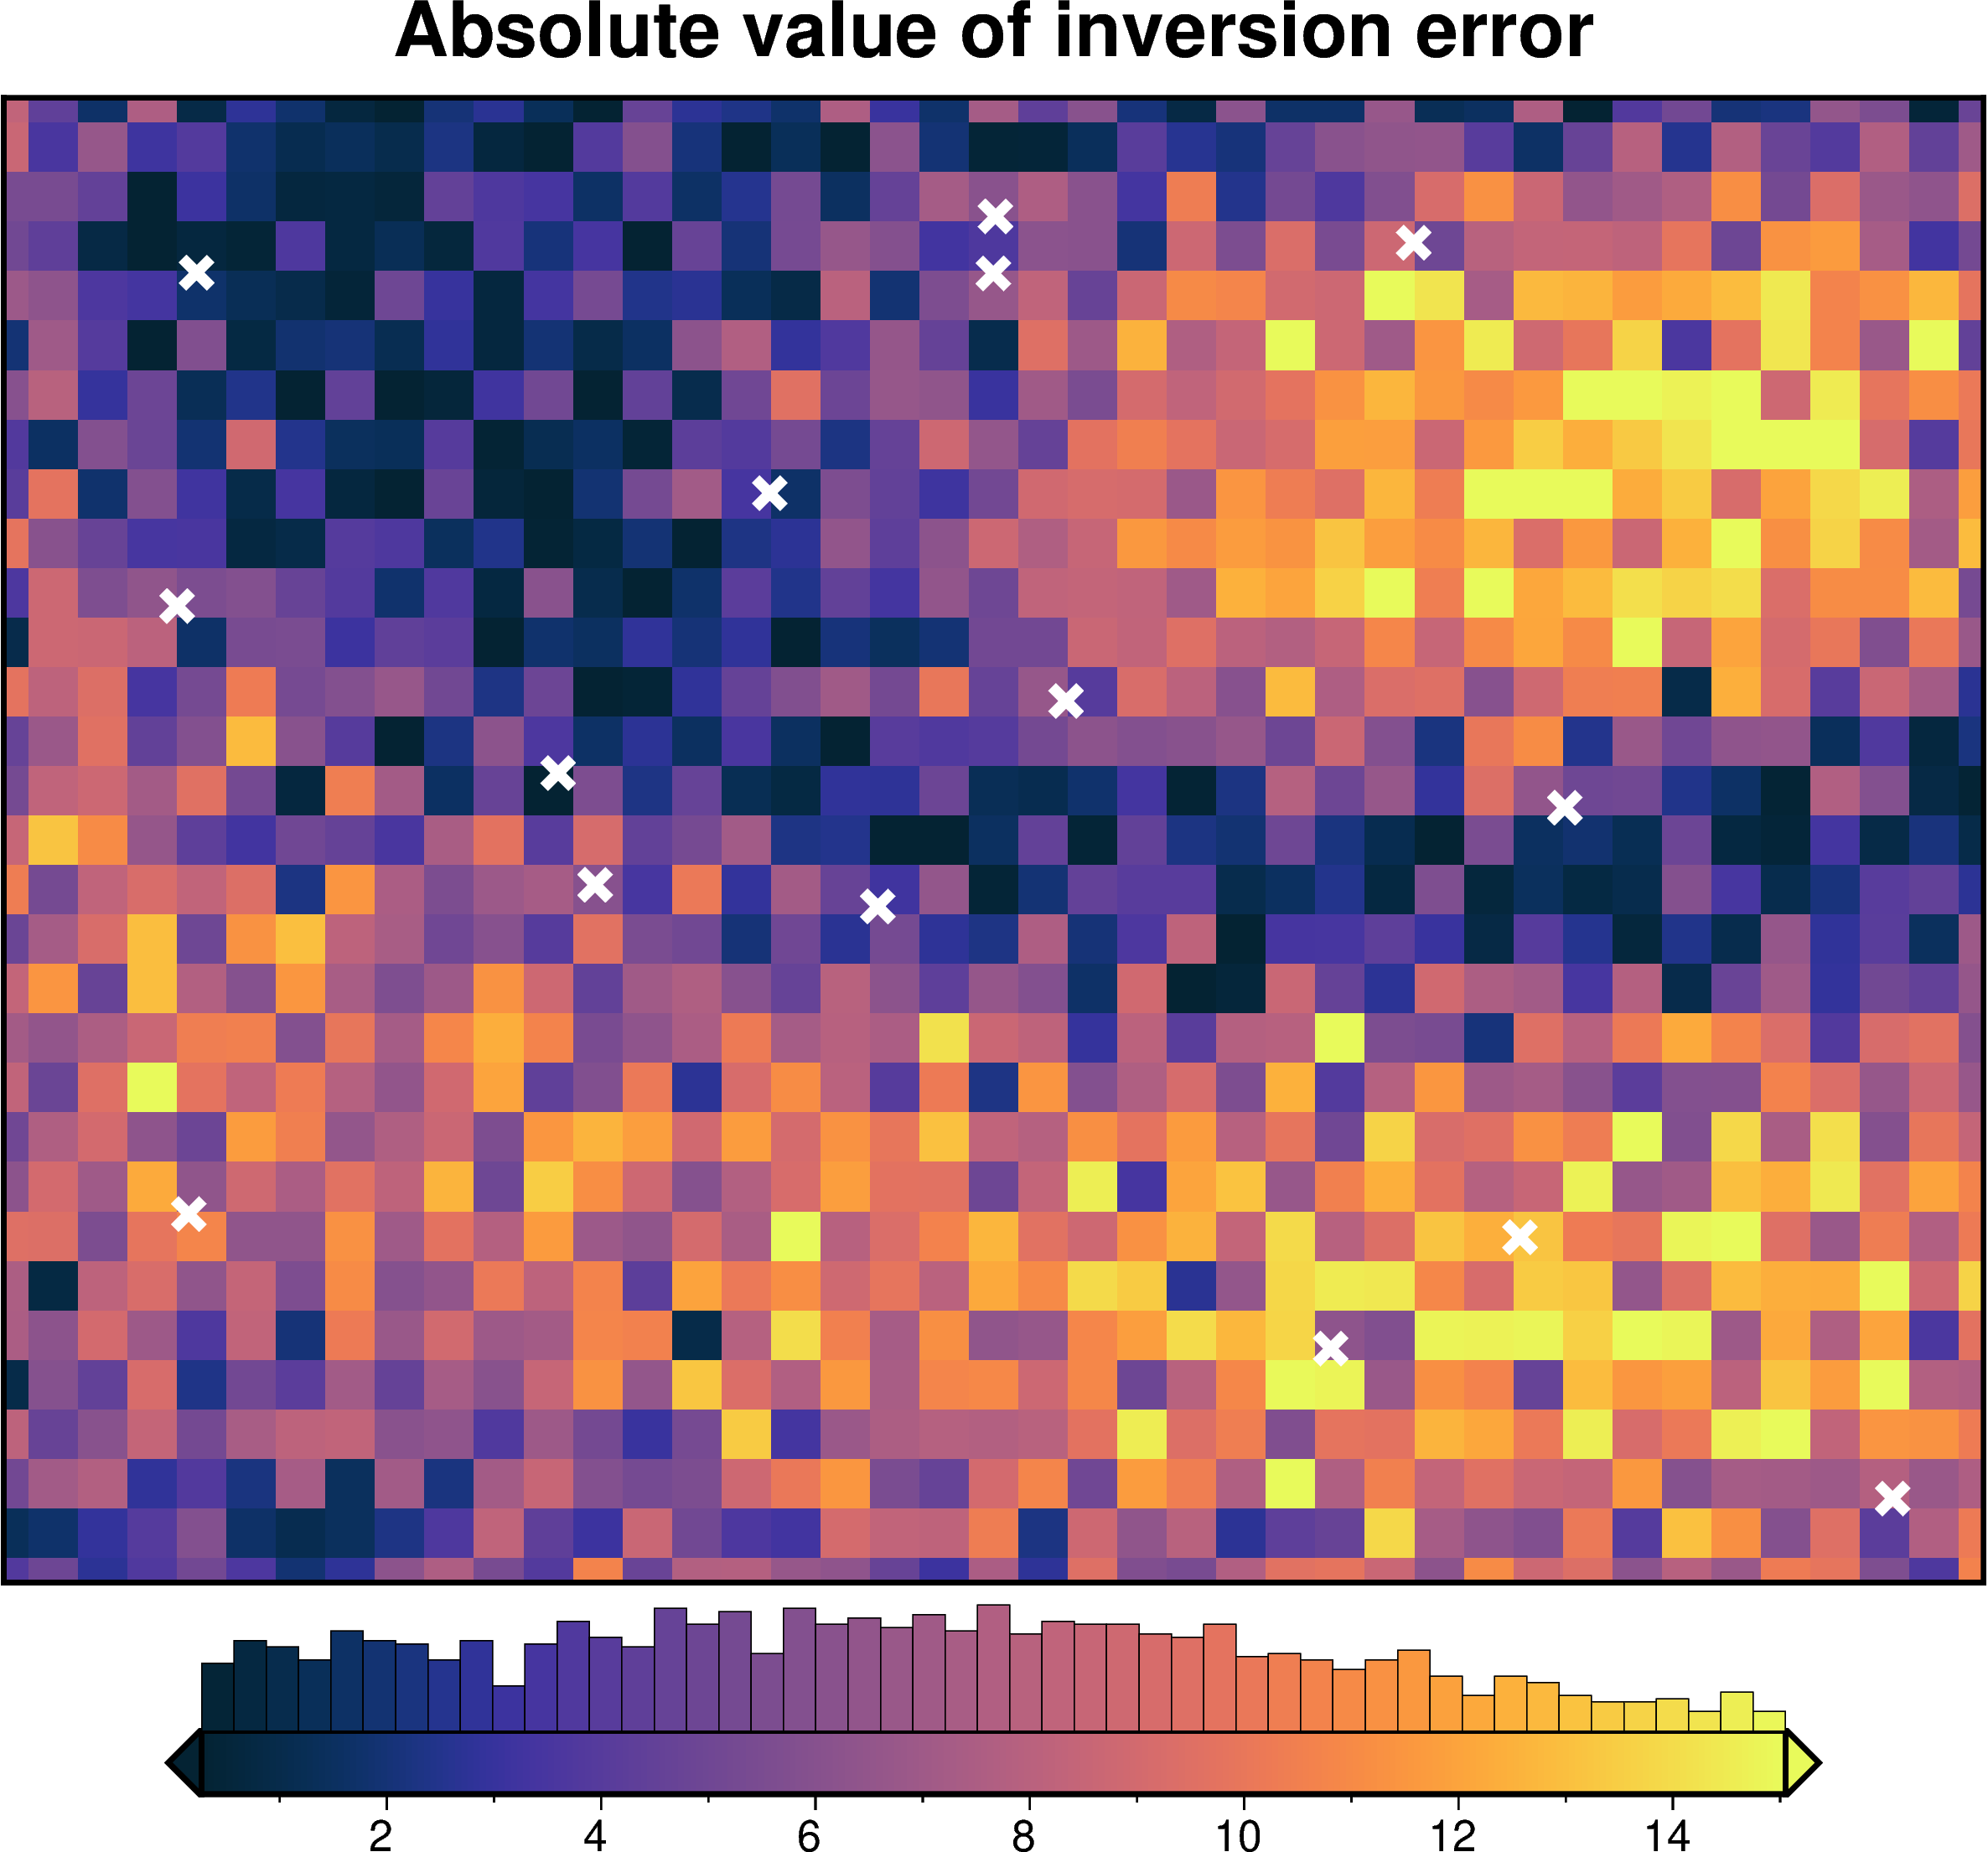

In [13]:
inversion_error = np.abs(true_topography - final_topography)
fig = maps.plot_grd(
    inversion_error,
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points,
    points_style="x.4c,",
    points_pen="3p",
    points_fill="white",
)
fig.show()

# Redo starting gravity and regional separation
use the optimal determined density contrast and zref values

In [14]:
# set the reference level from the prisms to 0
density_grid = xr.where(
    starting_topography >= zref,
    density_contrast,
    -density_contrast,
)
# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=False,
)

# regional separation
temp_reg_kwargs = copy.deepcopy(regional_grav_kwargs)

# temporarily set some kwargs
# temp_reg_kwargs["cv_kwargs"]["plot"]=True
temp_reg_kwargs["cv_kwargs"]["progressbar"] = True

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **temp_reg_kwargs,
)

grav_df["staring_res"] = grav_df.res
grav_df["starting_reg"] = grav_df.reg

grav_df.describe()

INFO:invert4geom:using 12 startup trials


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 44
INFO:invert4geom:	parameter: {'damping': 0.05441253486261697}
INFO:invert4geom:	scores: [-1.290629609409776]


,northing,easting,upward,upper_surface_grav,lower_surface_grav,observed_grav,gravity_anomaly,uncert,starting_gravity,true_res,misfit,reg,res,staring_res,starting_reg
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.128924,0.004007,-0.124917,-0.124917,0.1,0.873936,-1.258972,-0.998852,-0.416104,-0.582749,-0.582749,-0.416104
std,8947.792584,11836.81698,0.0,7.128555,0.714063,7.271000,7.269461,0.0,7.434955,4.602393,4.997721,1.299561,4.542107,4.542107,1.299561
min,0.000000,0.00000,1001.0,-17.179165,-1.033526,-16.887669,-17.040892,0.1,-8.988737,-19.592049,-20.191637,-2.608591,-18.534755,-18.534755,-2.608591
25%,7000.000000,10000.00000,1001.0,-5.448853,-0.601914,-5.750137,-5.739415,0.1,-5.020069,-3.001264,-3.034932,-1.471977,-2.307110,-2.307110,-1.471977
50%,15000.000000,20000.00000,1001.0,-1.160222,-0.153040,-0.758131,-0.713654,0.1,-0.990450,-1.444045,-1.515392,-0.493869,-0.629071,-0.629071,-0.493869
75%,23000.000000,30000.00000,1001.0,3.675021,0.541706,3.825804,3.815224,0.1,5.526057,0.461464,1.048934,0.656853,1.277380,1.277380,0.656853
max,30000.000000,40000.00000,1001.0,19.599674,1.599823,19.781652,19.936108,0.1,24.765890,13.969991,14.987722,1.920849,14.706053,14.706053,1.920849


In [15]:
# plotting functions for uncertainty results
def uncert_plots(
    results,
    inversion_region,
    spacing,
    true_topography,
    constraint_points=None,
    weight_by=None,
):
    if (weight_by == "constraints") & (constraint_points is None):
        msg = "must provide constraint_points if weighting by constraints"
        raise ValueError(msg)

    stats_ds = uncertainty.merged_stats(
        results=results,
        plot=True,
        constraints_df=constraint_points,
        weight_by=weight_by,
        region=inversion_region,
    )

    try:
        mean = stats_ds.weighted_mean
        stdev = stats_ds.weighted_stdev
    except AttributeError:
        mean = stats_ds.z_mean
        stdev = stats_ds.z_stdev

    _ = polar_utils.grd_compare(
        true_topography,
        mean,
        region=vd.pad_region(inversion_region, -spacing),
        plot=True,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
        points=constraint_points,
        points_style="x.3c",
    )
    _ = polar_utils.grd_compare(
        np.abs(true_topography - mean),
        stdev,
        region=vd.pad_region(inversion_region, -spacing),
        plot=True,
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        cmap="thermal",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
        points_fill="white",
    )
    return stats_ds

# Uncertainty analysis

In [51]:
# get mean spacing between nearest constraints
mean_spacing = np.mean(
    vd.median_distance(
        (constraint_points.easting, constraint_points.northing),
        k_nearest=1,
    )
)
mean_spacing

np.float64(5599.156508868462)

In [52]:
# use optimal eq source parameters for regional separation in uncertainty analysis
# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get('cv_kwargs').get('fname')}.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
reg_eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]

reg_eq_depth = 4.5 * mean_spacing

new_regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    damping=reg_eq_damping,
    depth=reg_eq_depth,
    block_size=None,
)
reg_eq_damping, reg_eq_depth

(0.000763324315253277, np.float64(25196.204289908077))

In [53]:
# add best damping parameter to kwargs
kwargs["solver_damping"] = solver_damping

# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=density_contrast,
    zref=zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_topography,
    regional_grav_kwargs=new_regional_grav_kwargs,
    **kwargs,
)

## Solver damping component
To estimate the uncertainty of the choice of solver damping value, we will load the damping cross validation and calculate the standard deviation of the trials (excluding outliers)

In [19]:
# load study
with pathlib.Path("../tmp/combining_it_all_damping_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df.sort_values("value", inplace=True)  # noqa: PD002

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
# stdev = .1
print(f"using stdev: {stdev}")

calculated stdev: 0.6606916258212597
using stdev: 0.6606916258212597


best: 0.02239318117126179 
std: 0.6606916258212597 
+1std: 0.10251972193611696 
-1std: 0.004891298508217031


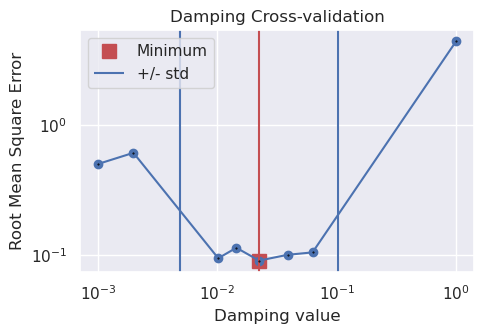

In [20]:
fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.055707809670204014, min: 0.0018338963102798088, max: 0.27343670422263033
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_damping' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_damping'



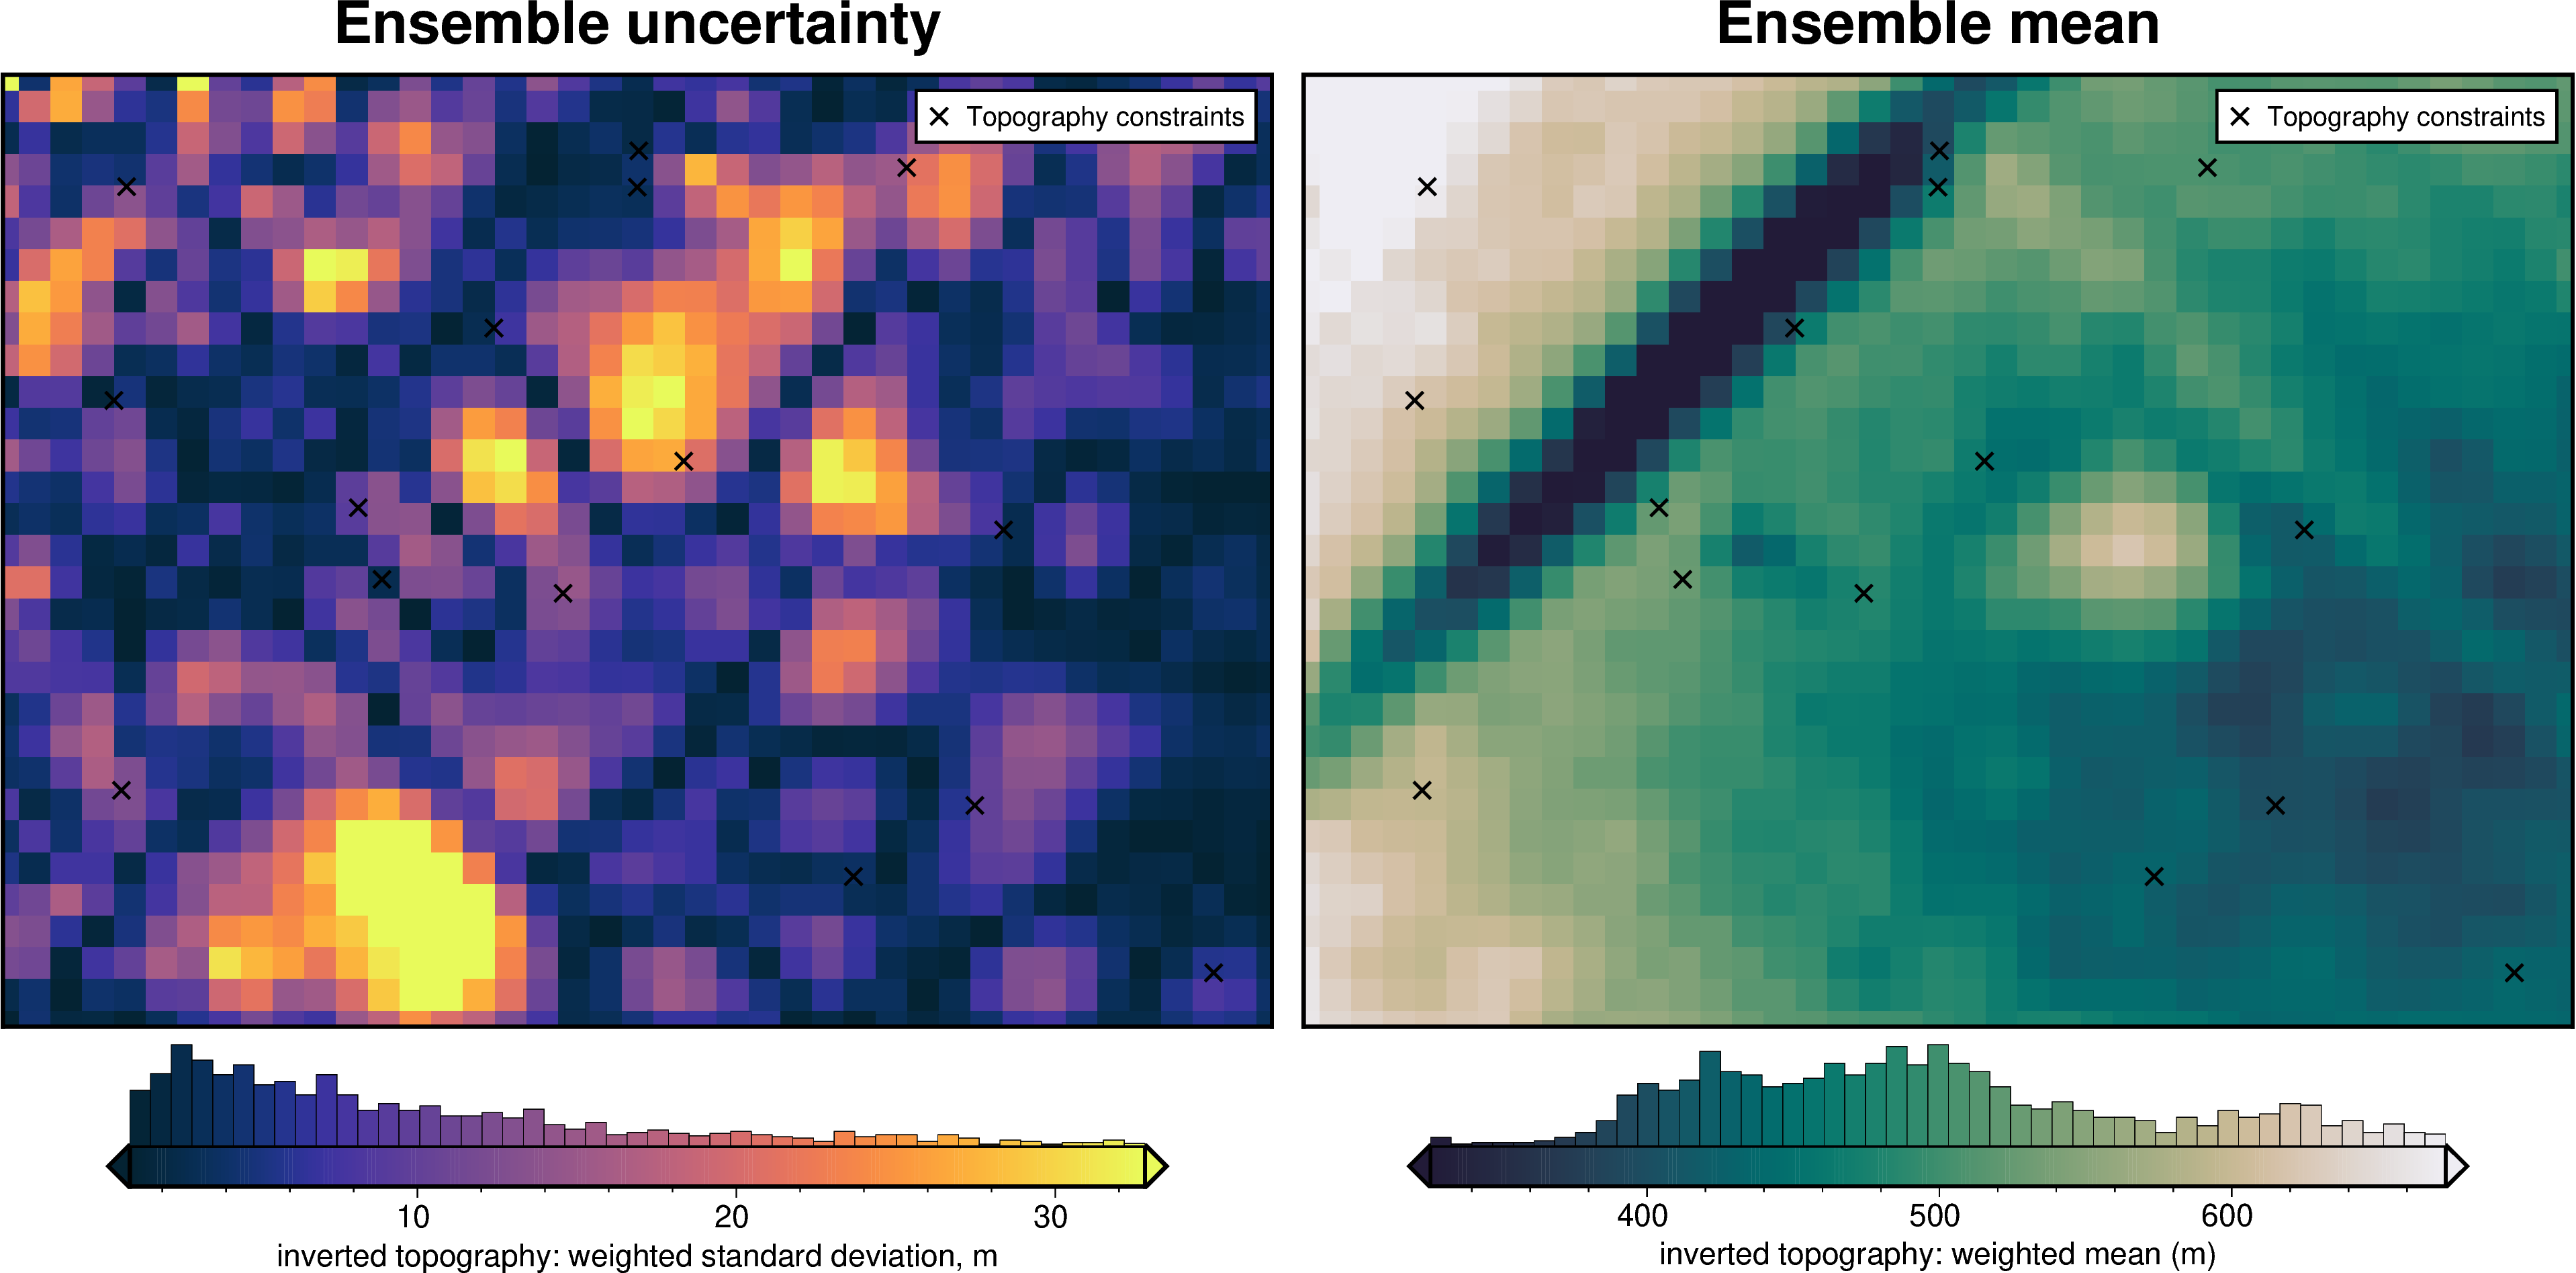

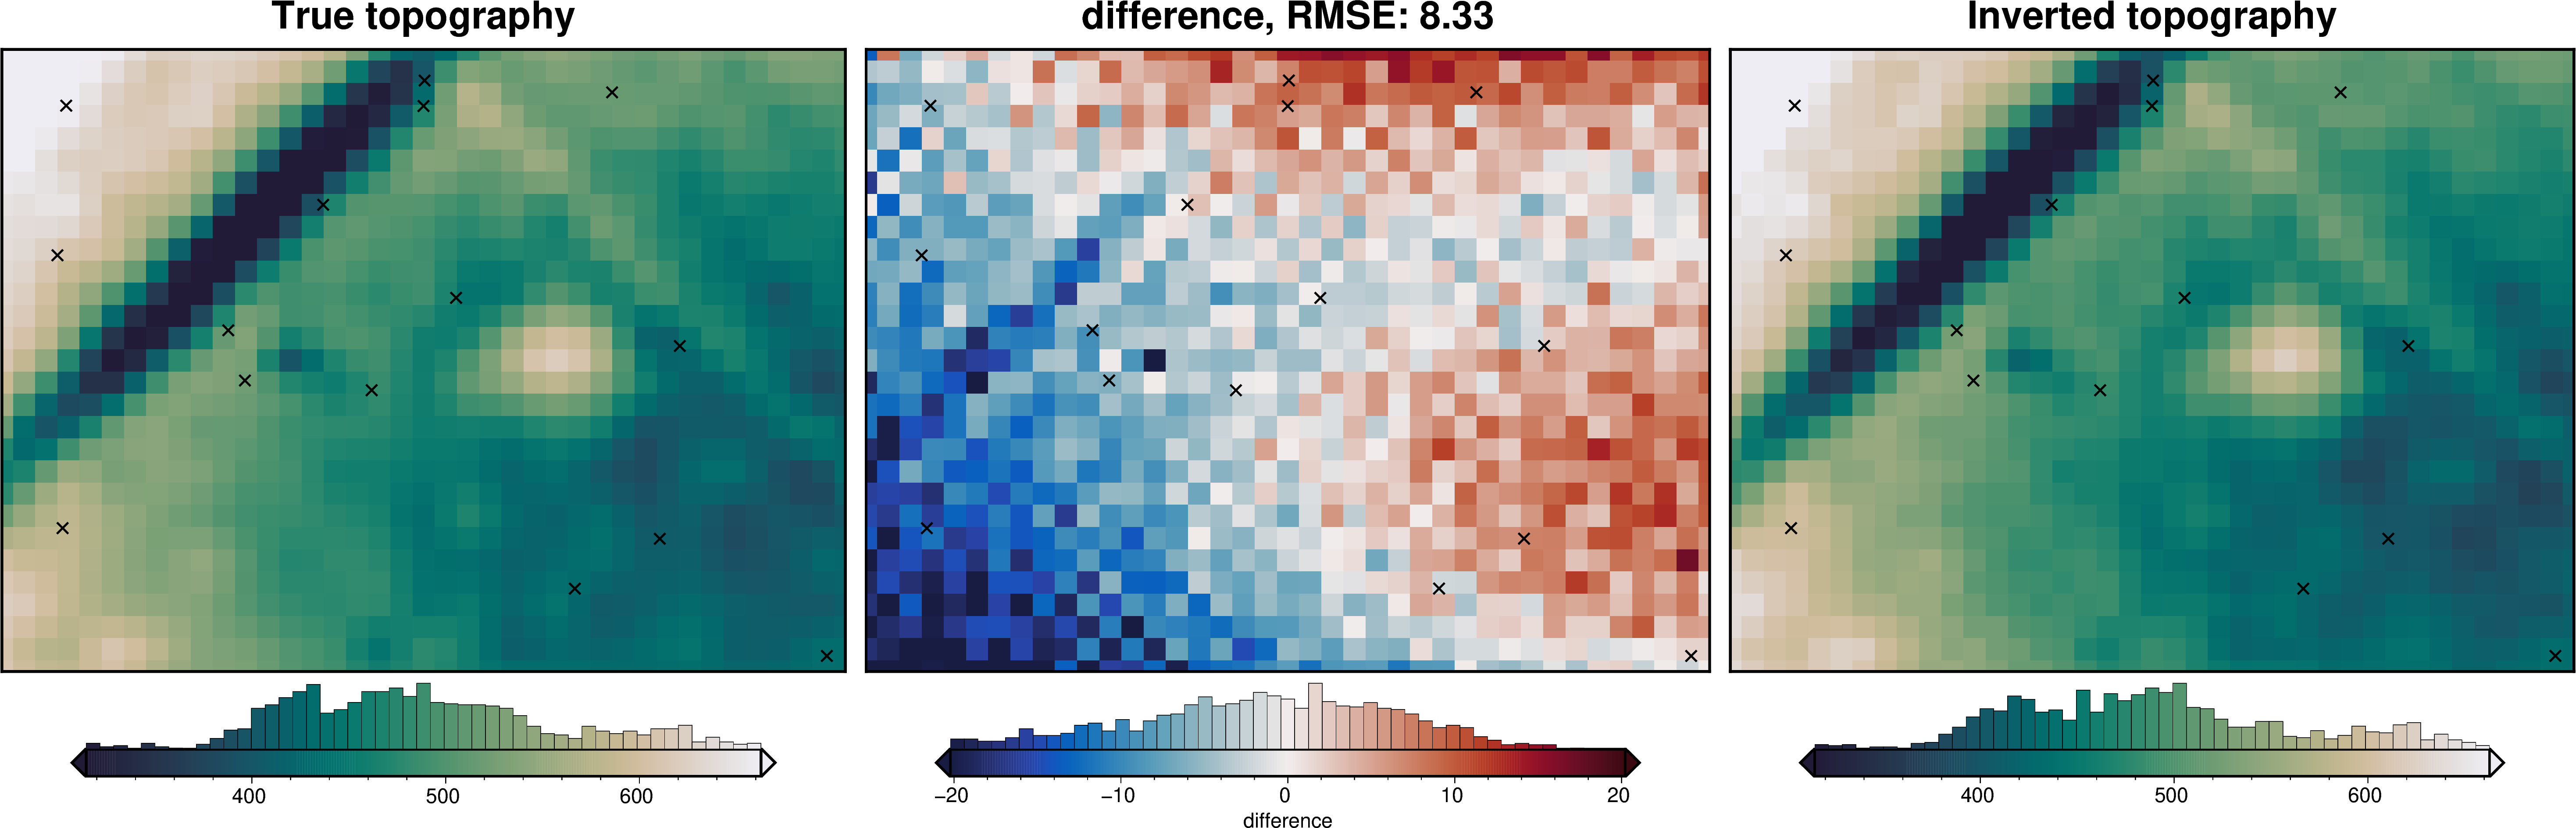

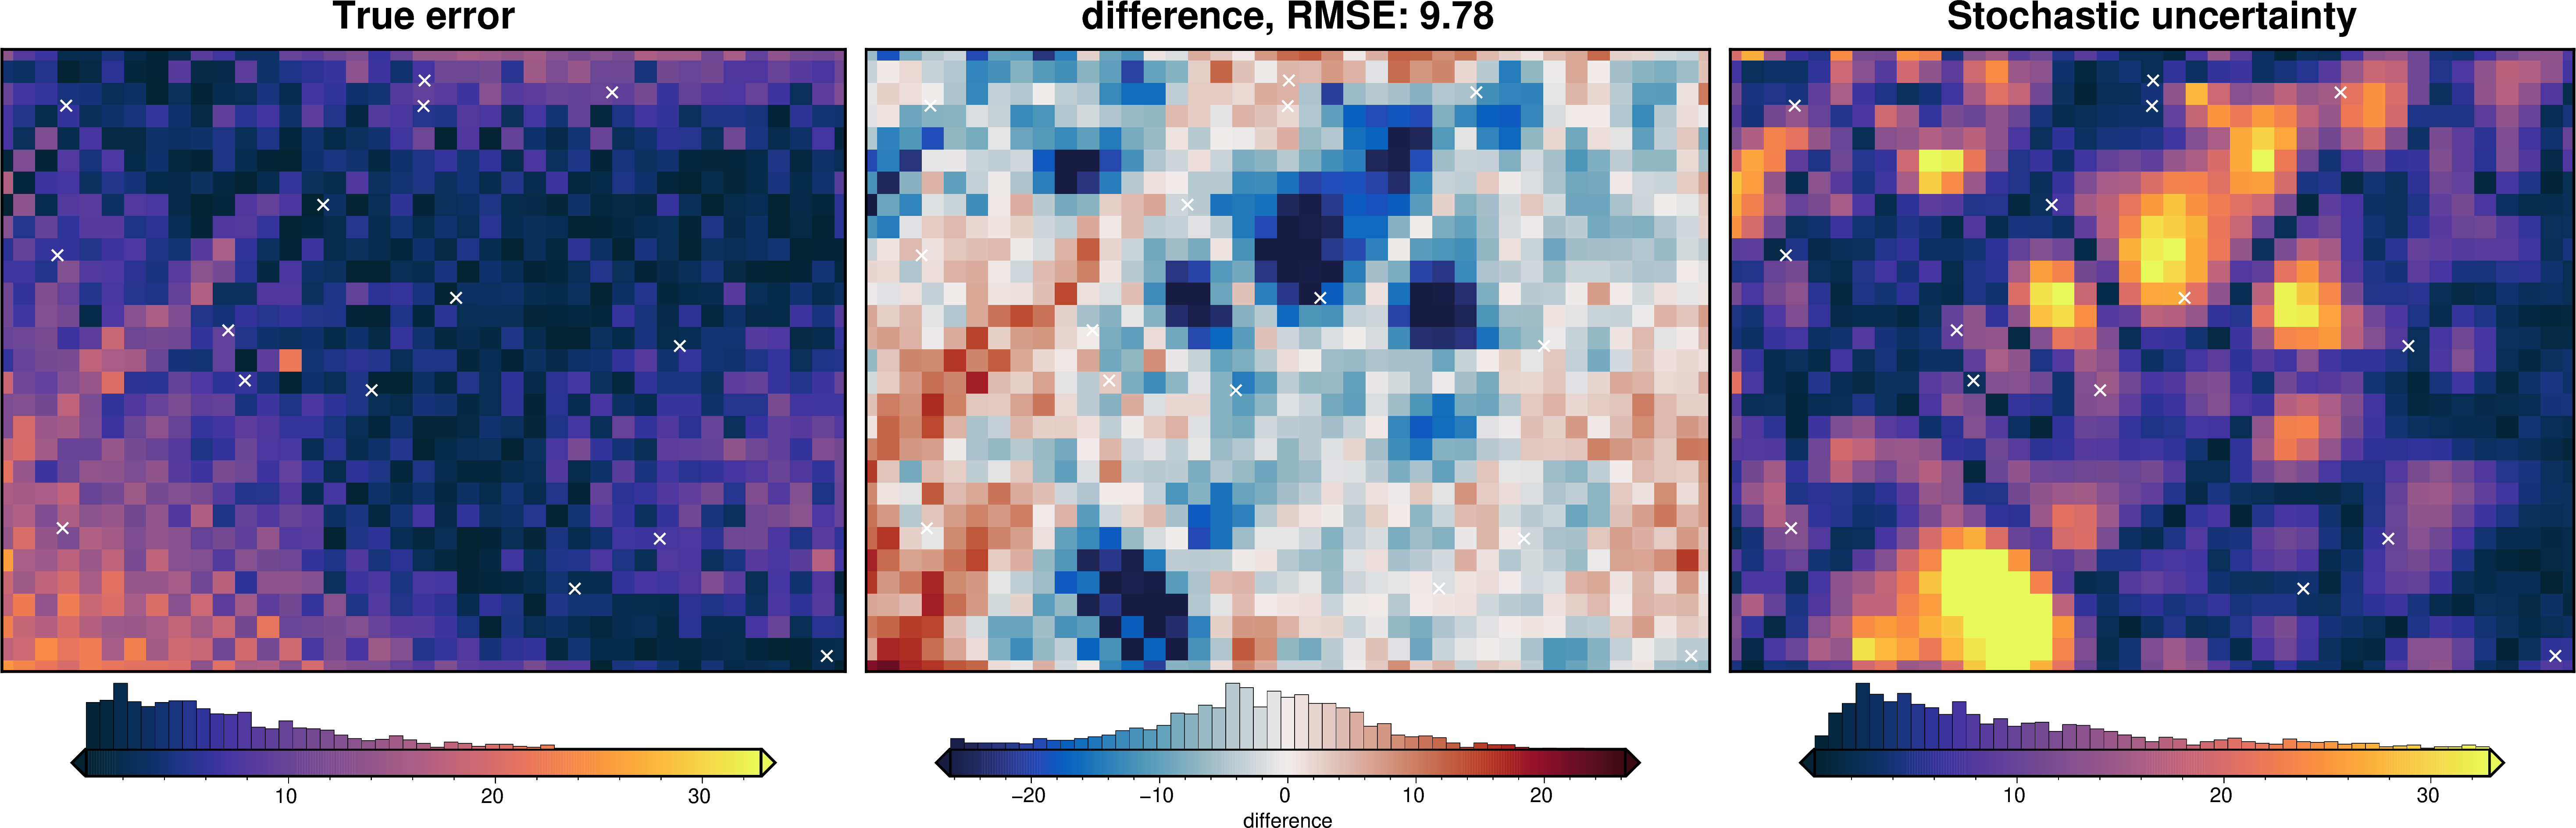

In [21]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(solver_damping),  # mean of base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}
fname = "../tmp/uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_damping_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Z-ref and density components
To estimate the uncertainty of the choice of Z-ref and density value, we will sample the values from random distributions.

best: 490.31137109098535 
std: 50 
+1std: 540.3113710909854 
-1std: 440.31137109098535
best: 2688.0 
std: 100 
+1std: 2788.0 
-1std: 2588.0


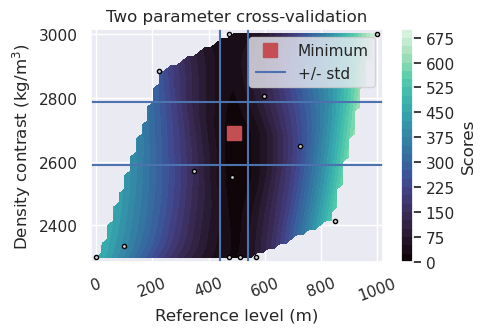

In [43]:
# choose standard deviations for the density contrast and zref
density_stdev = 100
zref_stdev = 50

# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/combining_it_all_density_and_zref_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

plotting.plot_2_parameter_cv_scores_uneven(
    study,
    param_names=(
        "params_zref",
        "params_density_contrast",
    ),
    plot_param_names=(
        "Reference level (m)",
        "Density contrast (kg/m$^3$)",
    ),
)

ax = plt.gca()

# plot zref stdev
upper = zref + zref_stdev
lower = zref - zref_stdev
y_lims = ax.get_ylim()
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])
x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
print("best:", zref, "\nstd:", zref_stdev, "\n+1std:", upper, "\n-1std:", lower)

# plot density contrast stdev
upper = density_contrast + density_stdev
lower = density_contrast - density_stdev
x_lims = ax.get_xlim()
ax.hlines(upper, xmin=x_lims[0], xmax=x_lims[1])
ax.hlines(lower, xmin=x_lims[0], xmax=x_lims[1])
y_lims = ax.get_ylim()
ax.set_ylim(
    min(y_lims[0], lower),
    max(y_lims[1], upper),
)
ax.legend()
print(
    "best:",
    density_contrast,
    "\nstd:",
    density_stdev,
    "\n+1std:",
    upper,
    "\n-1std:",
    lower,
)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2688.0, min: 2523.514637304853, max: 2852.485362695147
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_density' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_density'



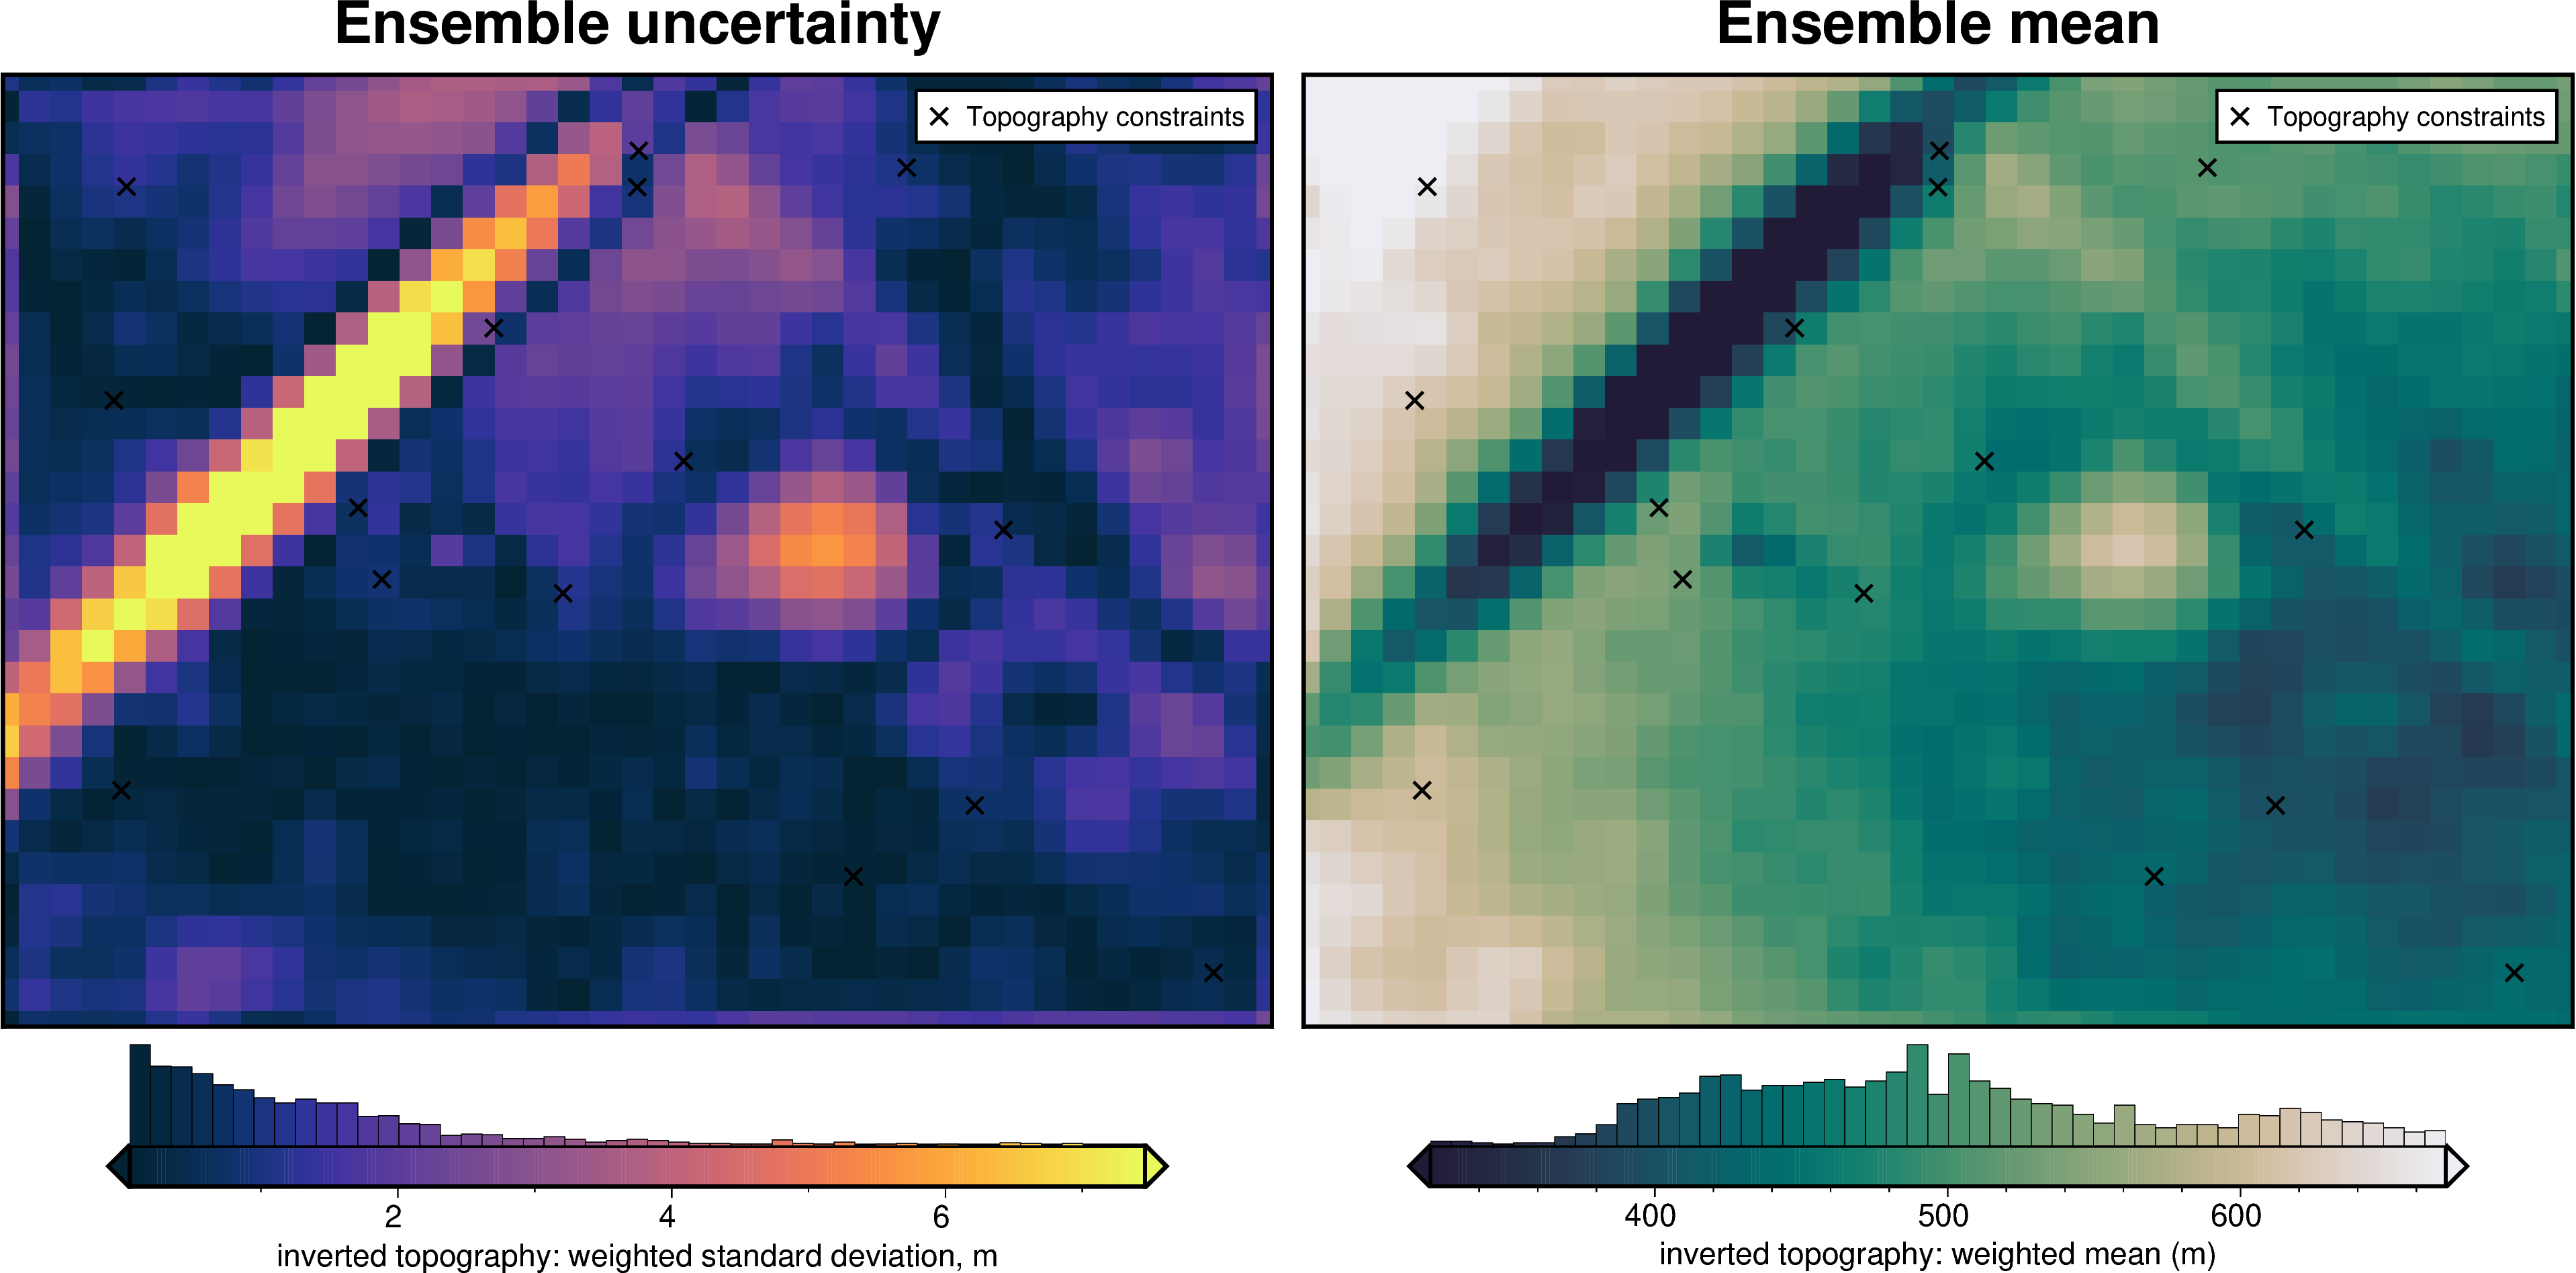

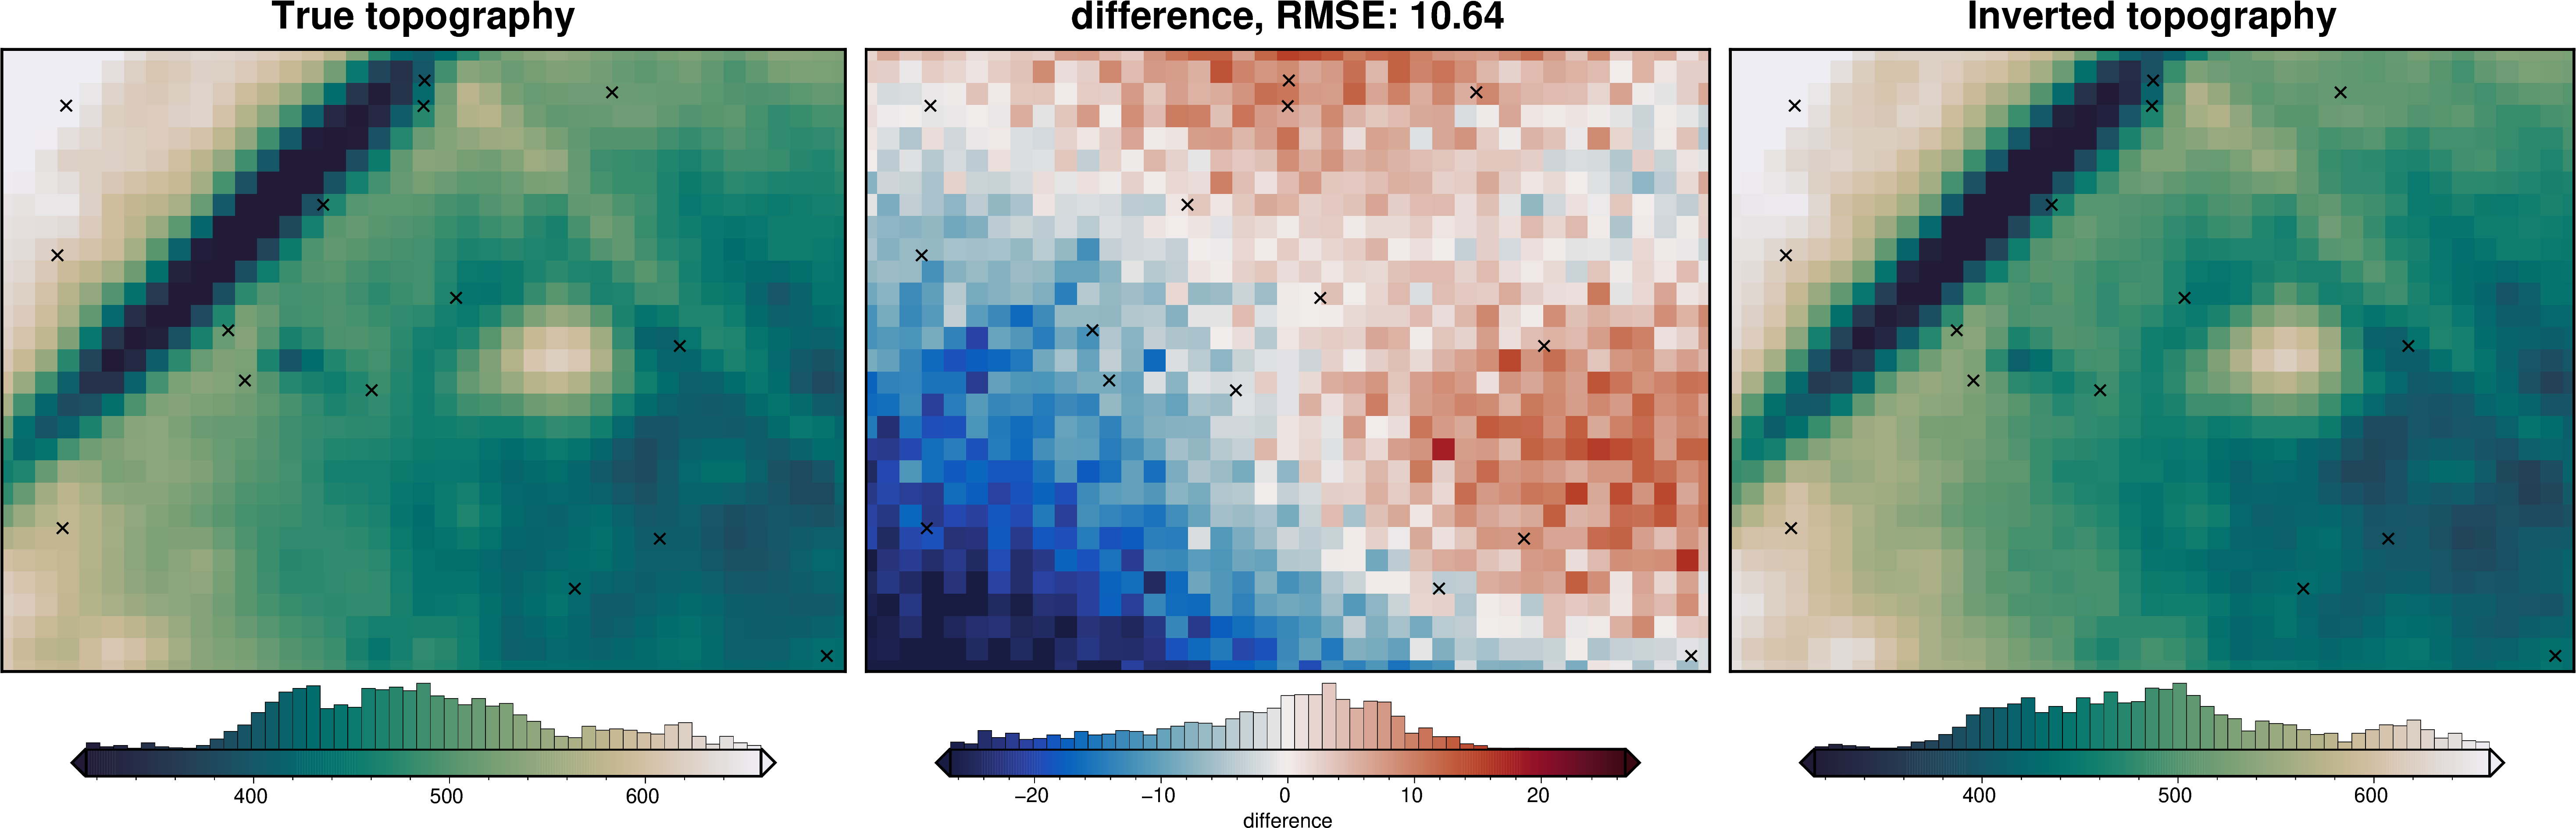

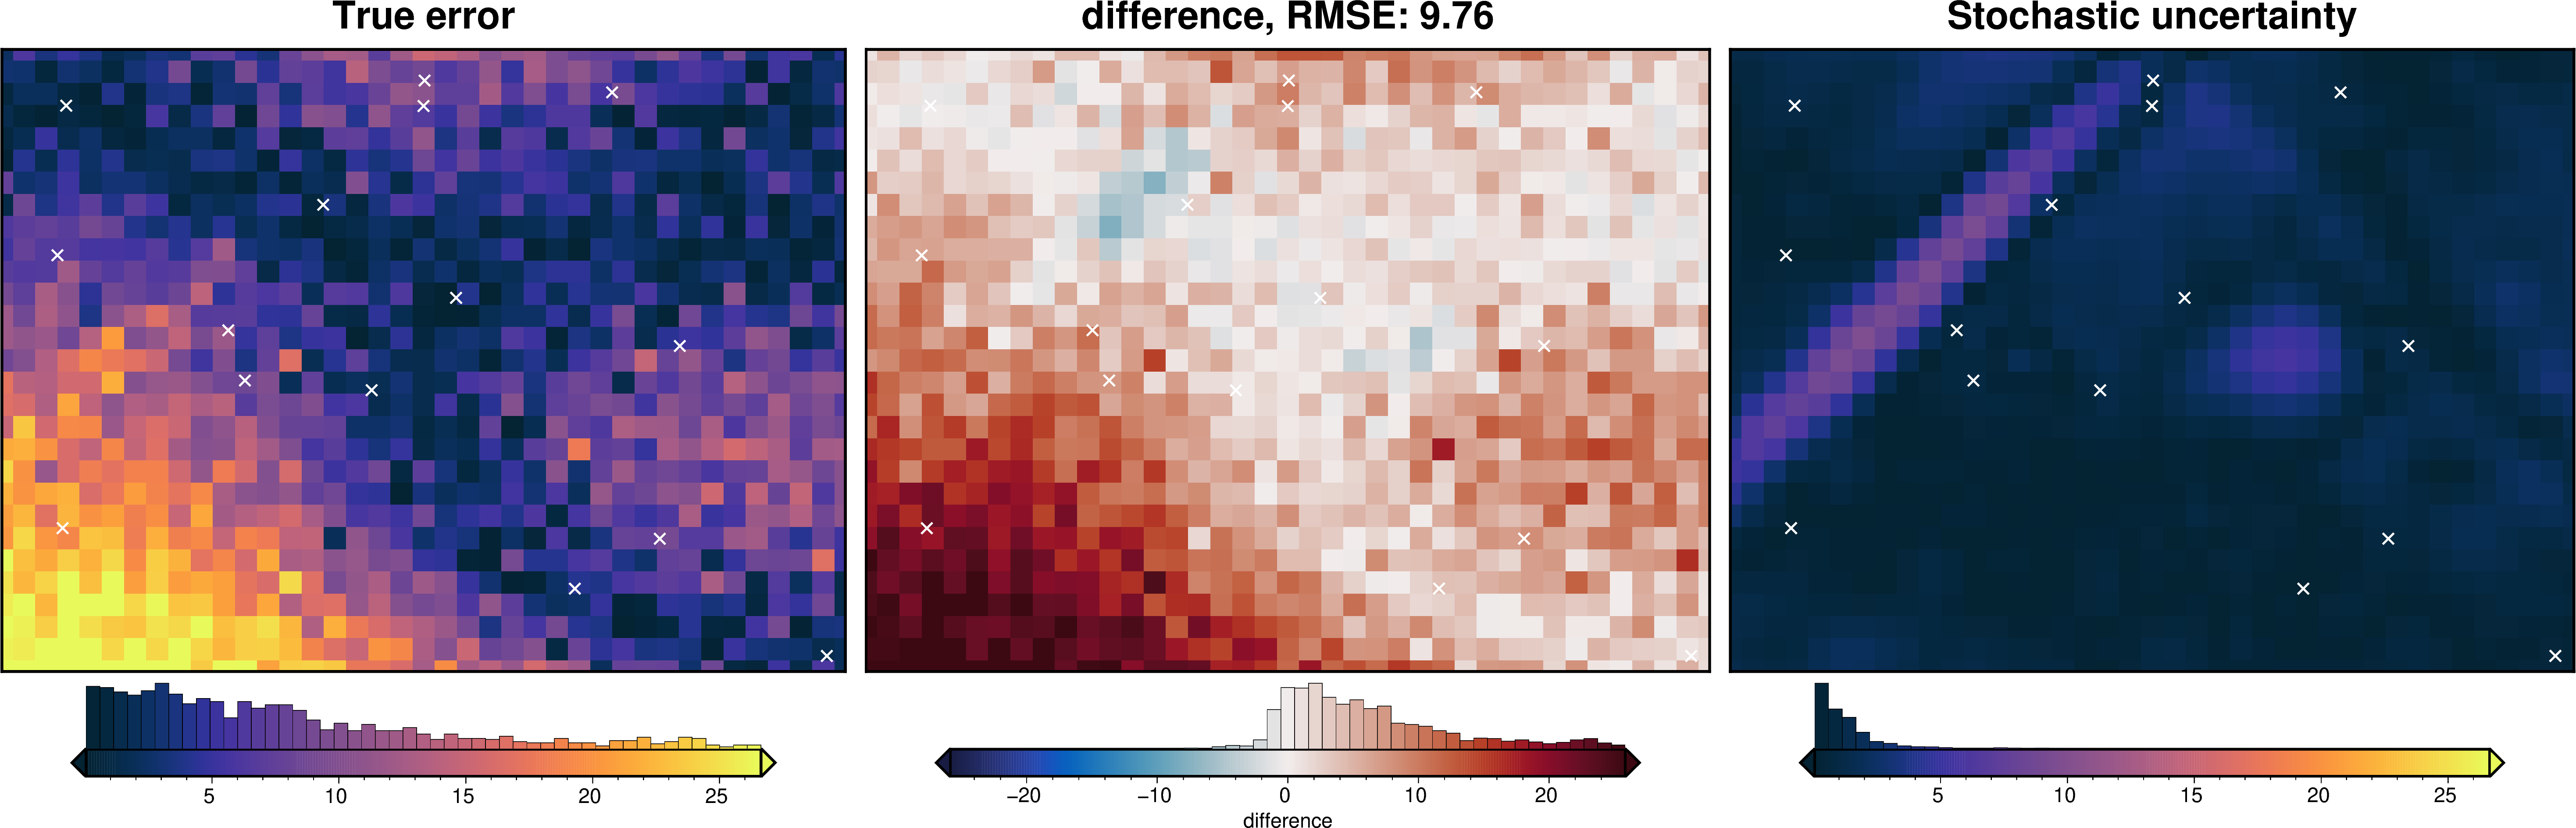

In [45]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": density_contrast,
        "scale": density_stdev,
    },
}
fname = "../tmp/uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_density_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

INFO:invert4geom:Sampled 'zref' parameter values; mean: 490.3113710909853, min: 408.0686897434117, max: 572.554052438559
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_zref' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_zref'



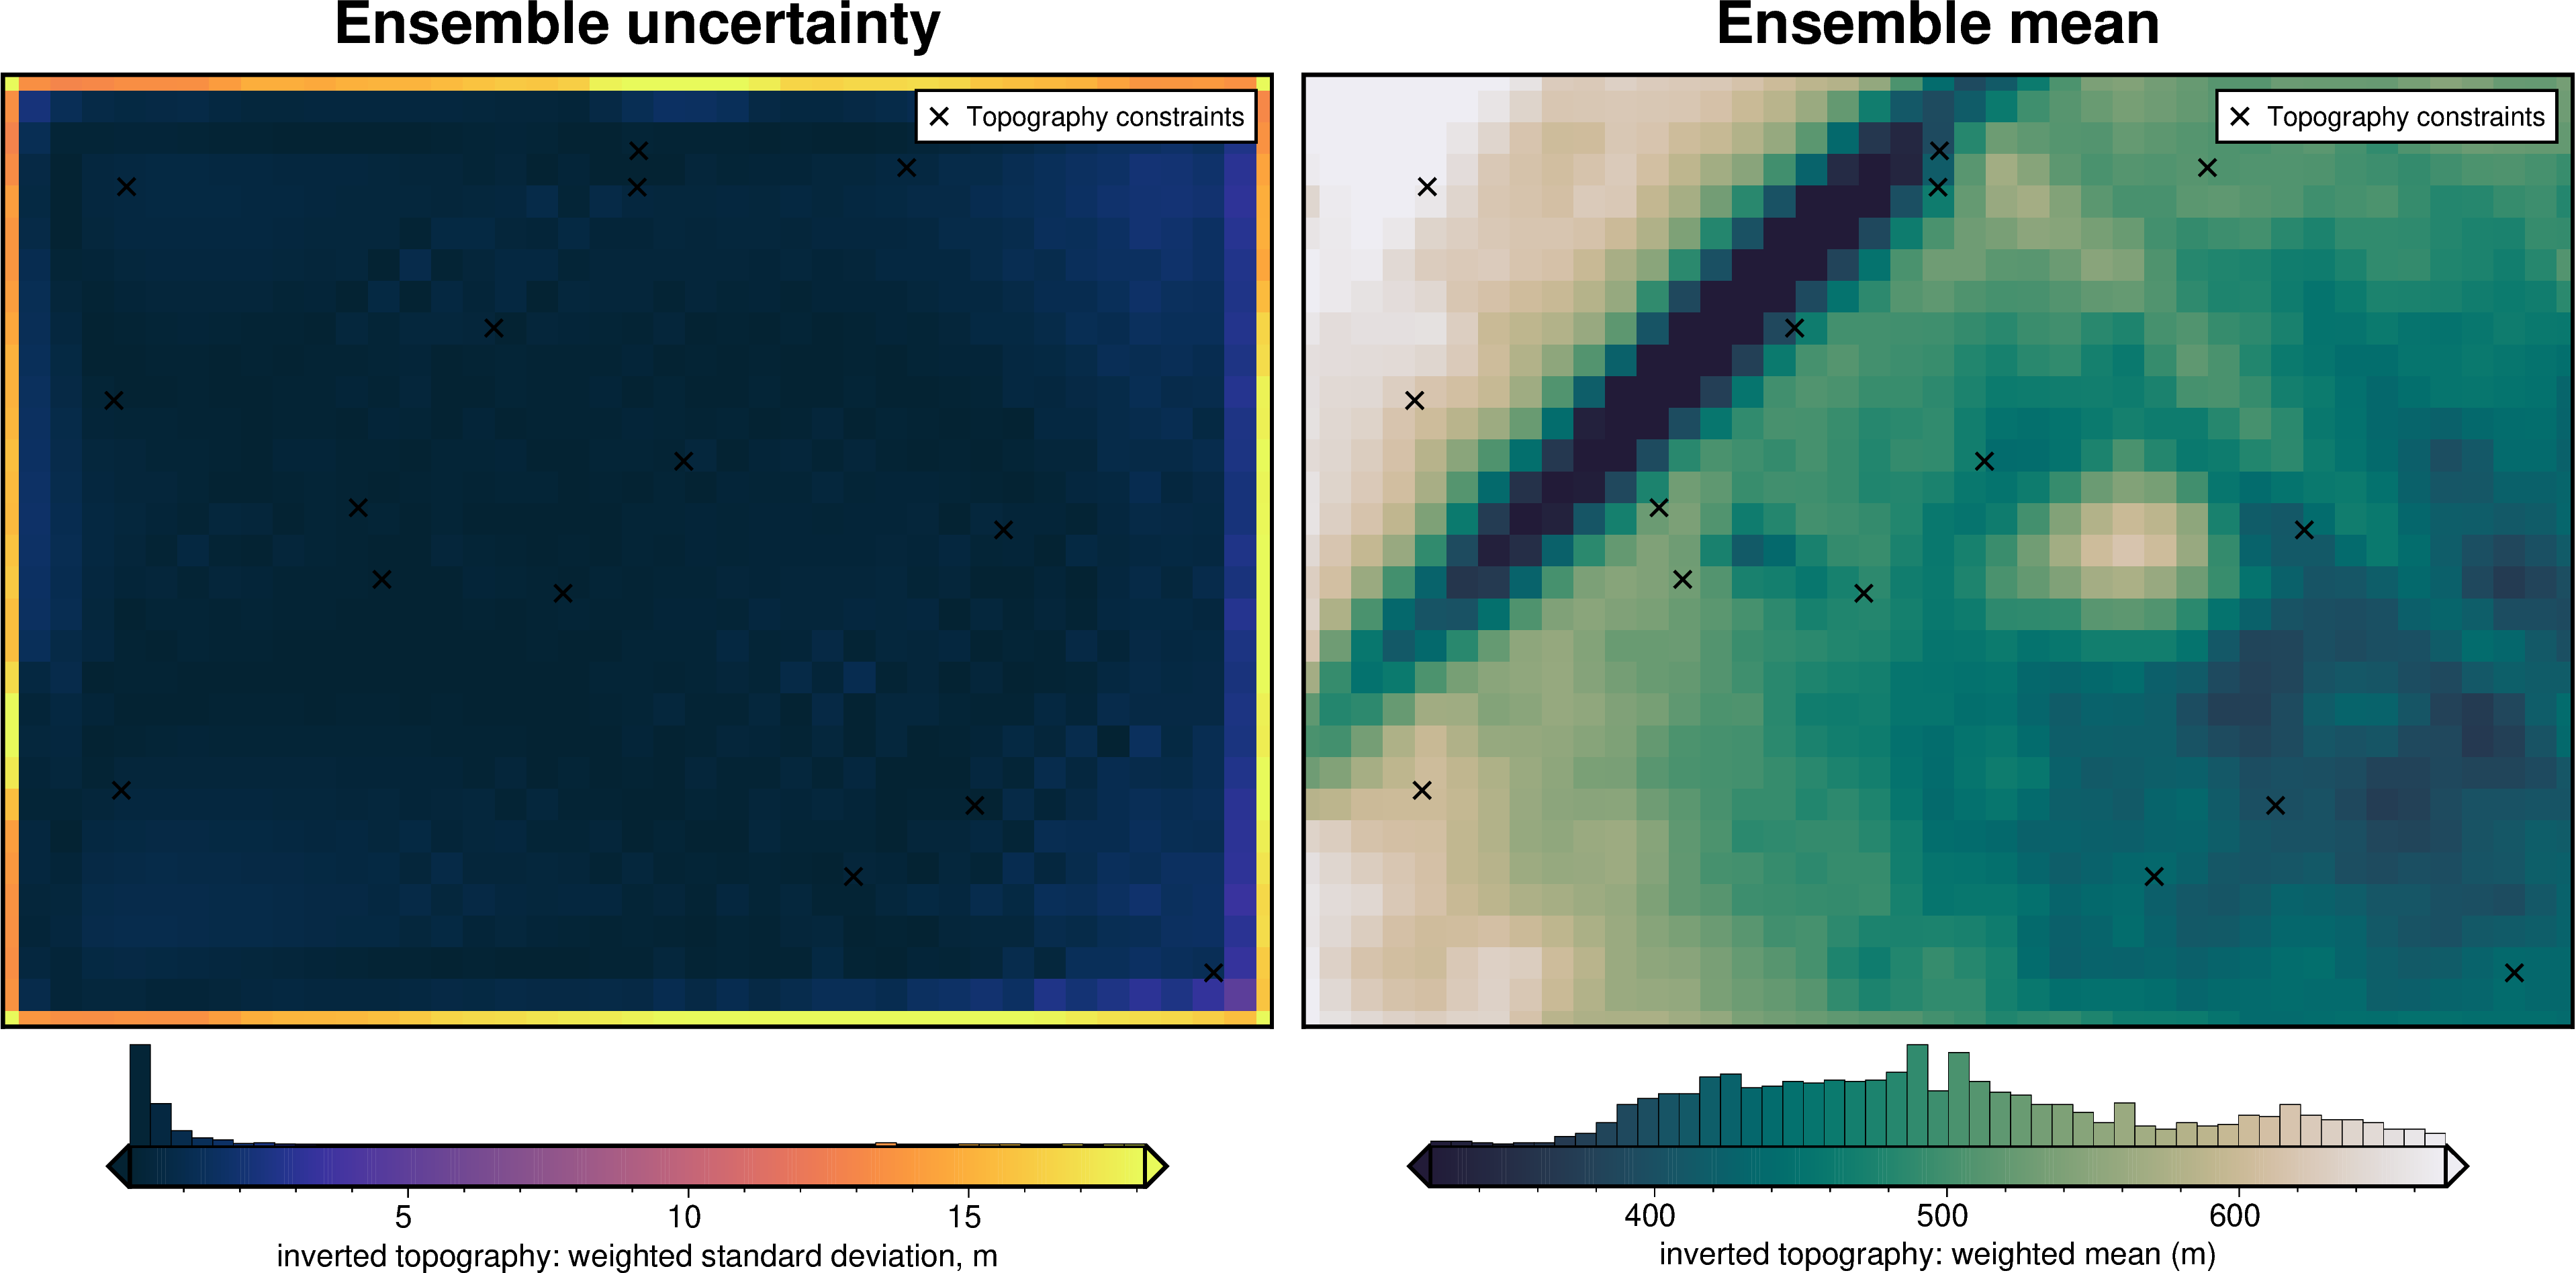

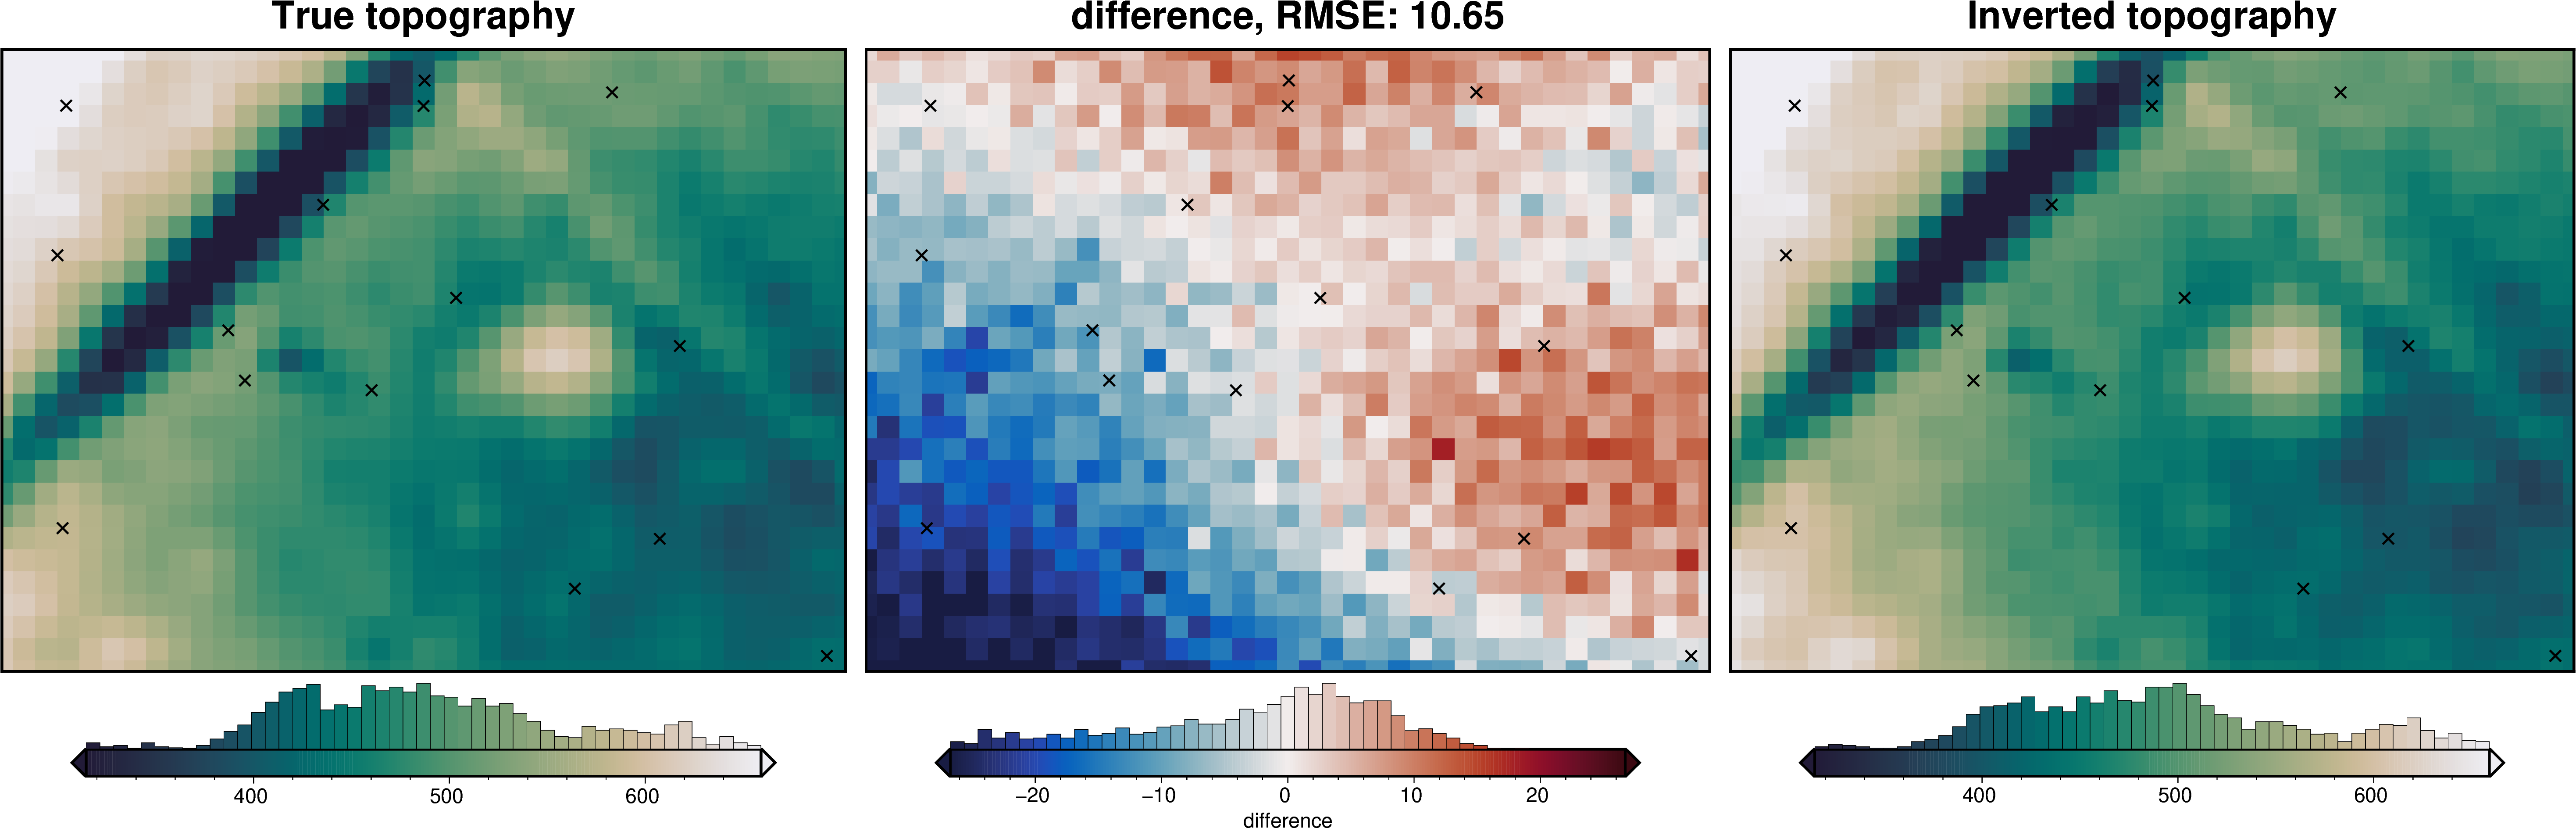

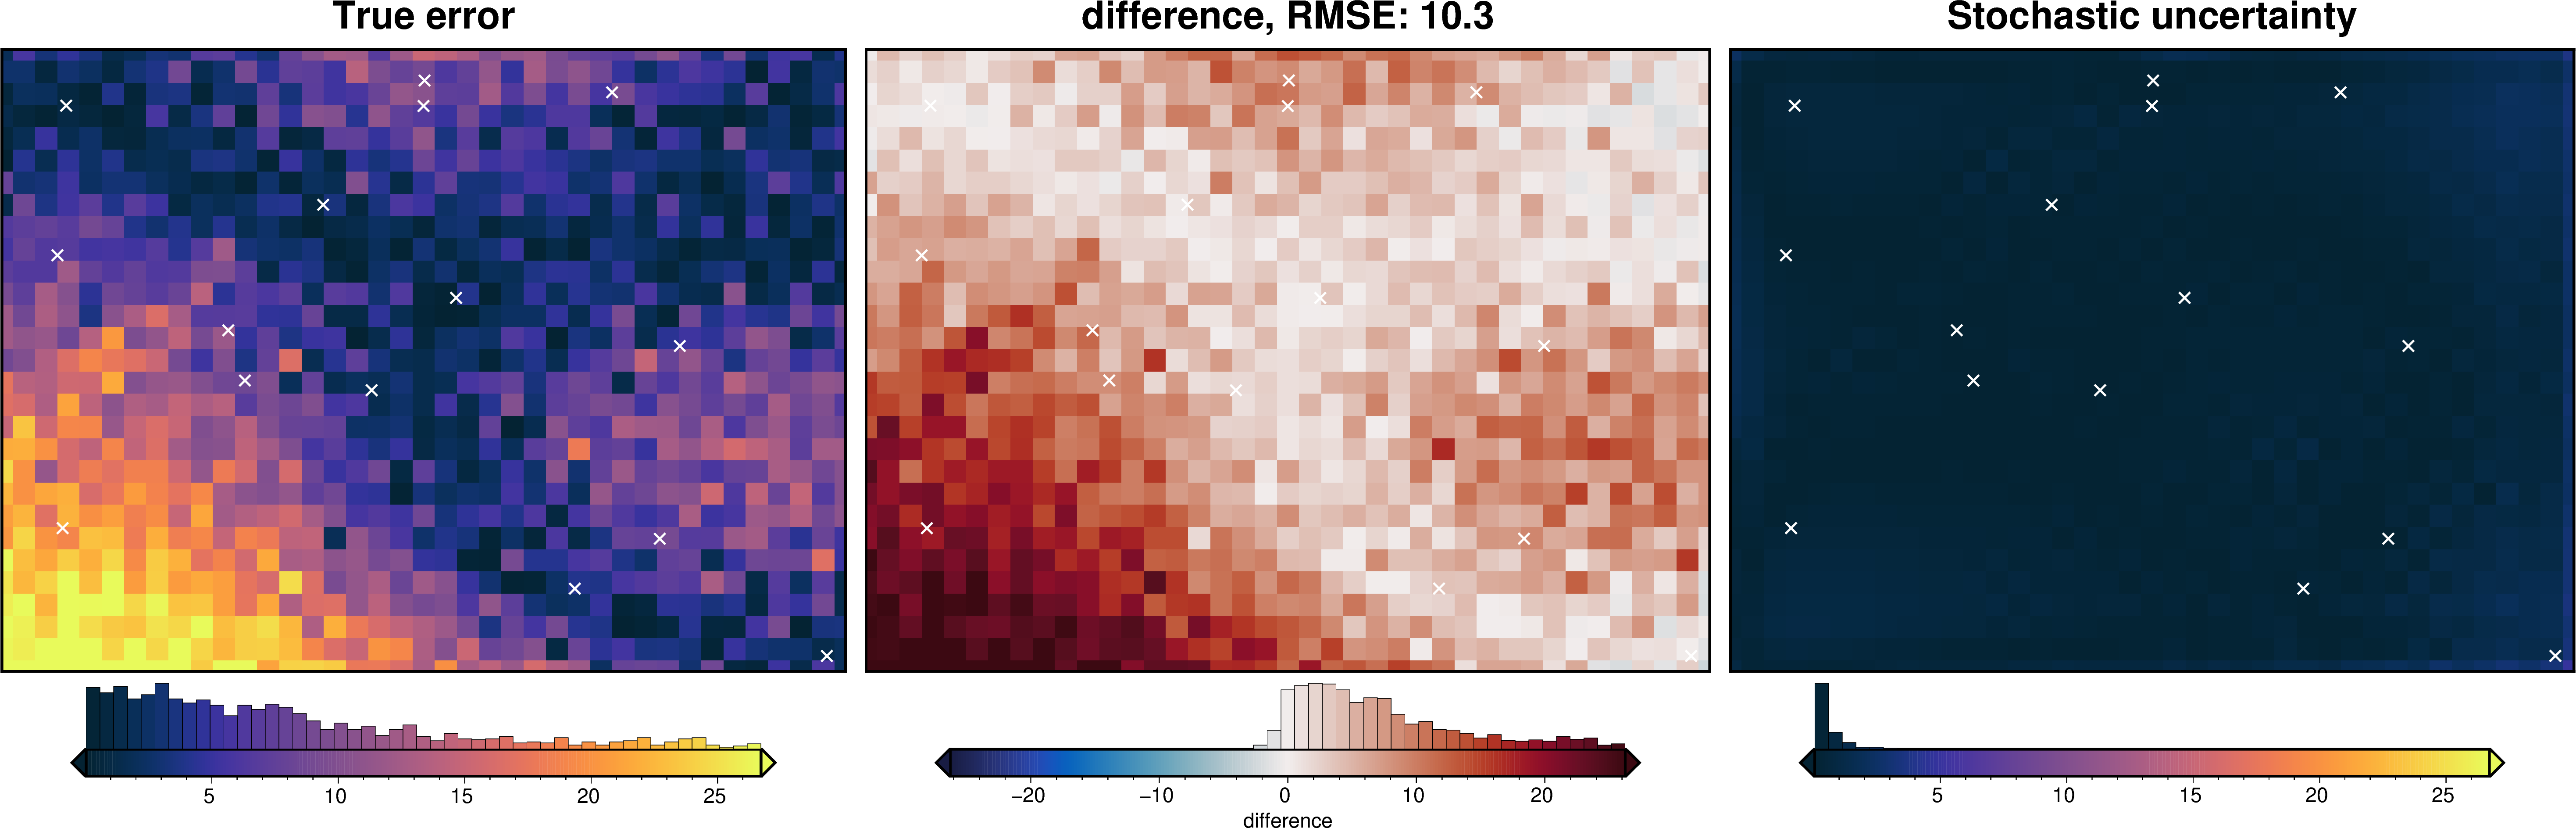

In [46]:
zref_dict = {
    "zref": {
        "distribution": "normal",
        "loc": zref,
        "scale": zref_stdev,
    },
}
fname = "../tmp/uncertainty_zref"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_zref_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=zref_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_zref_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Constraints component

INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_constraints' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_constraints'



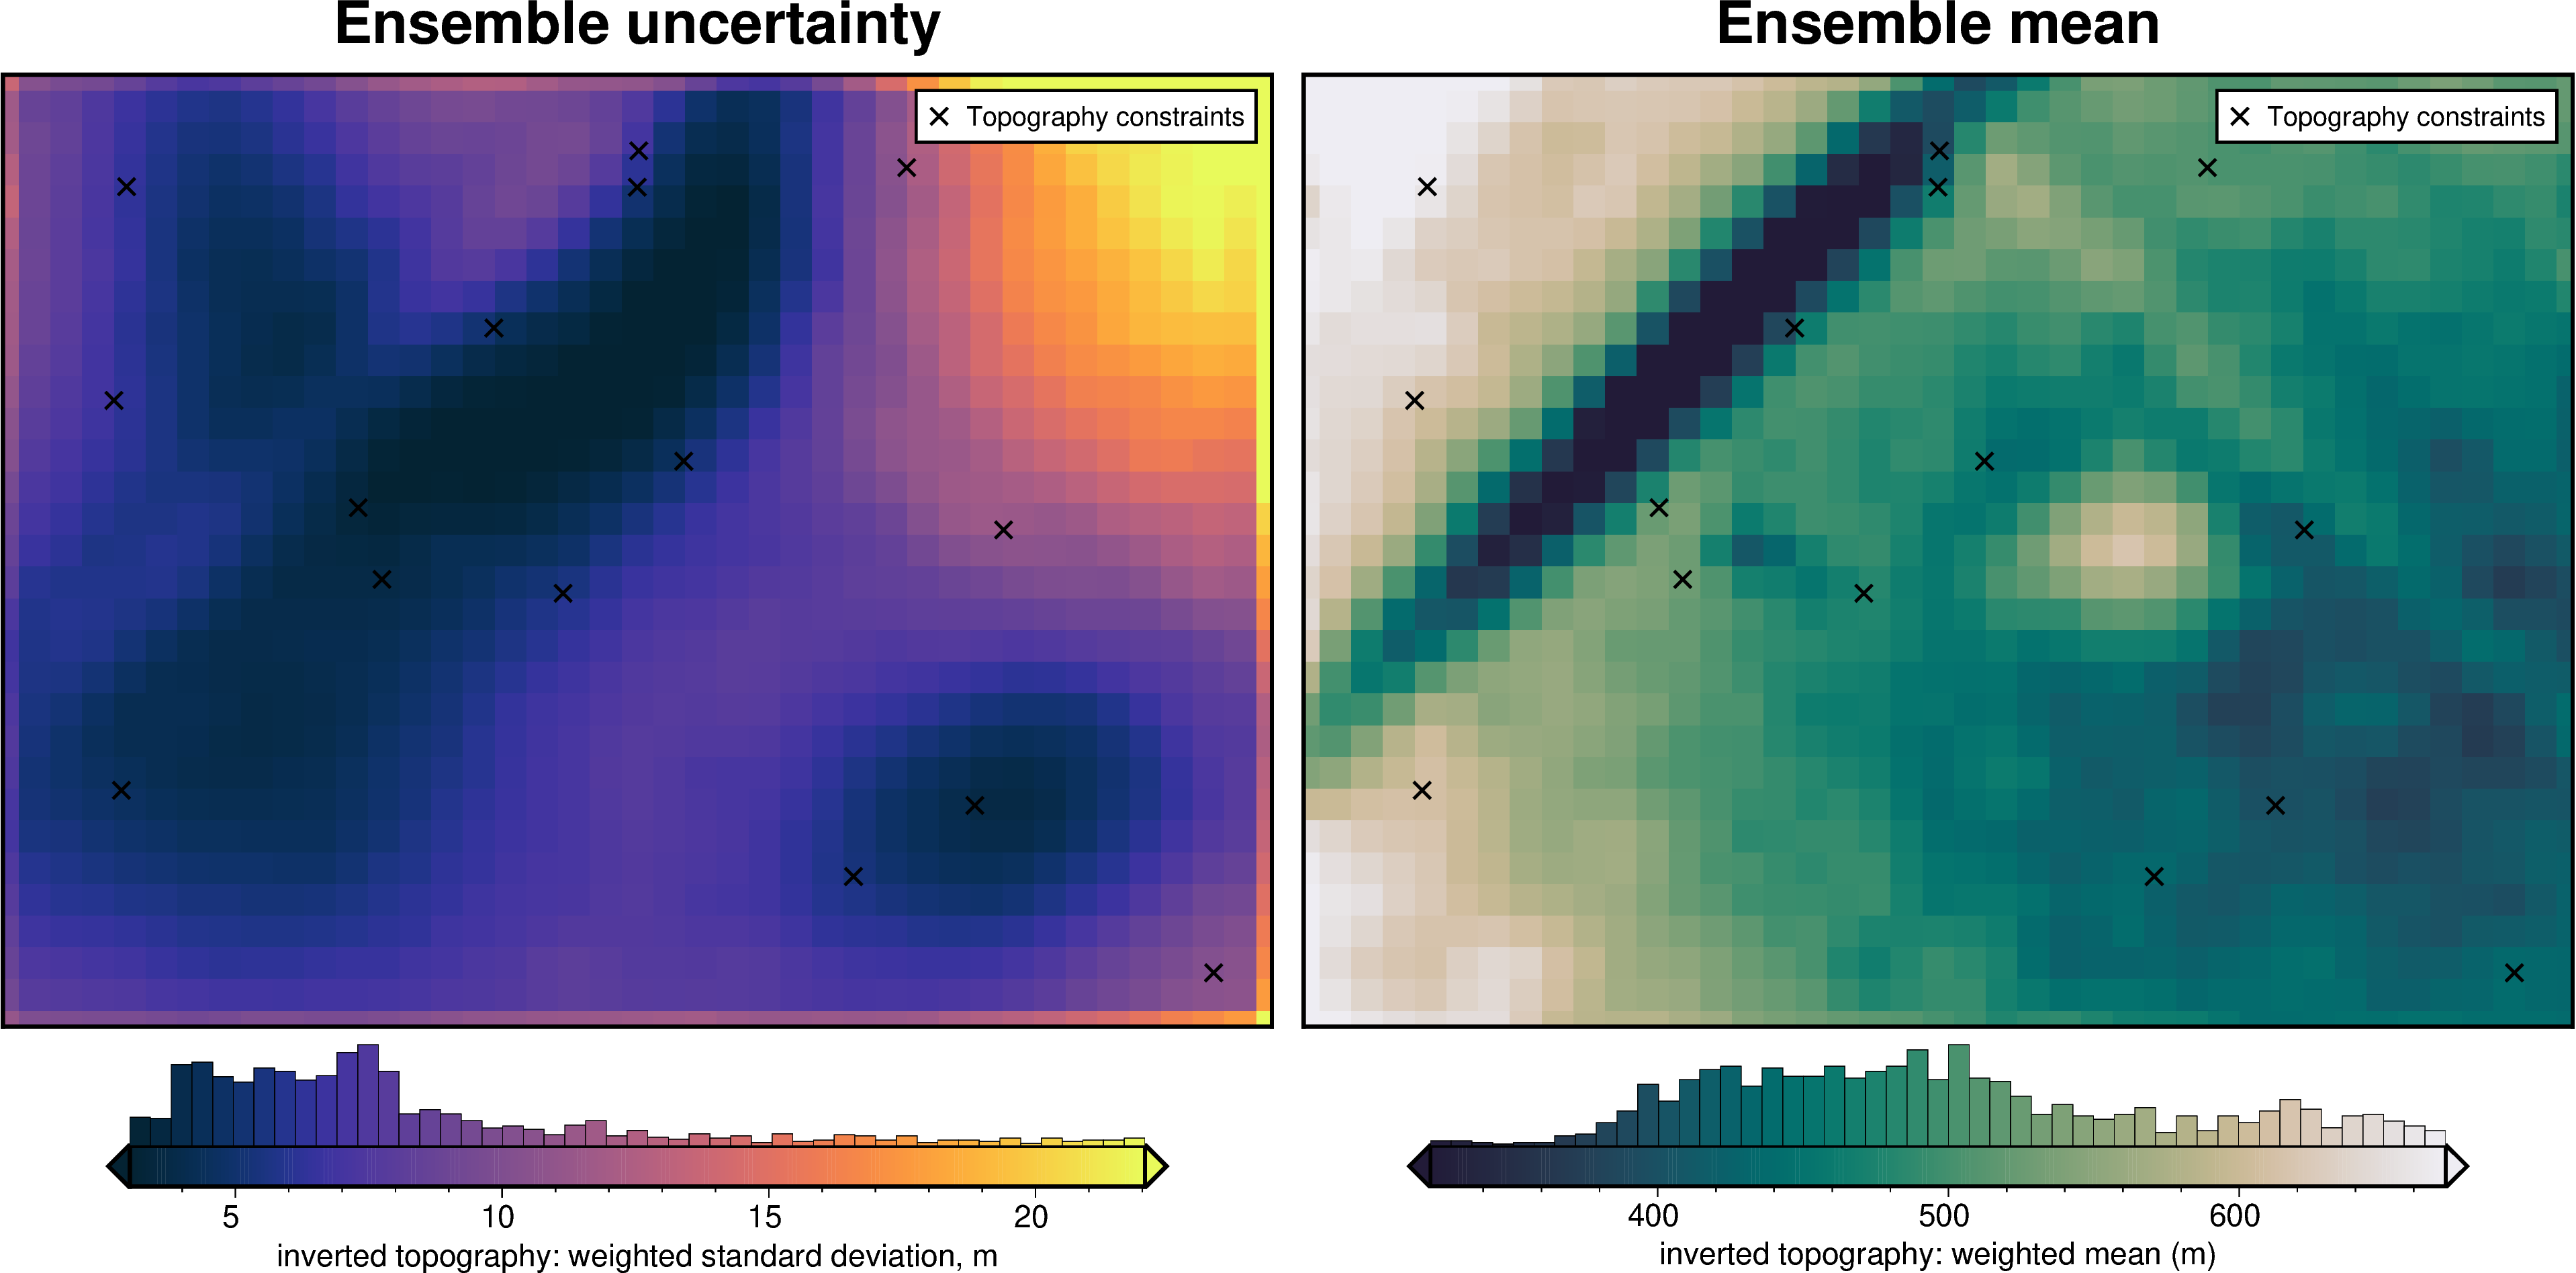

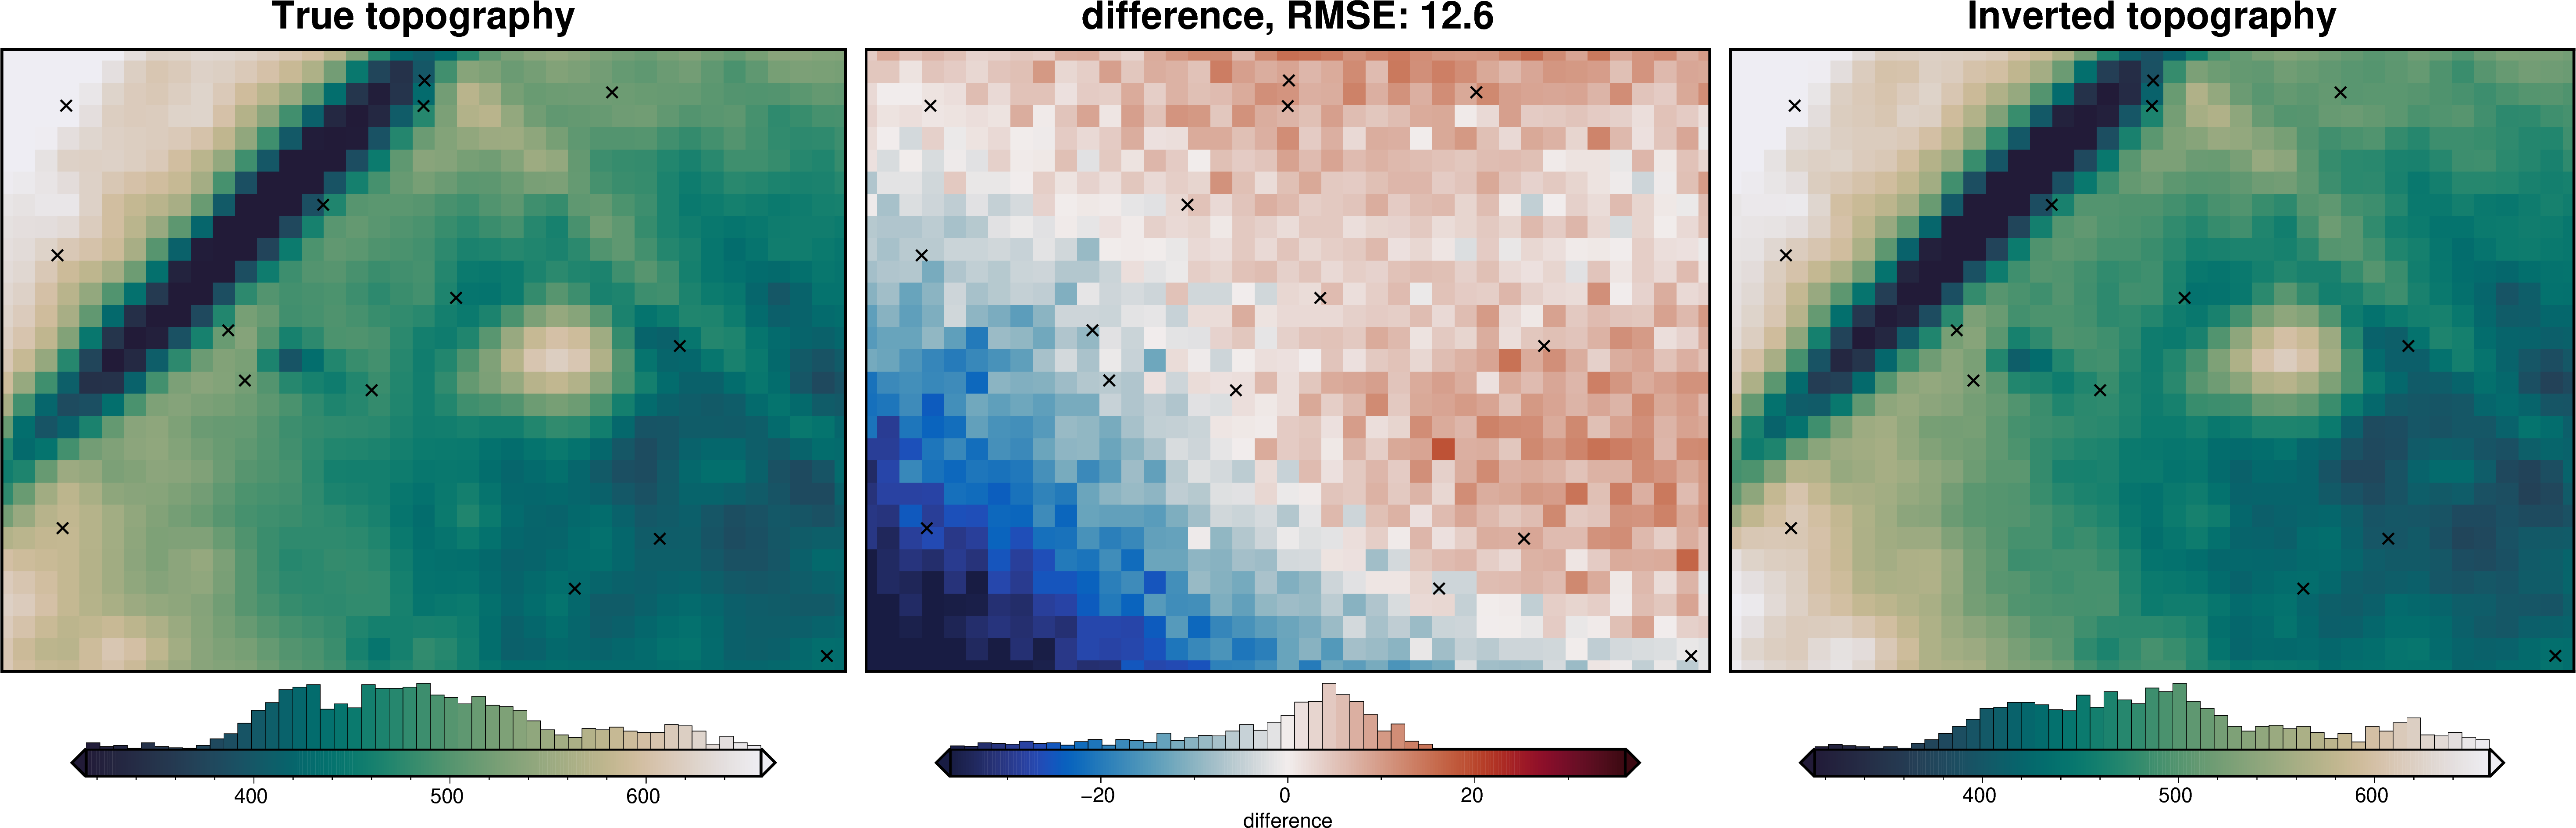

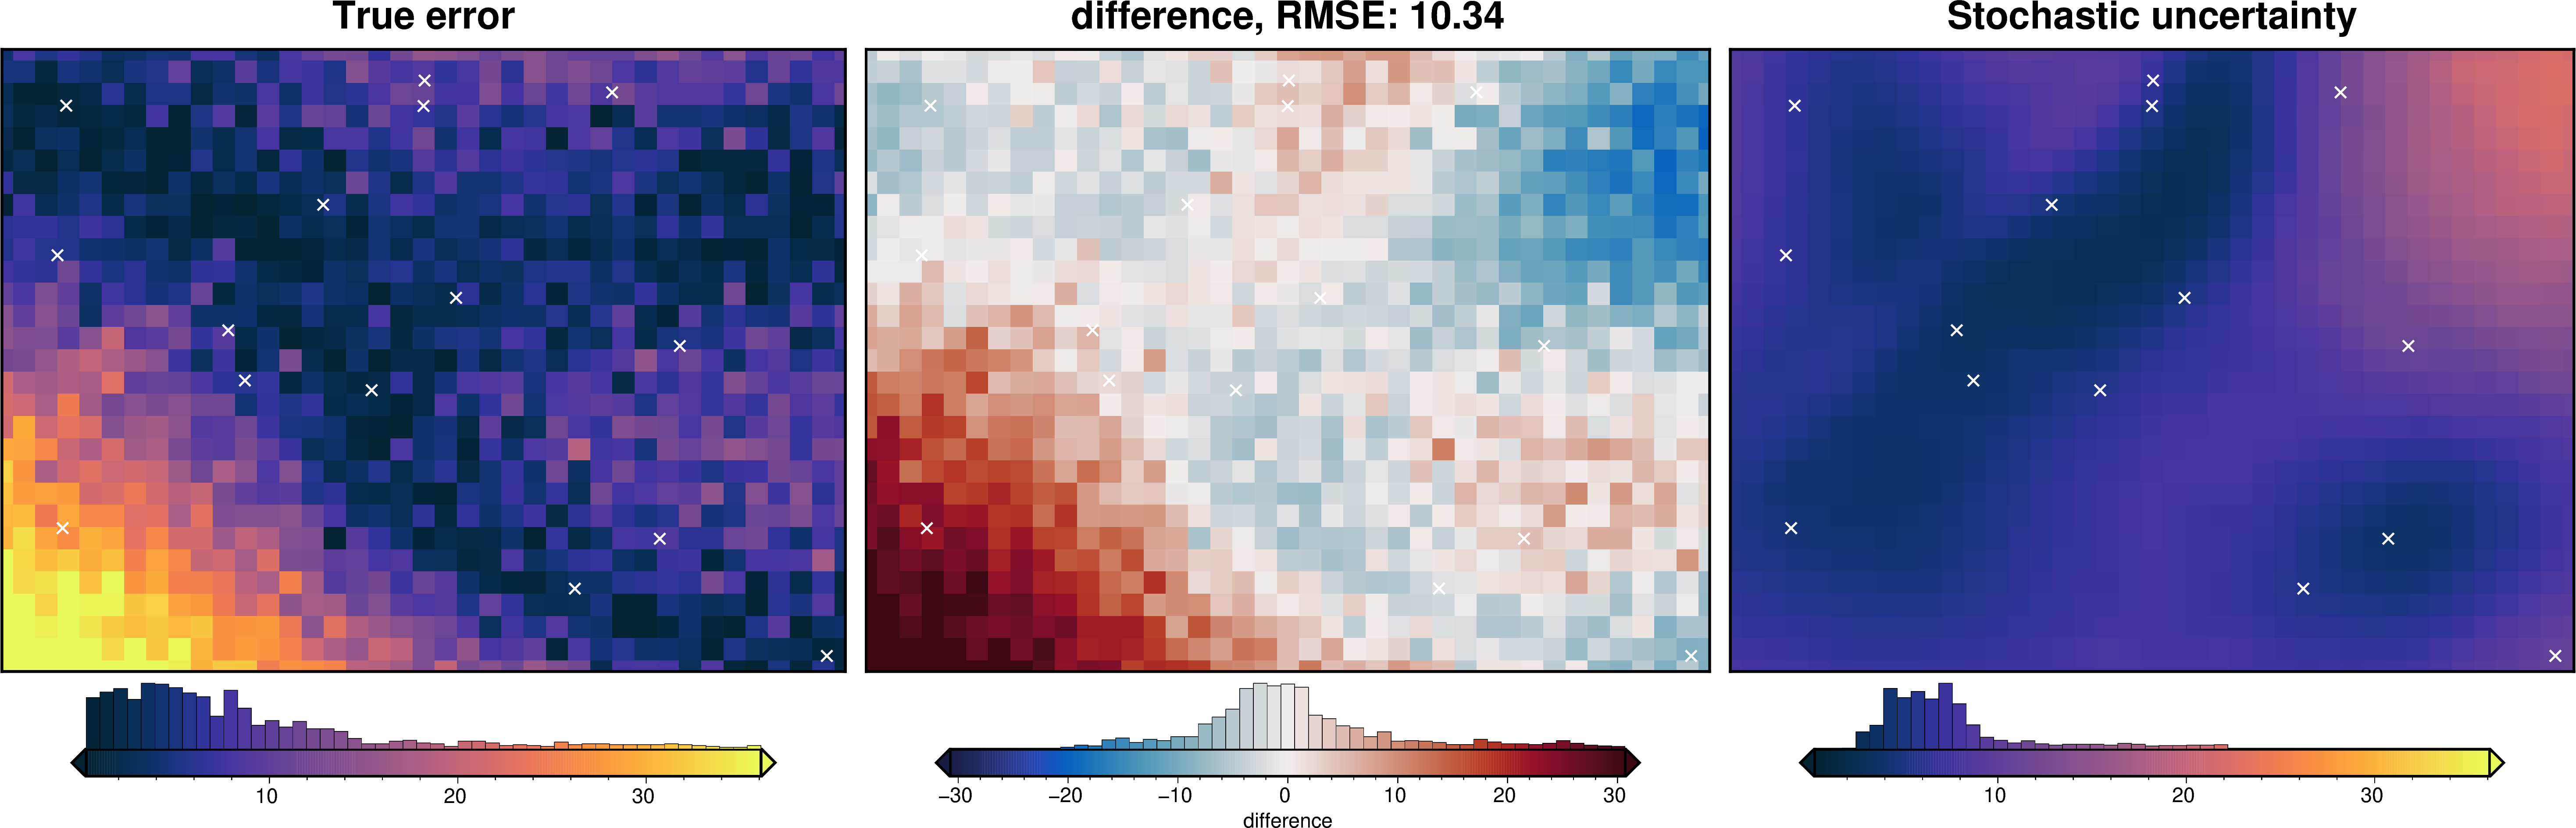

In [47]:
fname = "../tmp/uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    sample_constraints=True,
    constraints_df=constraint_points,
    starting_topography_kwargs=starting_topography_kwargs,
    runs=10,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_constraints_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Gravity component

In [48]:
grav_df.describe()

,northing,easting,upward,upper_surface_grav,lower_surface_grav,observed_grav,gravity_anomaly,uncert,starting_gravity,true_res,misfit,reg,res,staring_res,starting_reg
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.128924,0.004007,-0.124917,-0.124917,0.1,0.873936,-1.258972,-0.998852,-0.416104,-0.582749,-0.582749,-0.416104
std,8947.792584,11836.81698,0.0,7.128555,0.714063,7.271000,7.269461,0.0,7.434955,4.602393,4.997721,1.299561,4.542107,4.542107,1.299561
min,0.000000,0.00000,1001.0,-17.179165,-1.033526,-16.887669,-17.040892,0.1,-8.988737,-19.592049,-20.191637,-2.608591,-18.534755,-18.534755,-2.608591
25%,7000.000000,10000.00000,1001.0,-5.448853,-0.601914,-5.750137,-5.739415,0.1,-5.020069,-3.001264,-3.034932,-1.471977,-2.307110,-2.307110,-1.471977
50%,15000.000000,20000.00000,1001.0,-1.160222,-0.153040,-0.758131,-0.713654,0.1,-0.990450,-1.444045,-1.515392,-0.493869,-0.629071,-0.629071,-0.493869
75%,23000.000000,30000.00000,1001.0,3.675021,0.541706,3.825804,3.815224,0.1,5.526057,0.461464,1.048934,0.656853,1.277380,1.277380,0.656853
max,30000.000000,40000.00000,1001.0,19.599674,1.599823,19.781652,19.936108,0.1,24.765890,13.969991,14.987722,1.920849,14.706053,14.706053,1.920849


In [49]:
grav_df.res

0      -0.450772
2      -0.783432
4      -0.589426
6      -0.216578
8       0.470434
          ...   
4932   -3.966931
4934   -4.630970
4936   -5.665972
4938   -6.018852
4940   -5.272374
Name: res, Length: 1271, dtype: float64

INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_grav' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_grav'



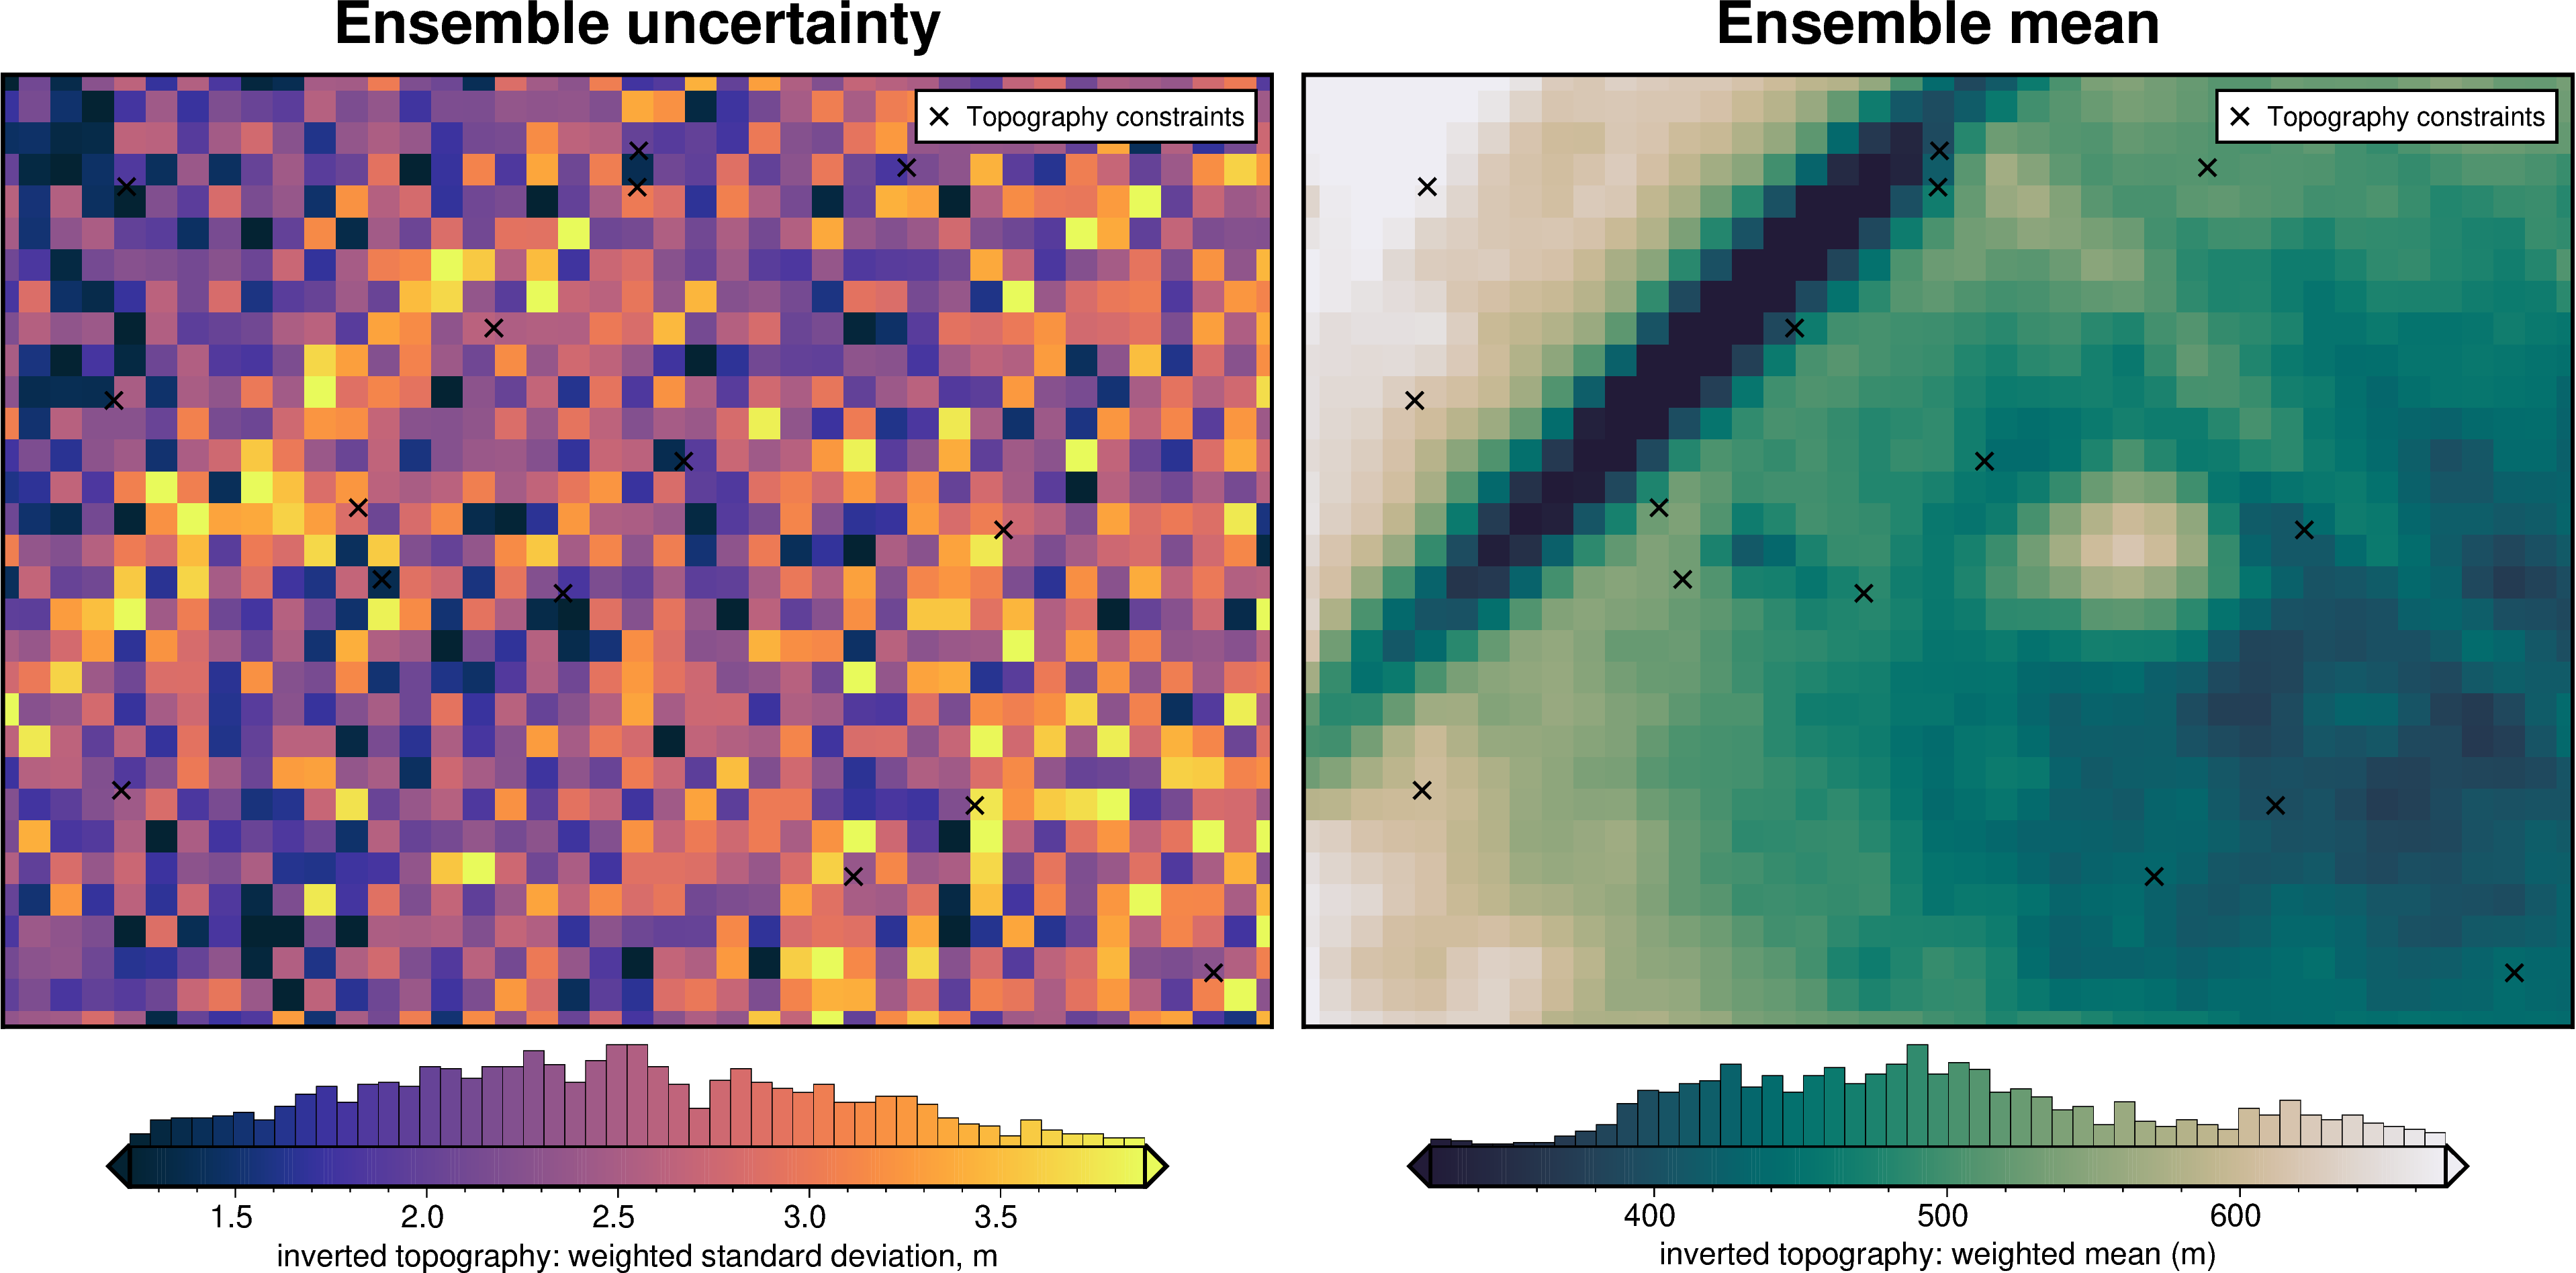

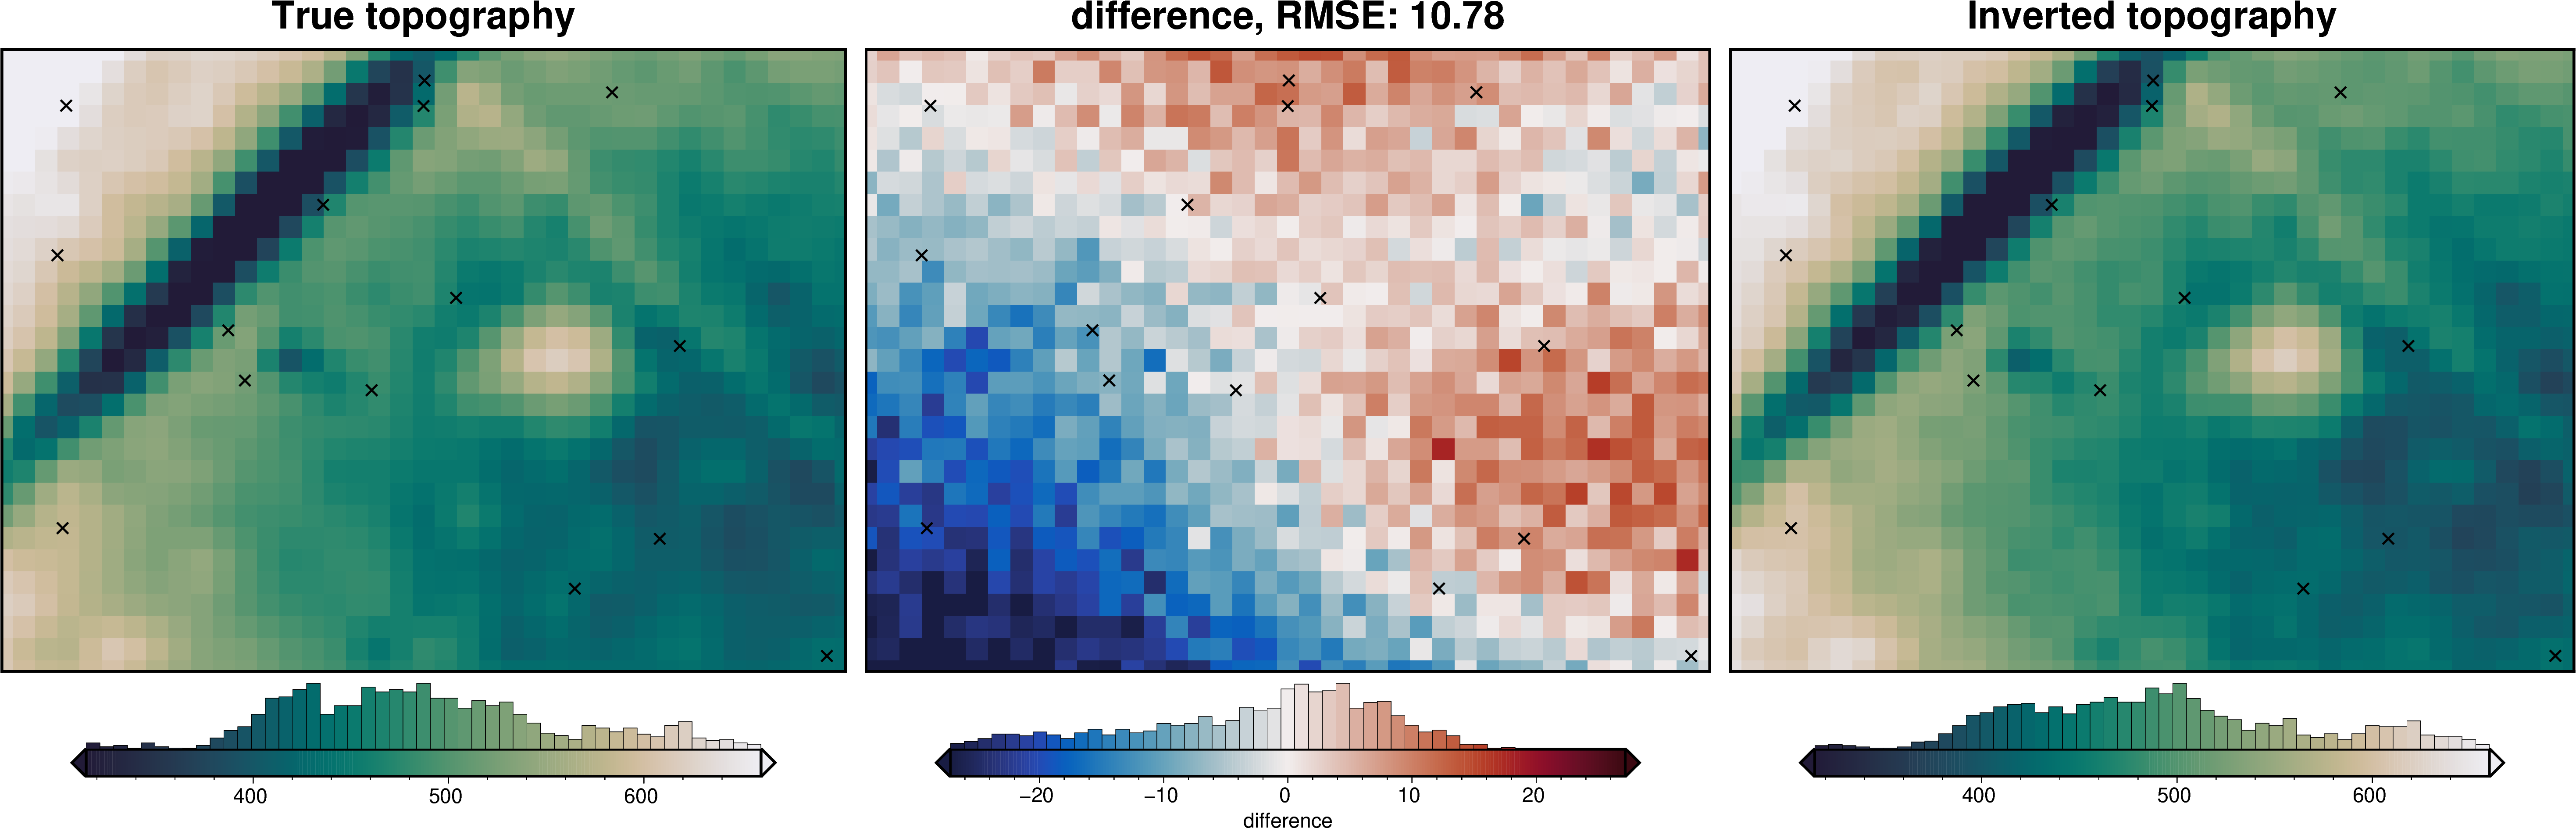

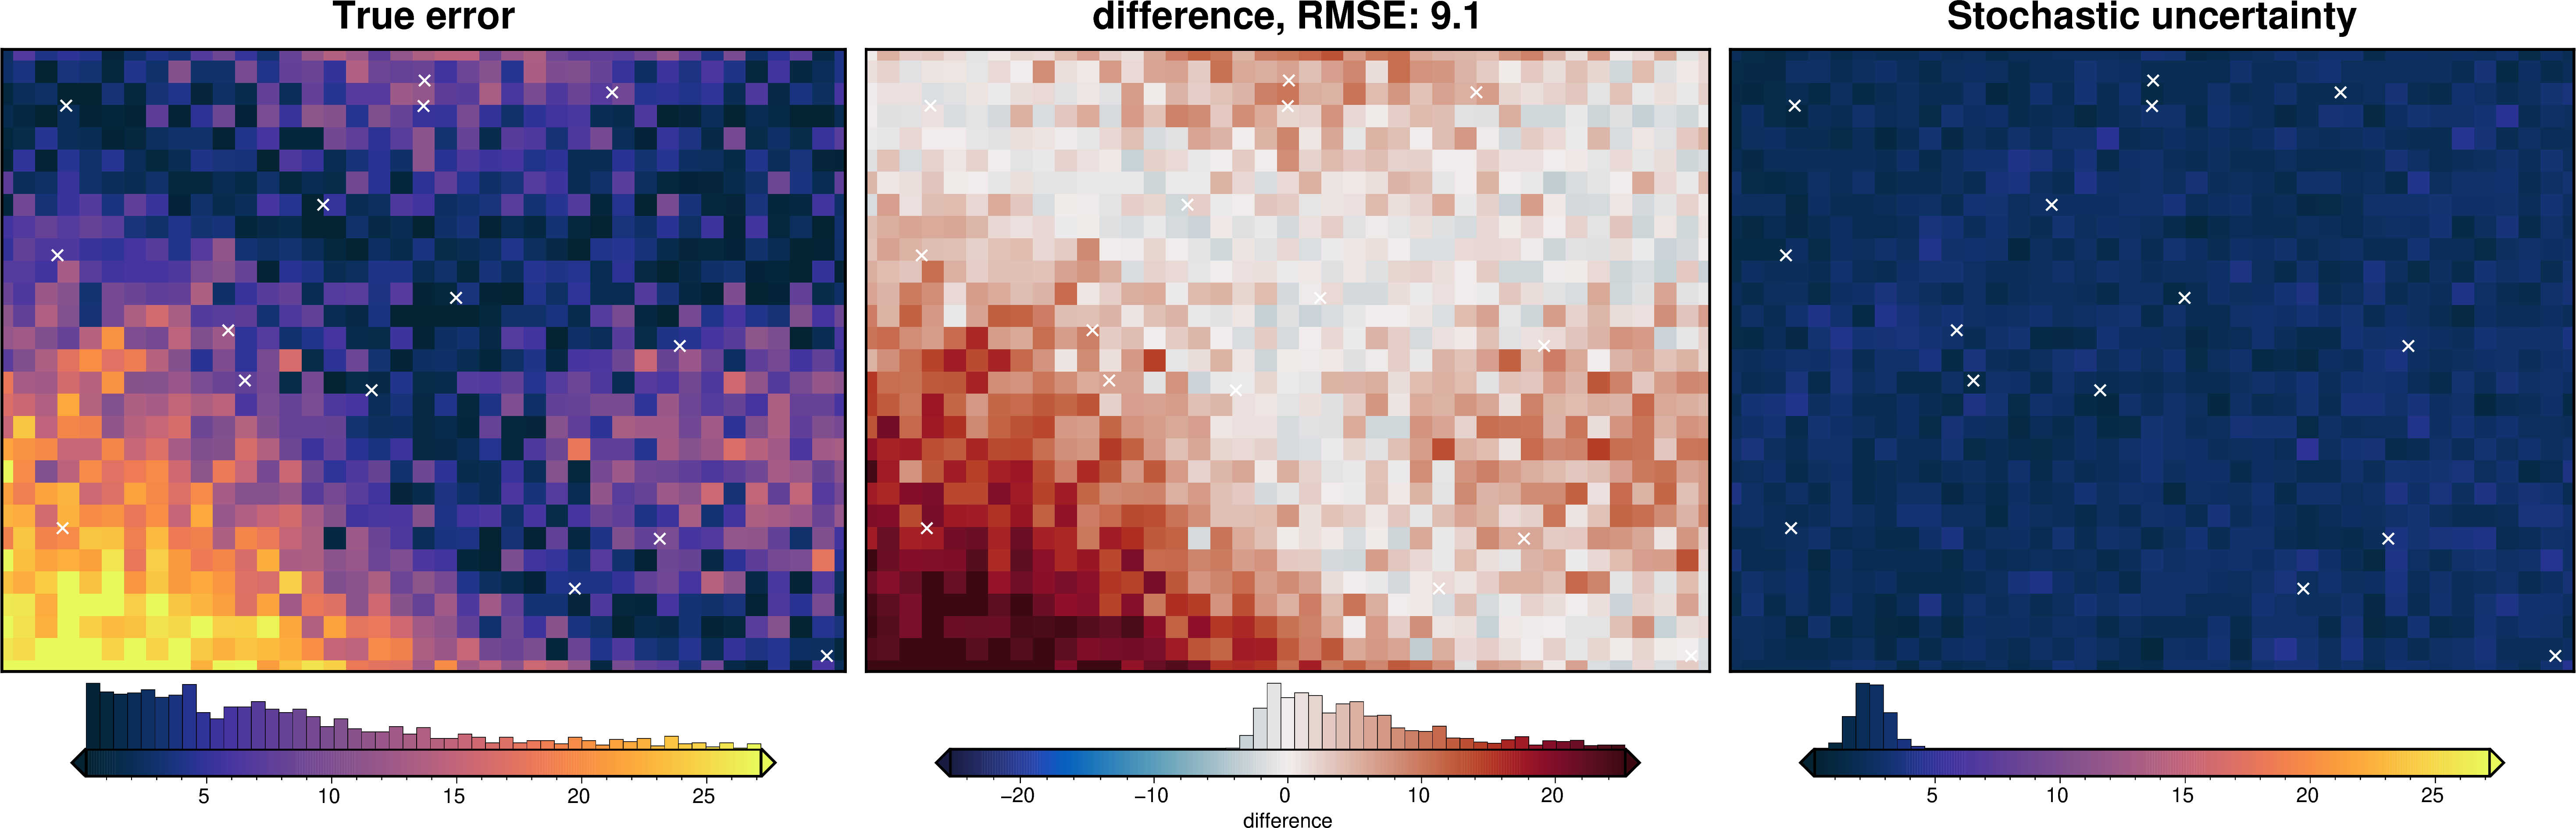

In [50]:
fname = "../tmp/uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    sample_gravity=True,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_grav_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Regional gravity component

In [54]:
reg_eq_depth, reg_eq_damping

(np.float64(25196.204289908077), 0.000763324315253277)

INFO:invert4geom:Sampled 'depth' parameter values; mean: 25196.204289908077, min: 18706.0921550931, max: 31686.316424723052
INFO:invert4geom:Sampled 'damping' parameter values; mean: 157874.43550164072, min: 3.796574116821032e-14, max: 15347099.577888986


starting regional ensemble:   0%|          | 0/100 [00:00<?, ?it/s]

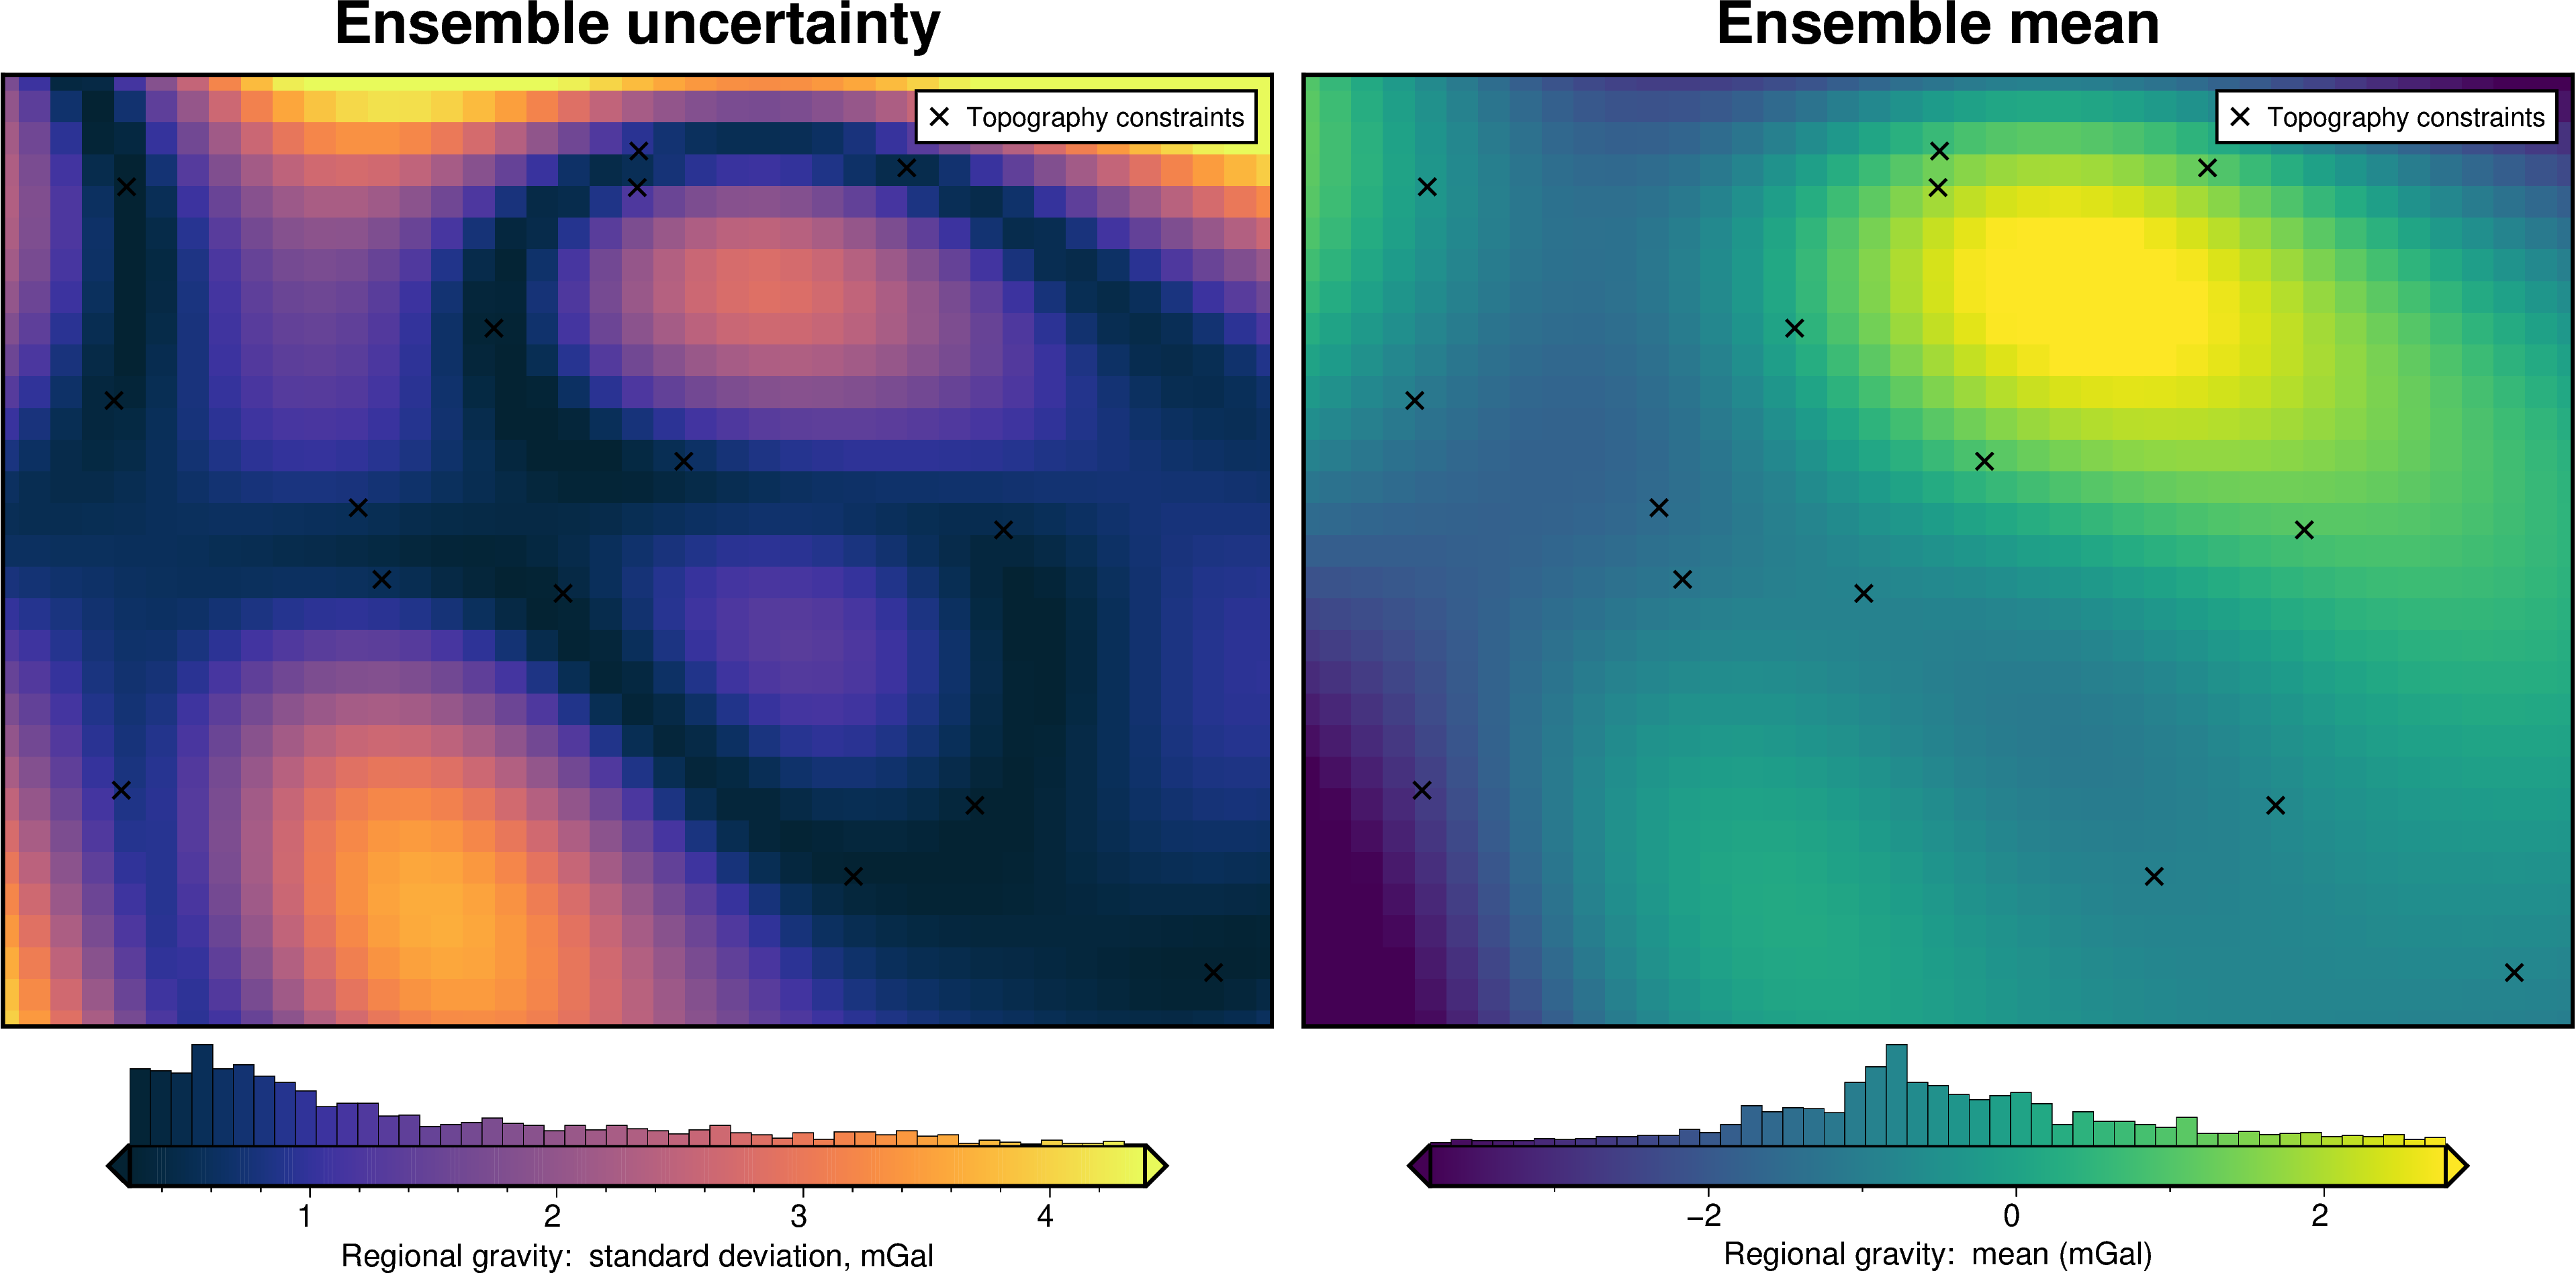

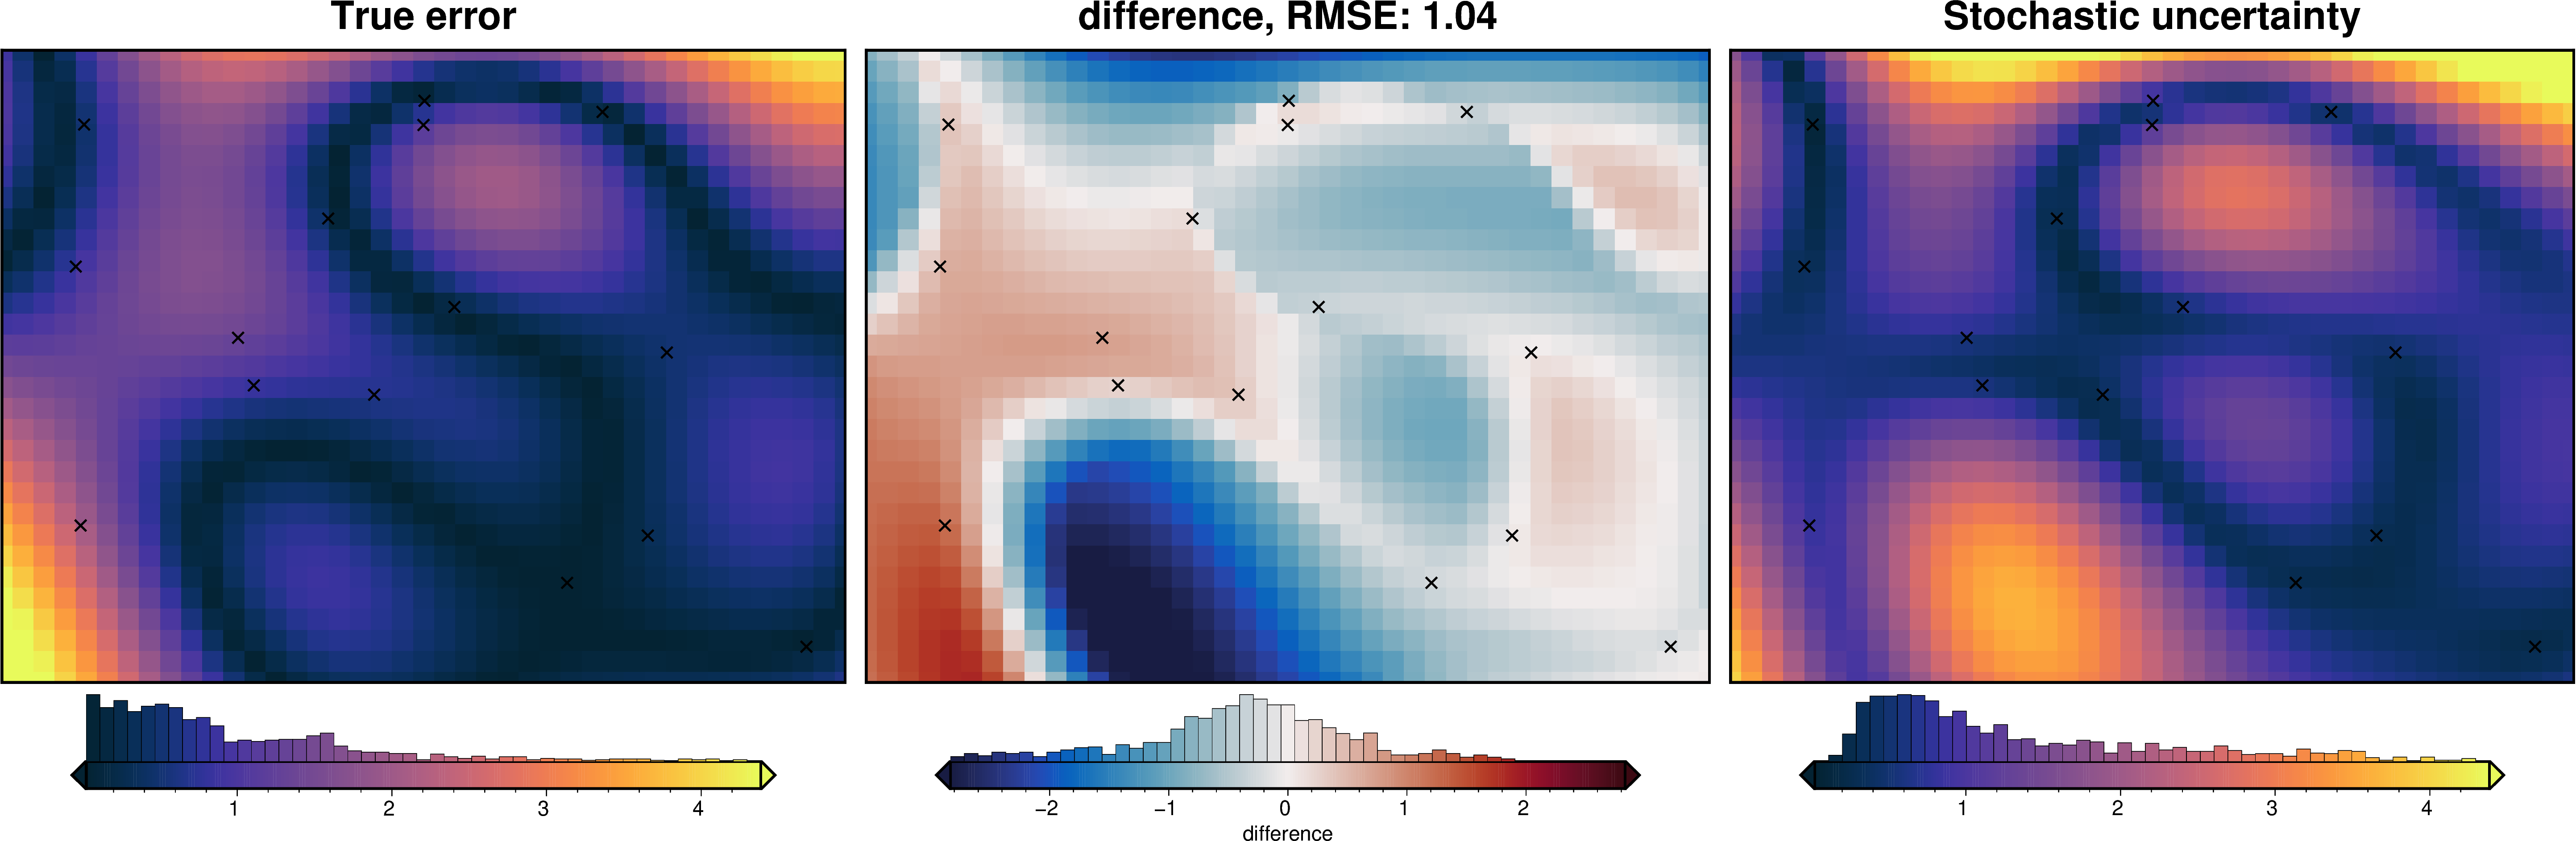

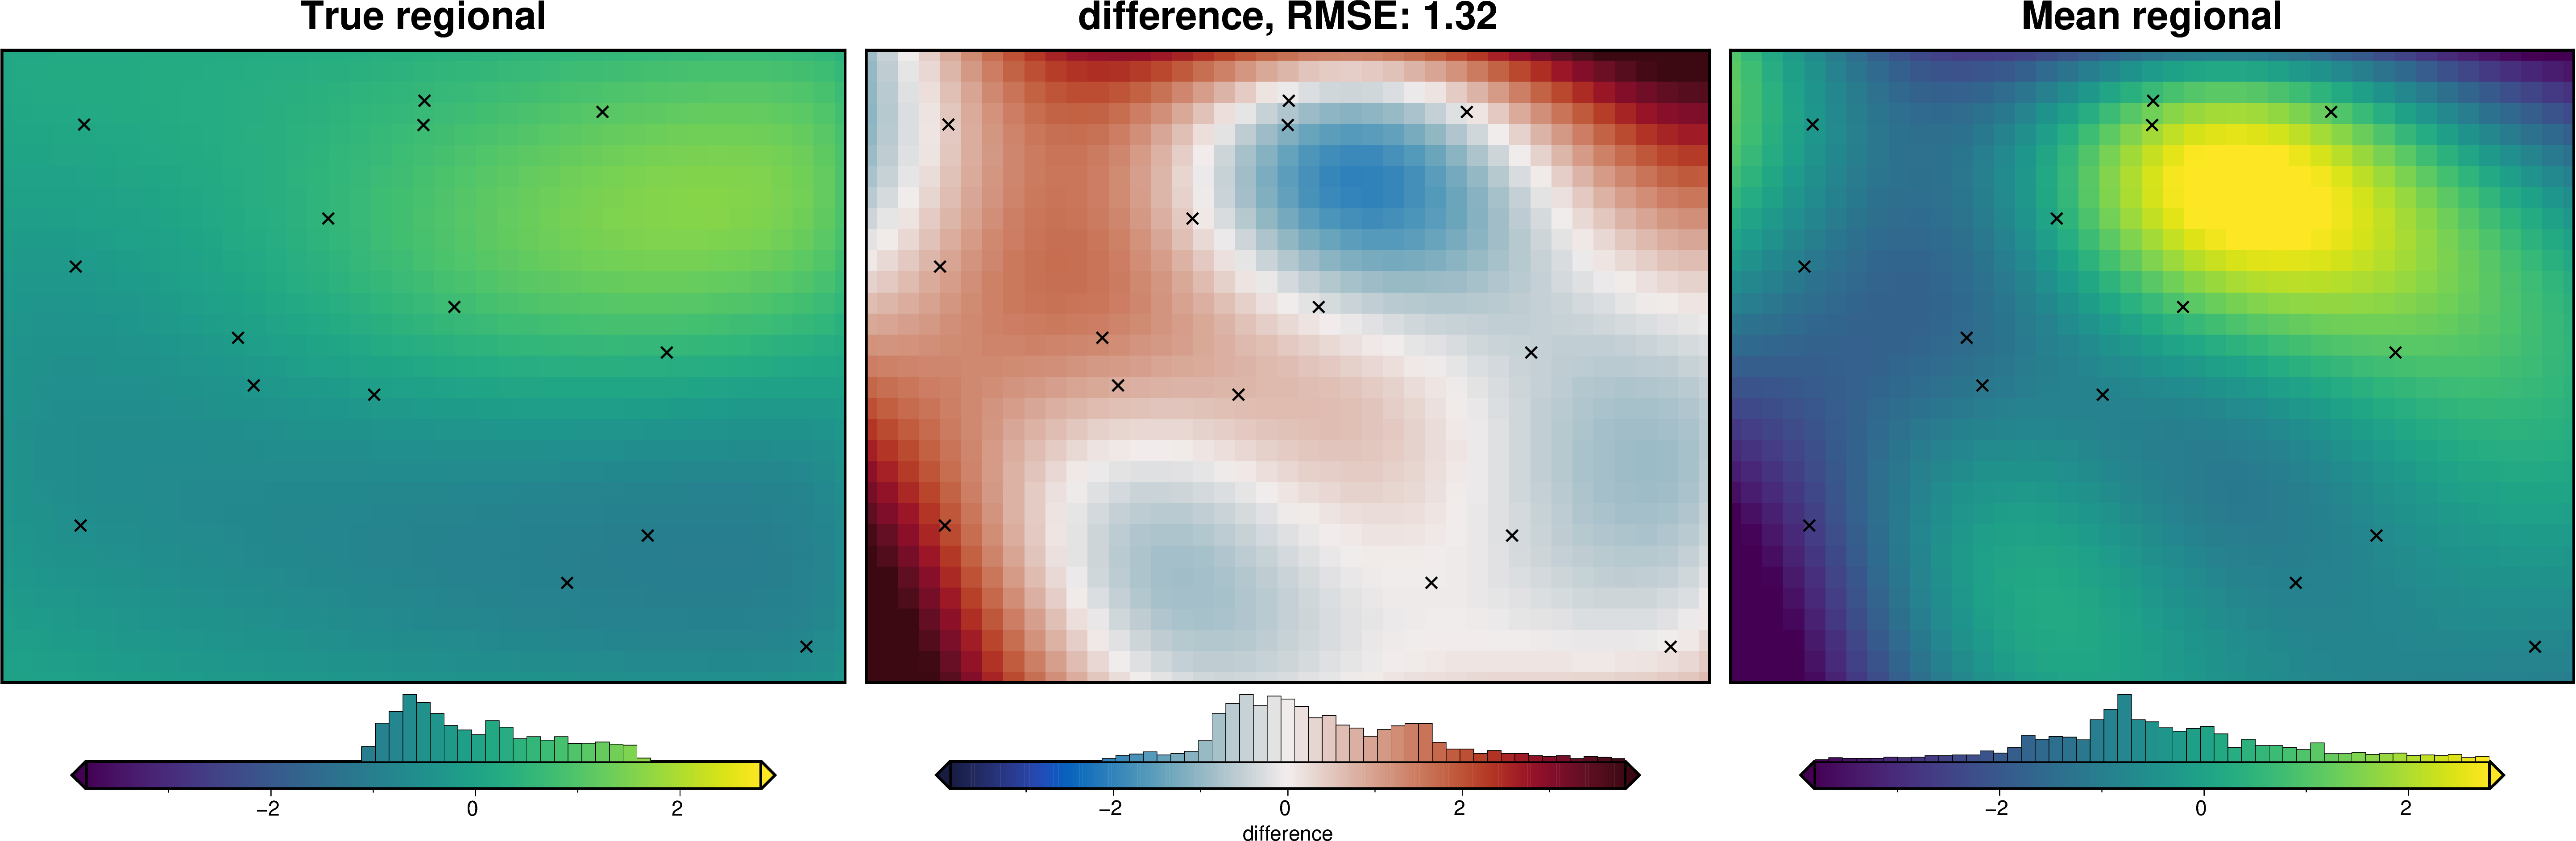

In [ ]:
regional_misfit_parameter_dict = {
    "depth": {
        "distribution": "normal",
        "loc": reg_eq_depth,  # mean
        "scale": reg_eq_depth / 10,  # standard deviation
    },
    "damping": {
        "distribution": "normal",
        "loc": np.log10(reg_eq_damping),  # mean base 10 exponent
        # "scale": np.abs(np.log10(reg_eq_damping)),  # standard deviation of exponent
        "scale": 4,
        "log": True,
    },
}

regional_misfit_stats = uncertainty.regional_misfit_uncertainty(
    runs=100,
    parameter_dict=regional_misfit_parameter_dict,
    true_regional=grav_grid.lower_surface_grav,
    # weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
    grav_df=grav_df,
    **new_regional_grav_kwargs,
)

In [60]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_grid["reg_uncert"] = regional_misfit_stats.z_stdev
grav_df_new = vd.grid_to_table(grav_grid)
grav_df_new

,northing,easting,upward,upper_surface_grav,lower_surface_grav,observed_grav,gravity_anomaly,uncert,starting_gravity,true_res,misfit,reg,res,staring_res,starting_reg,reg_uncert
0,0.0,0.0,1001.0,9.042402,-0.041223,9.001179,9.017793,0.1,12.053688,-2.349335,-3.035895,-2.585123,-0.450772,-0.450772,-2.585123,3.982674
1,0.0,1000.0,1001.0,9.568091,-0.052122,9.515969,9.506800,0.1,12.882907,-2.657964,-3.376107,-2.592675,-0.783432,-0.783432,-2.592675,3.434261
2,0.0,2000.0,1001.0,8.893385,-0.068787,8.824597,8.892680,0.1,12.076823,-2.514374,-3.184143,-2.594717,-0.589426,-0.589426,-2.594717,2.853436
3,0.0,3000.0,1001.0,8.340538,-0.088267,8.252272,8.266802,0.1,11.074445,-2.192106,-2.807643,-2.591065,-0.216578,-0.216578,-2.591065,2.258903
4,0.0,4000.0,1001.0,8.106202,-0.108803,7.997400,7.947874,0.1,10.059043,-1.548059,-2.111169,-2.581604,0.470434,0.470434,-2.581604,1.683099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1001.0,4.192357,0.658225,4.850582,4.742884,0.1,6.903165,-2.584922,-2.160282,1.806650,-3.966931,-3.966931,1.806650,5.778693
1267,30000.0,37000.0,1001.0,3.673729,0.641455,4.315185,4.385812,0.1,7.247310,-3.243353,-2.861497,1.769472,-4.630970,-4.630970,1.769472,5.970759
1268,30000.0,38000.0,1001.0,2.982330,0.607664,3.589994,3.623280,0.1,7.560472,-4.259751,-3.937192,1.728780,-5.665972,-5.665972,1.728780,6.137532
1269,30000.0,39000.0,1001.0,2.946999,0.545480,3.492479,3.401948,0.1,7.735632,-4.573146,-4.333684,1.685168,-6.018852,-6.018852,1.685168,6.279026


In [61]:
# update grav_df
uncert_kwargs["grav_df"] = grav_df_new

INFO:invert4geom:Sampled 'depth' parameter values; mean: 25196.204289908077, min: 21051.797488741522, max: 29340.611091074632
INFO:invert4geom:Sampled 'damping' parameter values; mean: 290.9255168676495, min: 2.010456075176567e-10, max: 2898.16831837875
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_regional' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../tmp/uncertainty_regional'



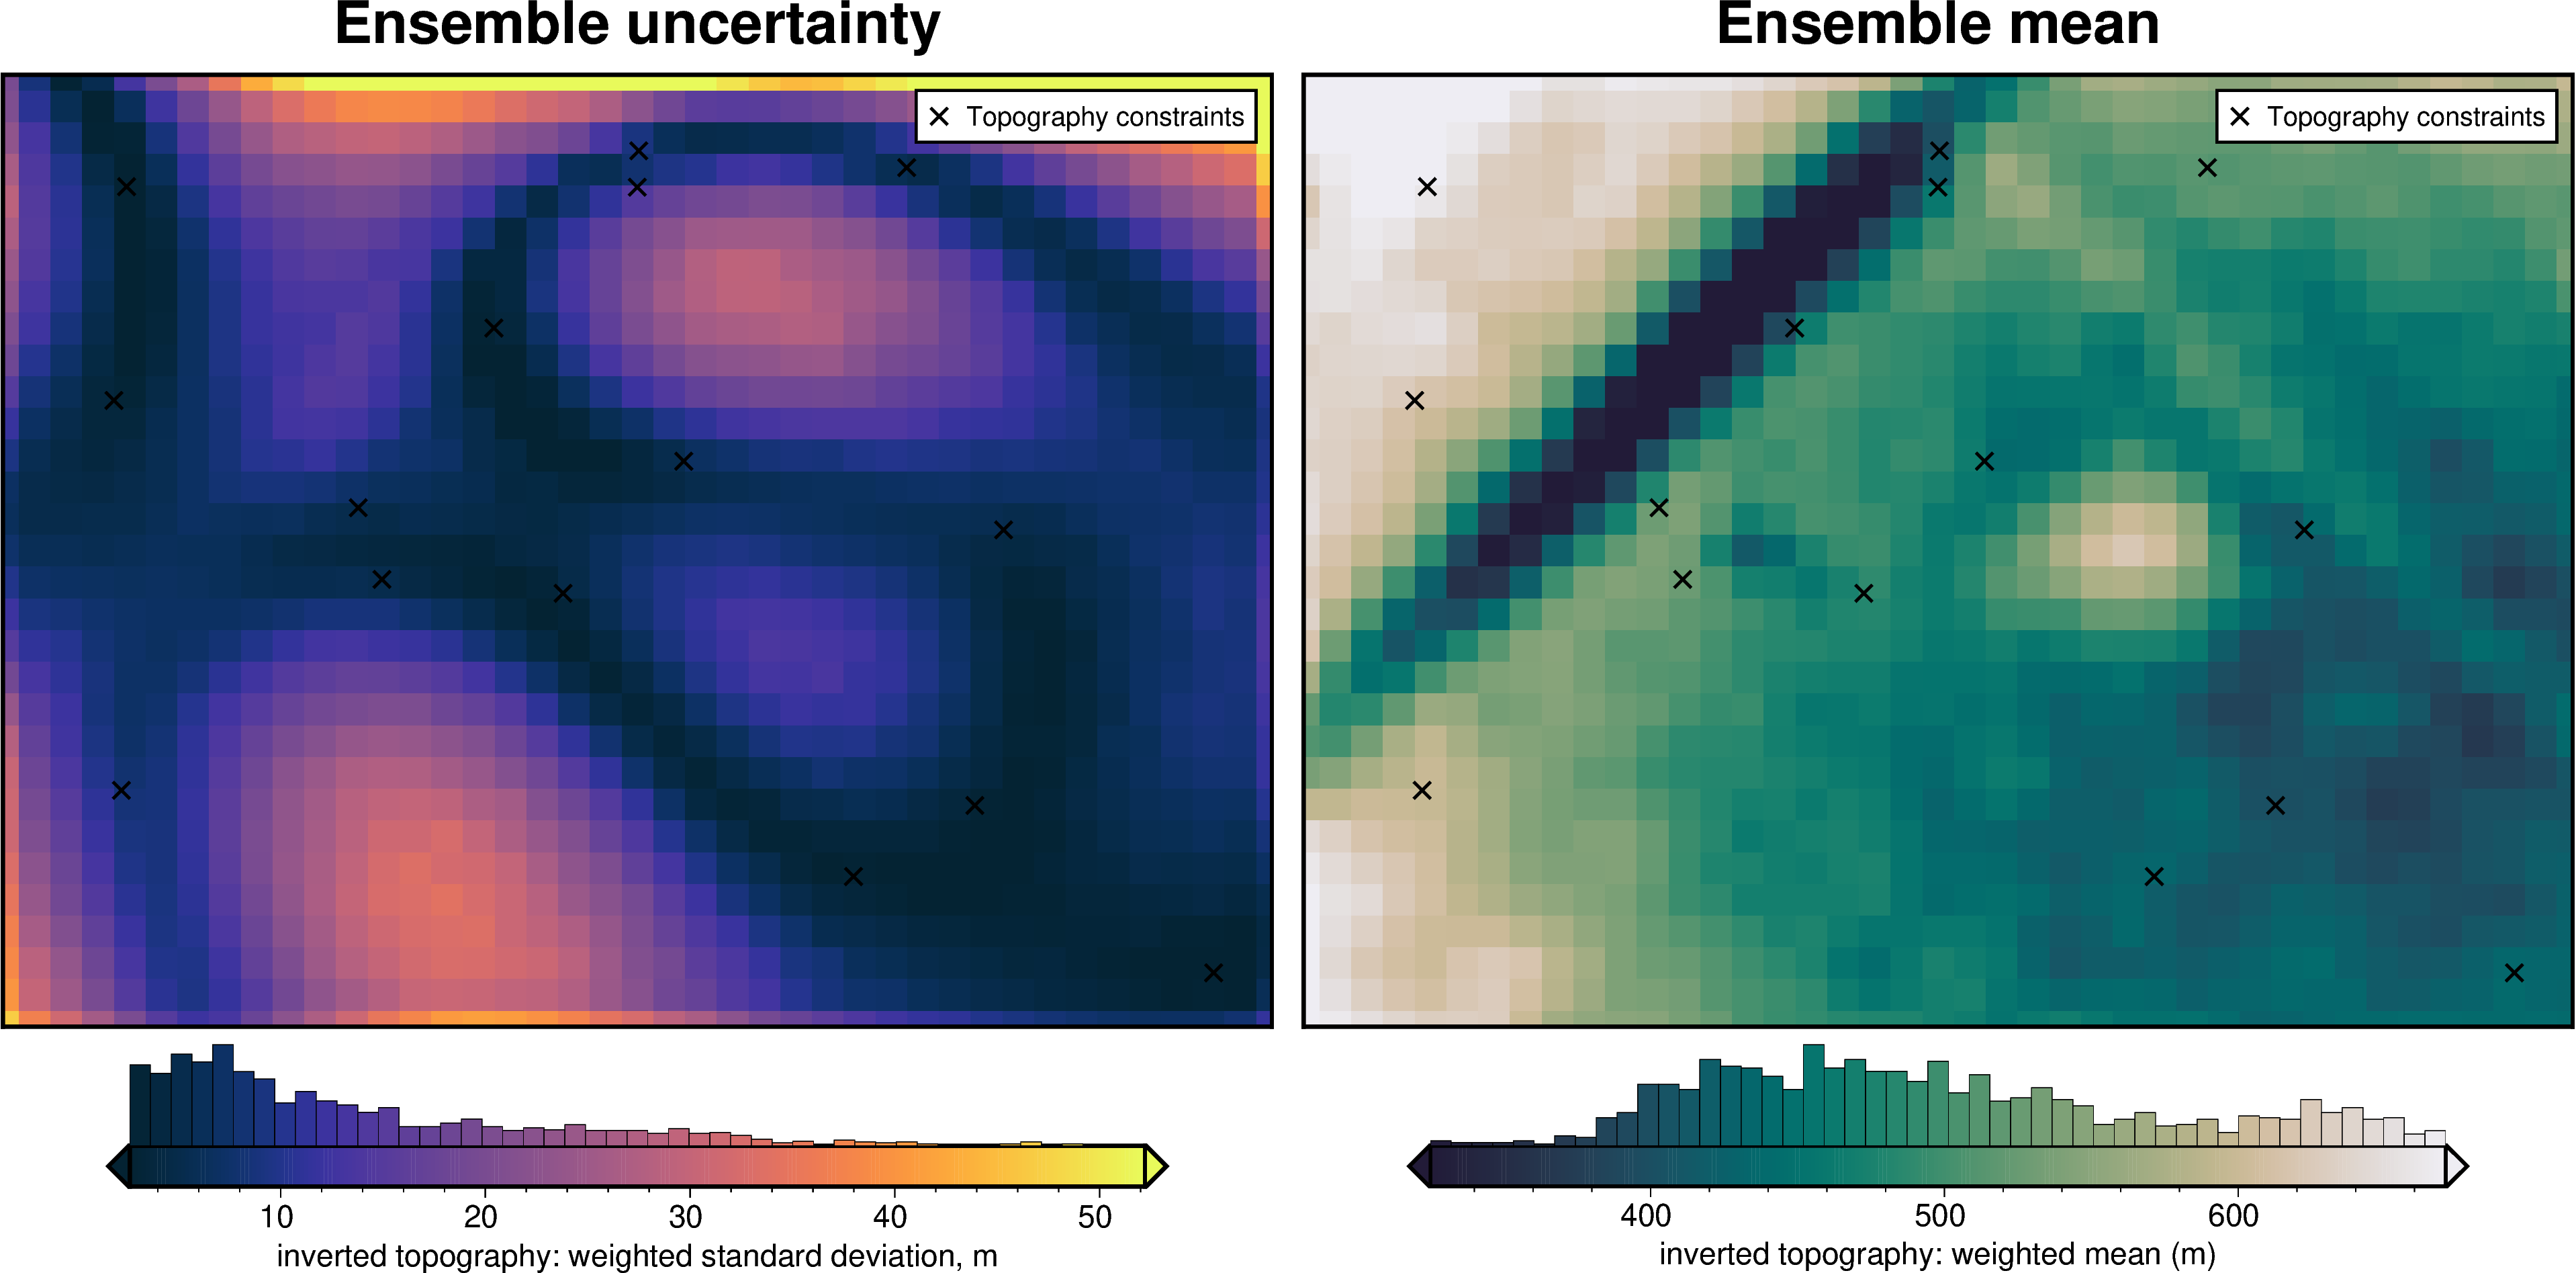

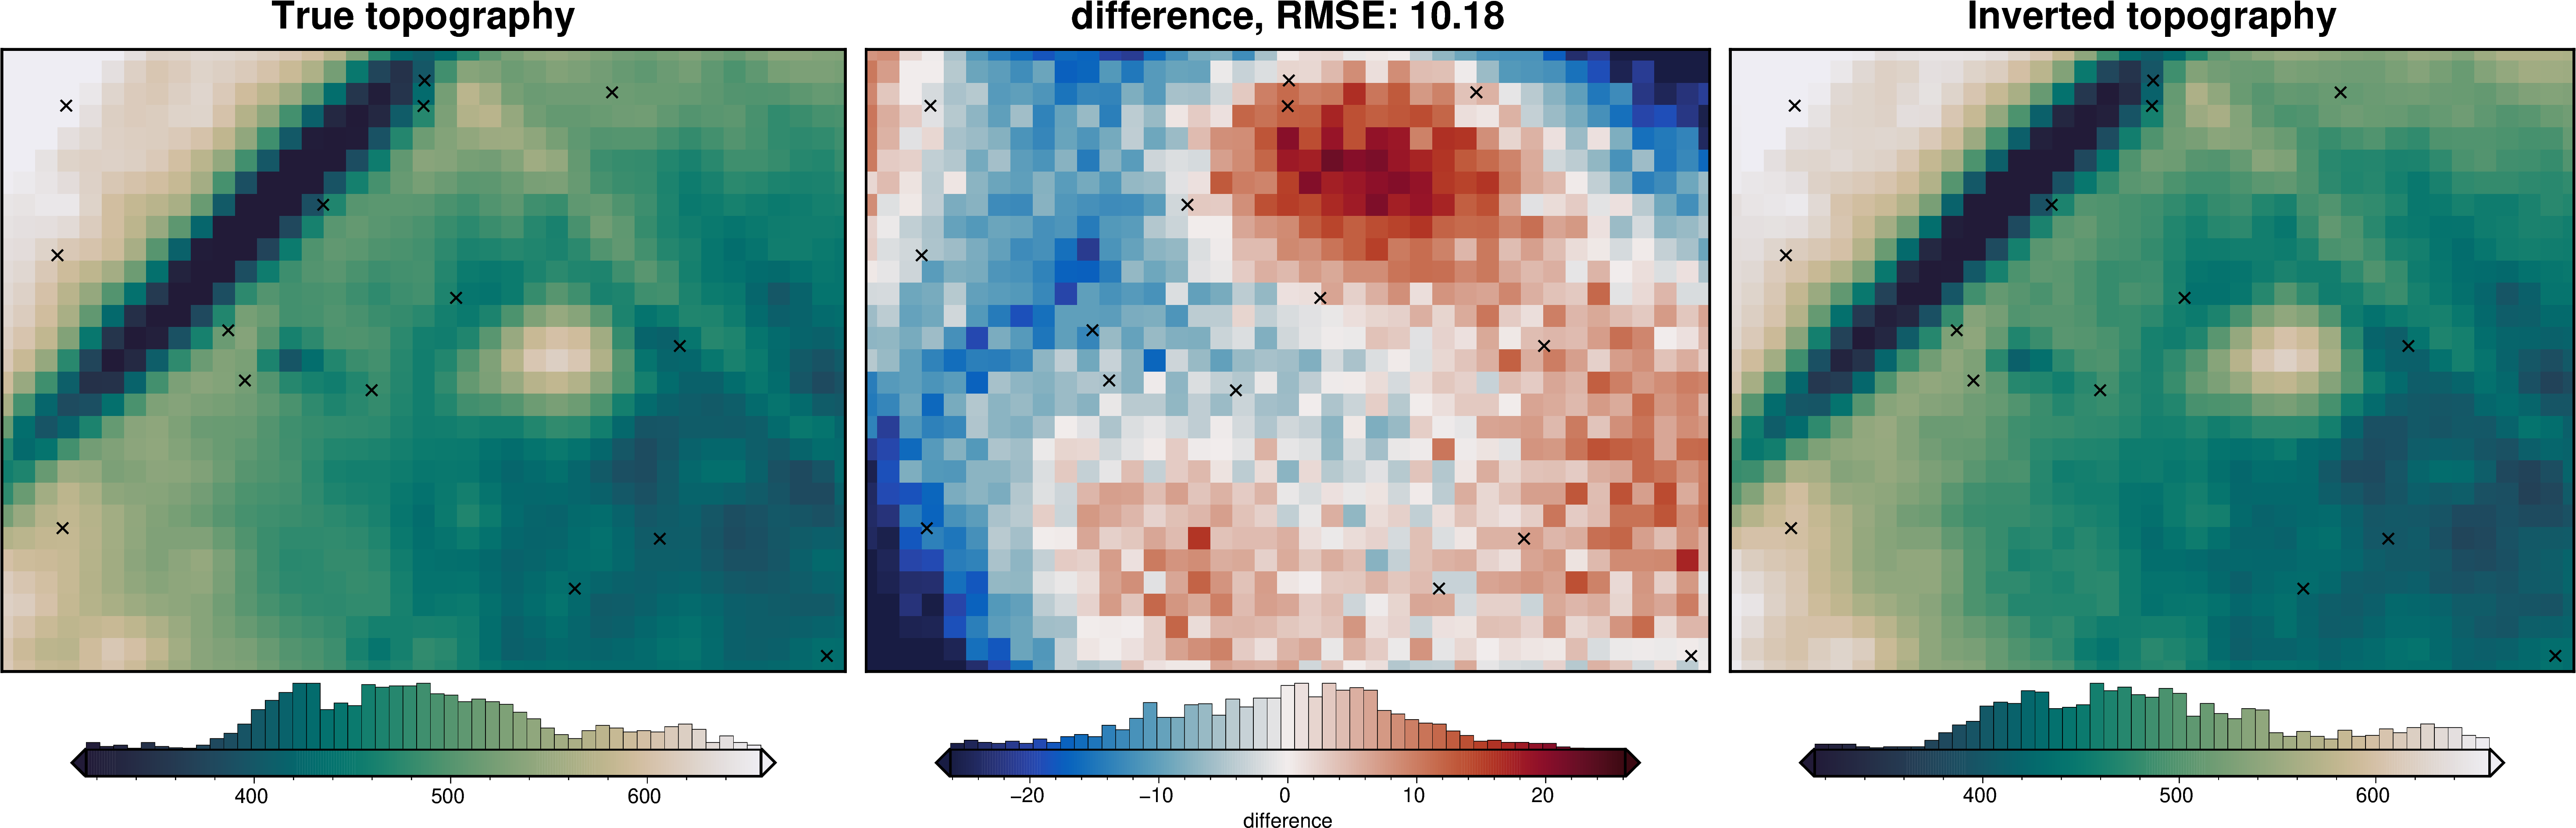

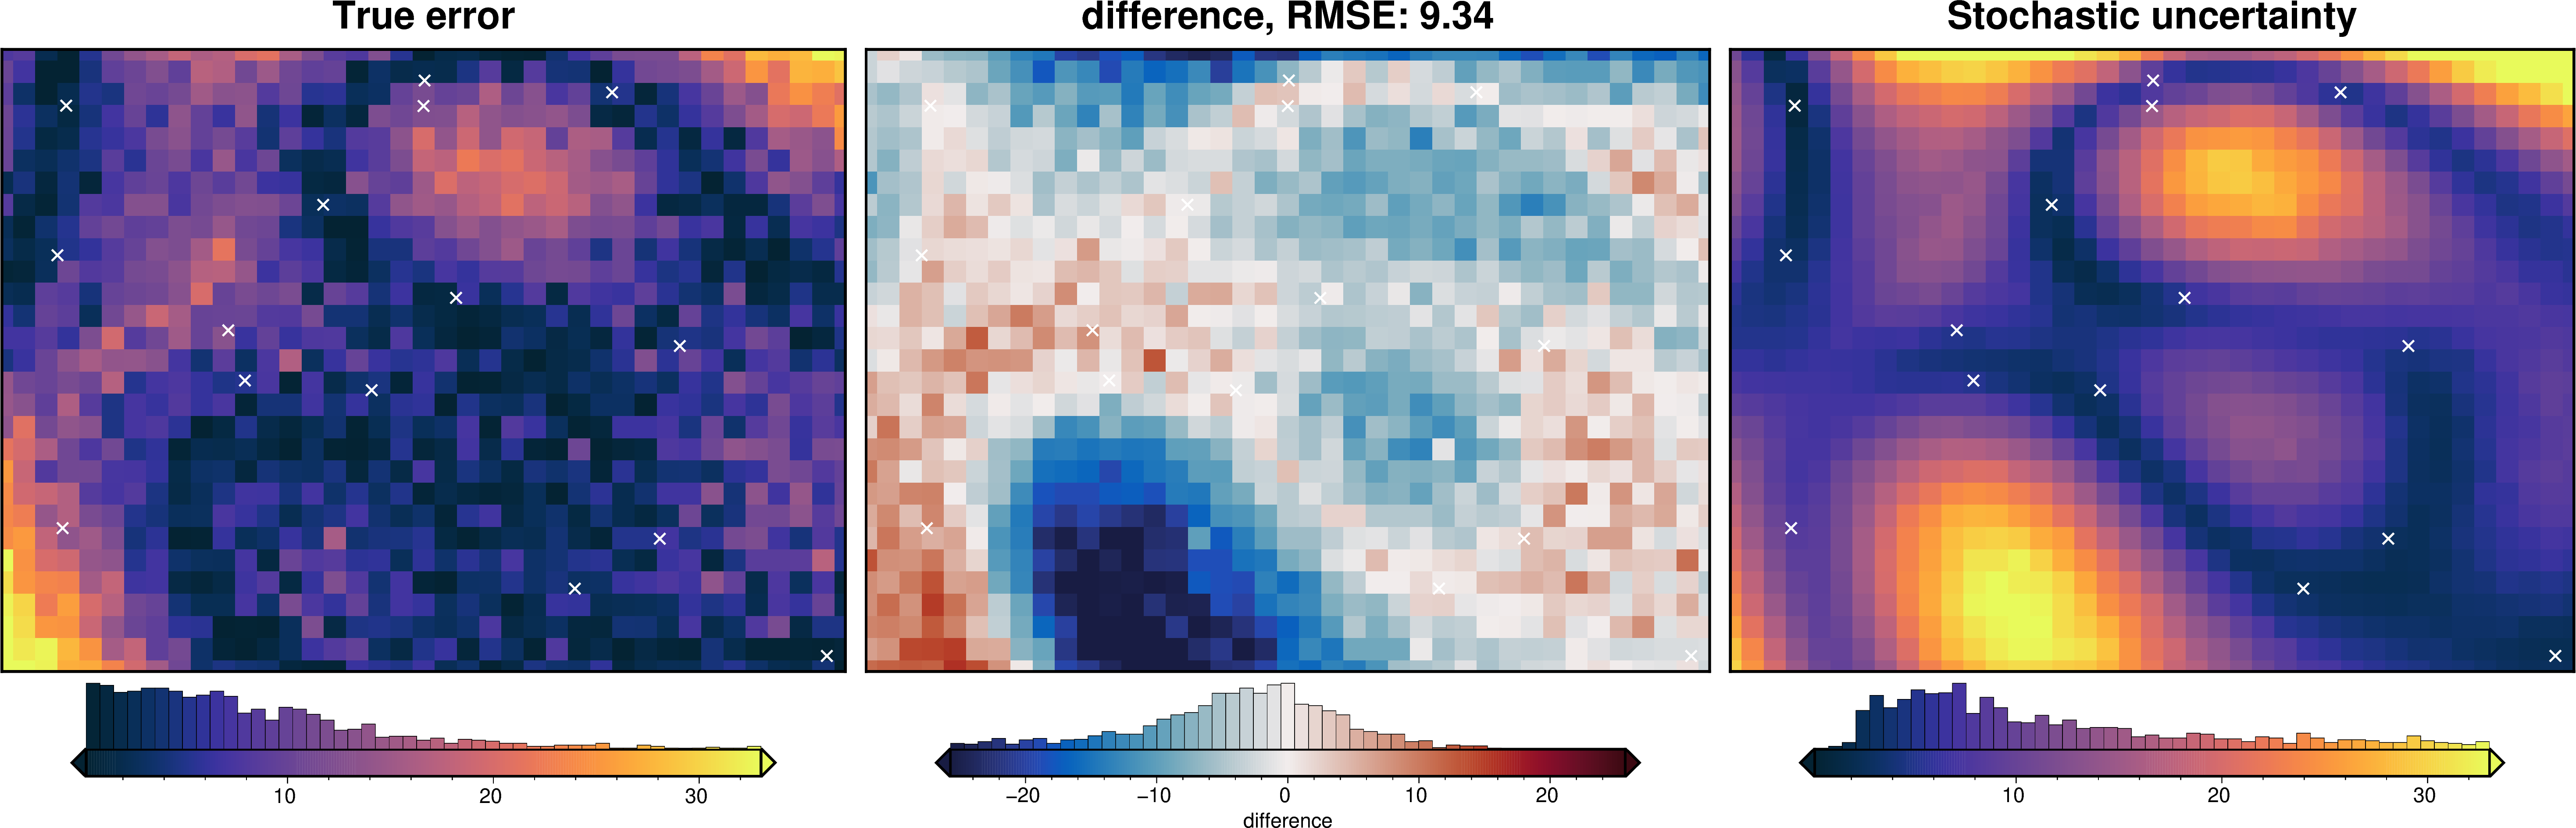

In [64]:
fname = "../tmp/uncertainty_regional"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_regional_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_regional_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Total uncertainty

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.06081861524880576, min: 0.0011354917999172778, max: 0.4416188324790071
INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2687.9999999999995, min: 2492.0036015459946, max: 2883.9963984540054
INFO:invert4geom:Sampled 'zref' parameter values; mean: 490.31137109098535, min: 392.31317186398263, max: 588.3095703179881
INFO:invert4geom:Sampled 'depth' parameter values; mean: 25196.20428990808, min: 20257.83899437473, max: 30134.569585441426
INFO:invert4geom:Sampled 'damping' parameter values; mean: 2663.235378151625, min: 1.1037053777656063e-11, max: 52791.62555468066
INFO:invert4geom:No pickle files starting with '../tmp/uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../tmp/uncertainty_full'



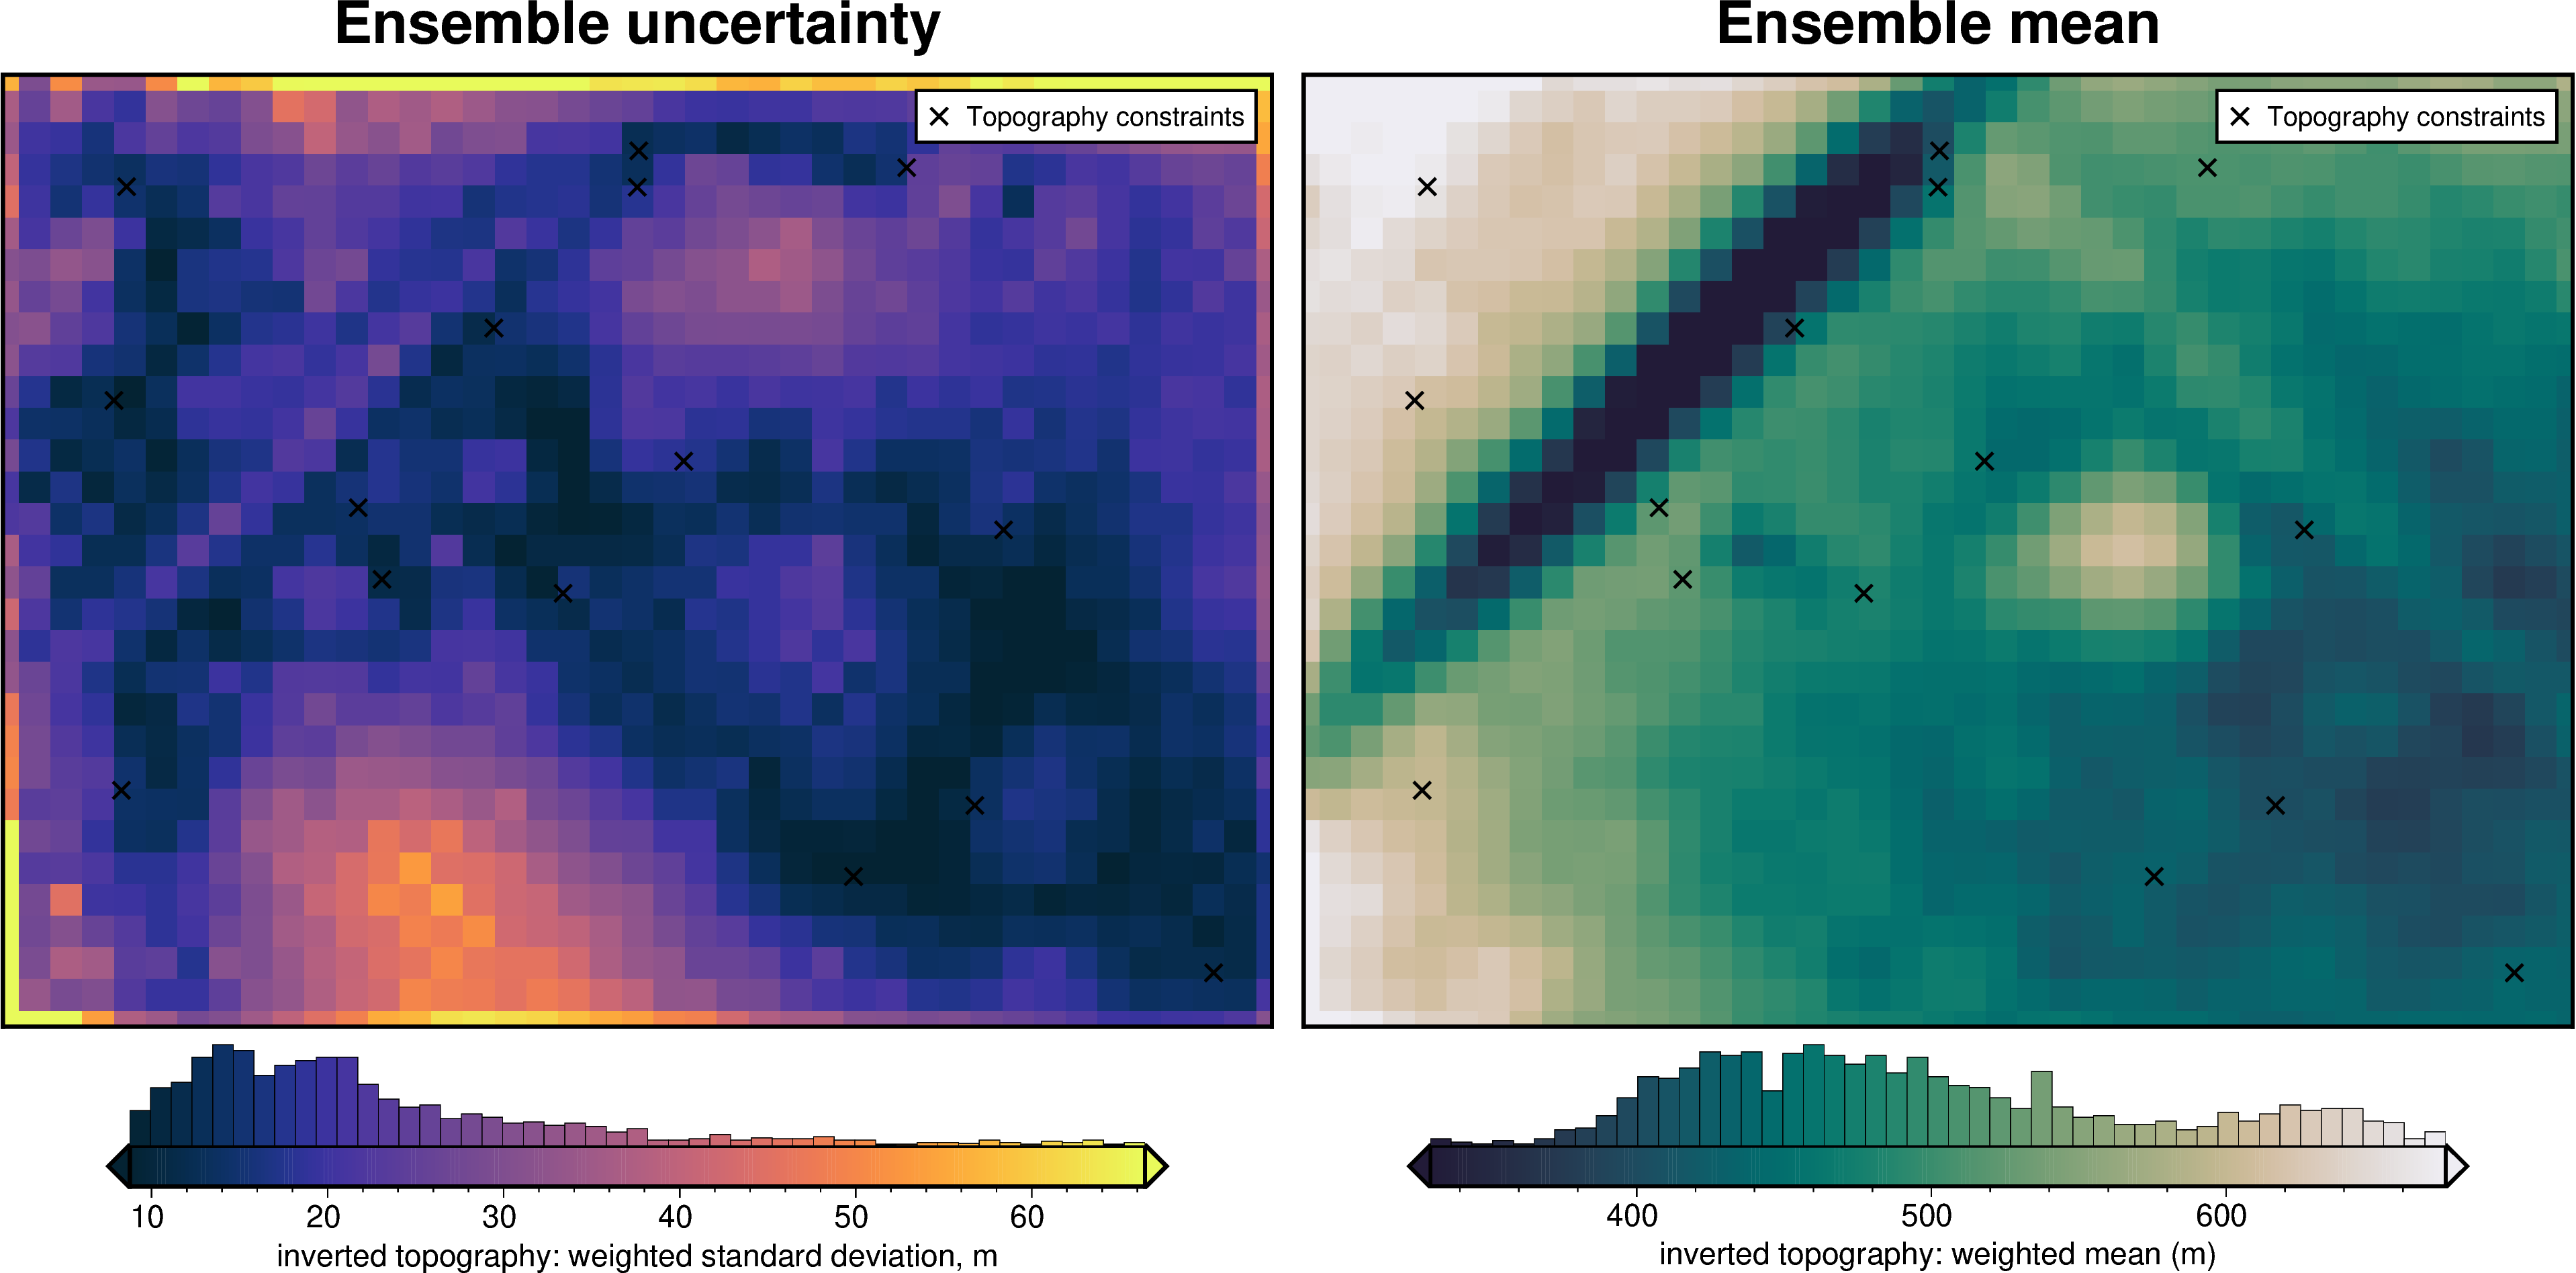

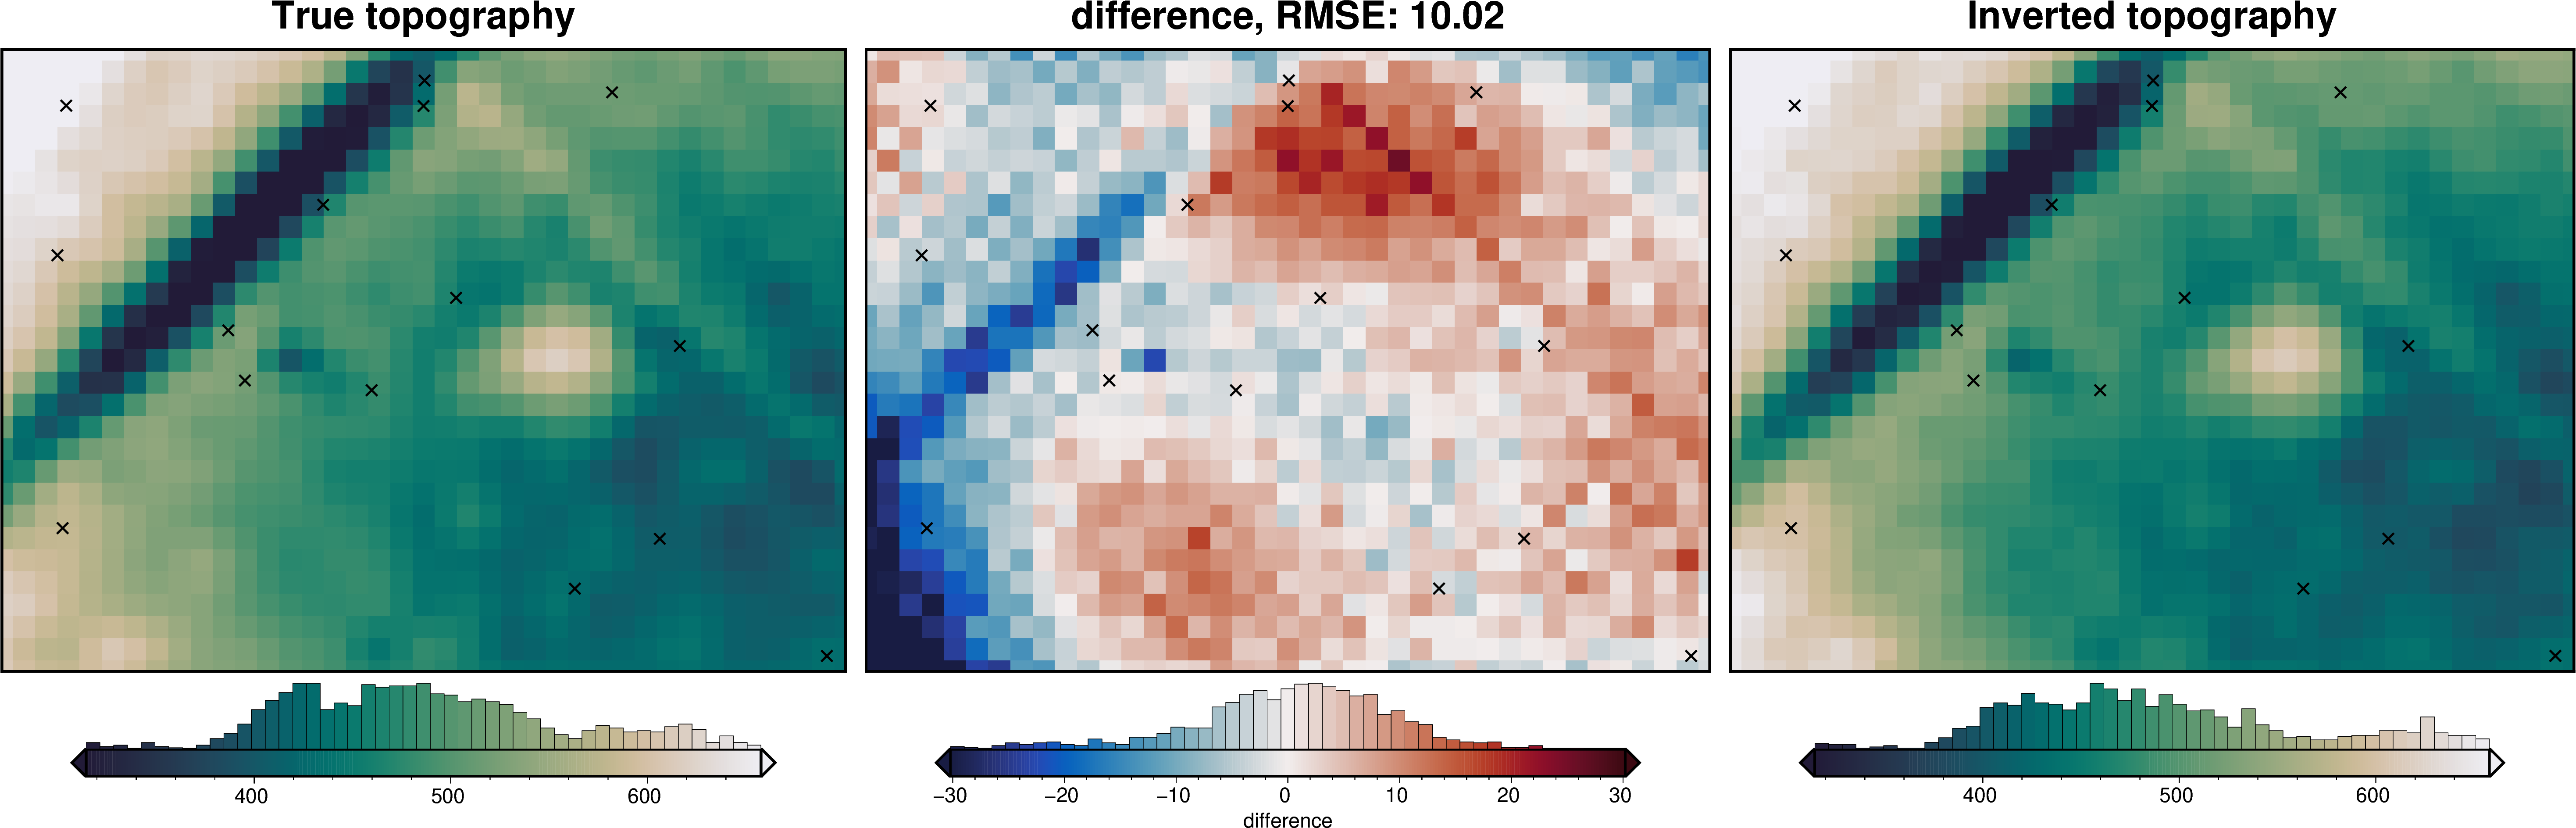

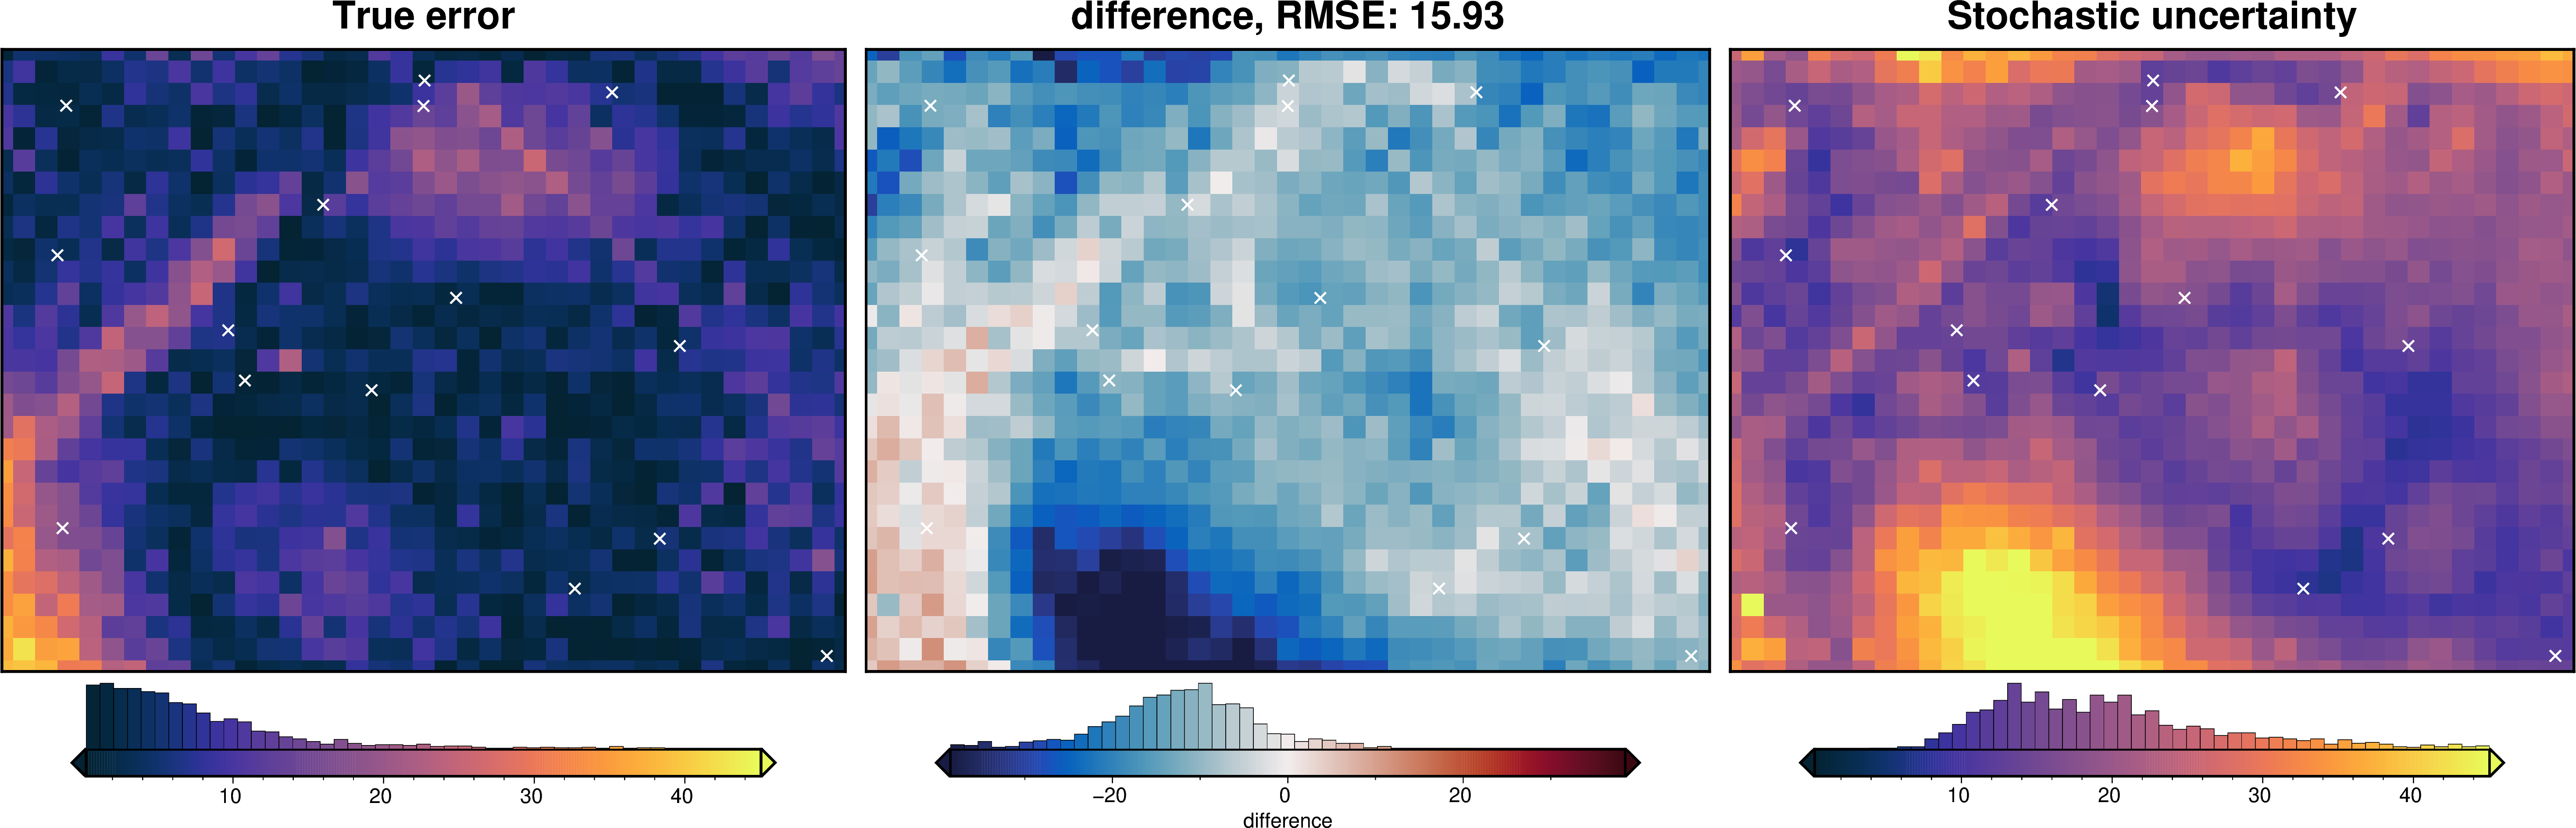

In [65]:
fname = "../tmp/uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    sample_gravity=True,
    sample_constraints=True,
    constraints_df=constraint_points,
    parameter_dict=solver_dict | density_dict | zref_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    starting_topography_kwargs=starting_topography_kwargs,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Comparing results

In [67]:
results = [
    uncert_results,
    uncert_regional_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_damping_results,
]
names = [
    "full",
    "regional",
    "grav",
    "constraints",
    "density",
    "damping",
]
# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
        # region=vd.pad_region(region, -spacing),
    )
    stats.append(ds)

In [68]:
# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 62kB
Dimensions:            (northing: 31, easting: 41)
Coordinates:
  * northing           (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting            (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    full_stdev         (northing, easting) float64 10kB 140.0 99.06 ... 121.7
    regional_stdev     (northing, easting) float64 10kB 46.8 37.08 ... 83.11
    grav_stdev         (northing, easting) float64 10kB 2.338 2.426 ... 1.884
    constraints_stdev  (northing, easting) float64 10kB 11.19 9.955 ... 42.22
    density_stdev      (northing, easting) float64 10kB 0.1206 0.7503 ... 2.179
    damping_stdev      (northing, easting) float64 10kB 1.088 4.336 ... 8.925

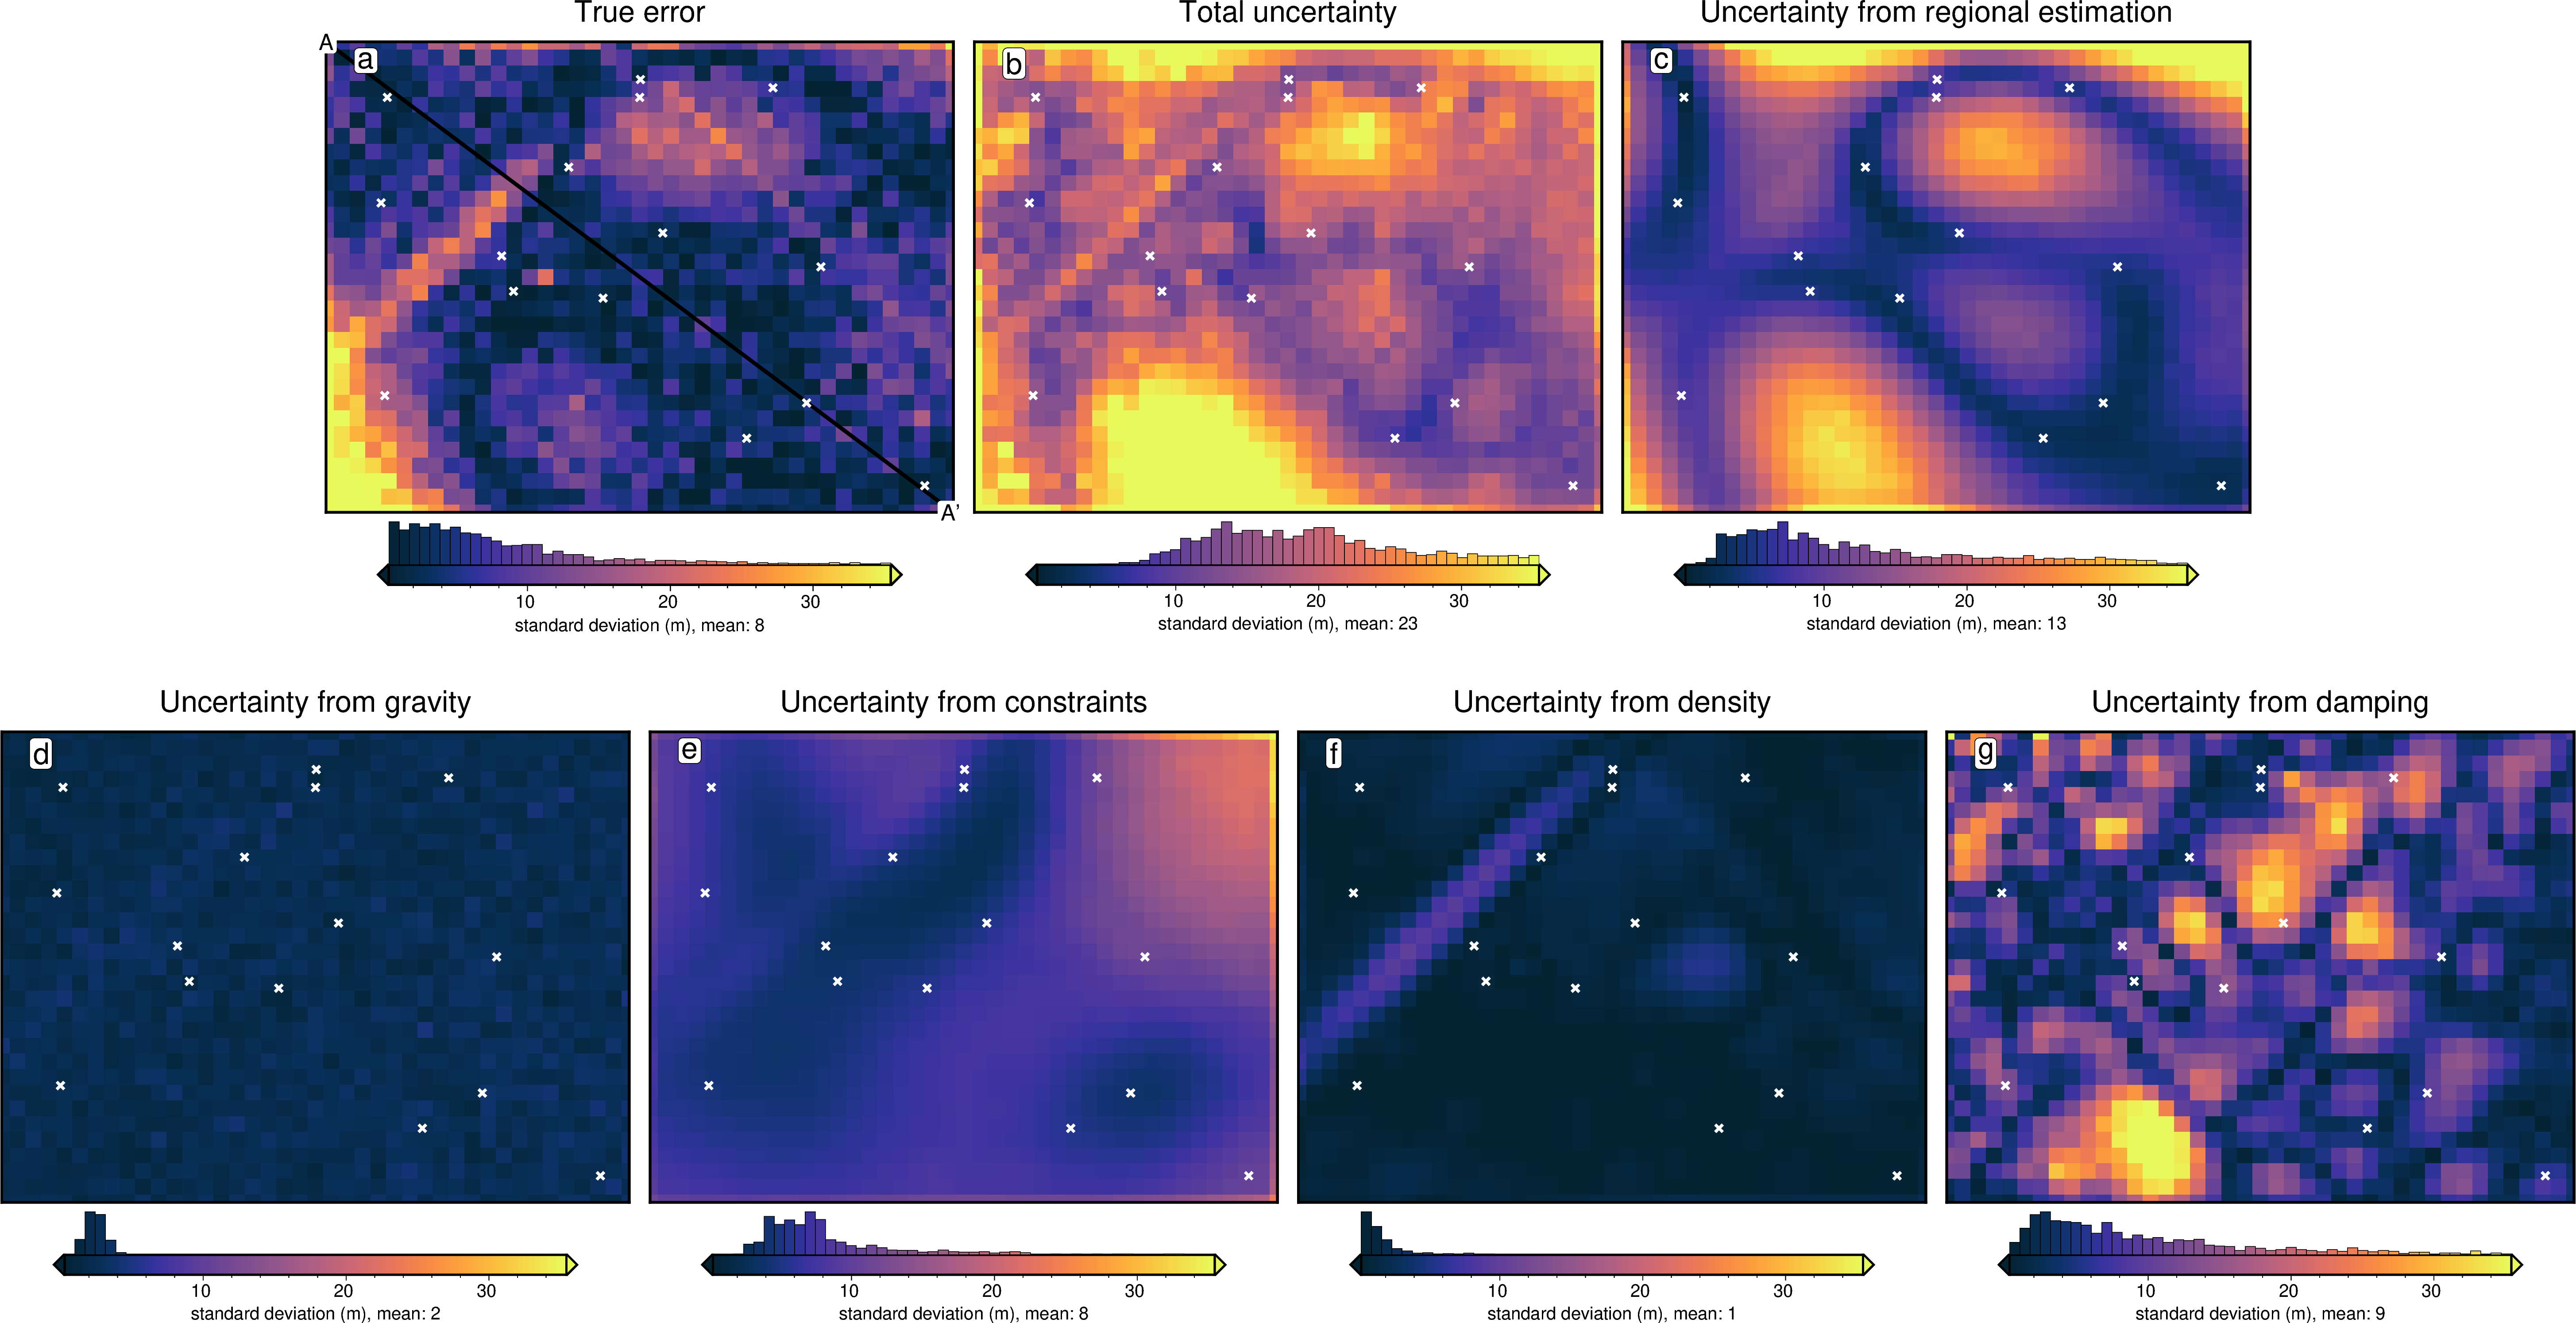

In [72]:
titles = [
    "True error",
    "Total uncertainty",
    "Uncertainty from regional estimation",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - true_topography))

cpt_lims = polar_utils.get_min_max(
    grids[0],
    robust=True,
)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 3:
        origin_shift = "both"
        xshift_amount = -2.5
    else:
        origin_shift = "x"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    if i == 0:
        # plot profile location, and endpoints on map
        start = [region[0], region[3]]
        stop = [region[1], region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="x.2c",
        pen="1.5p,white",
        fill="white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
fig.show()

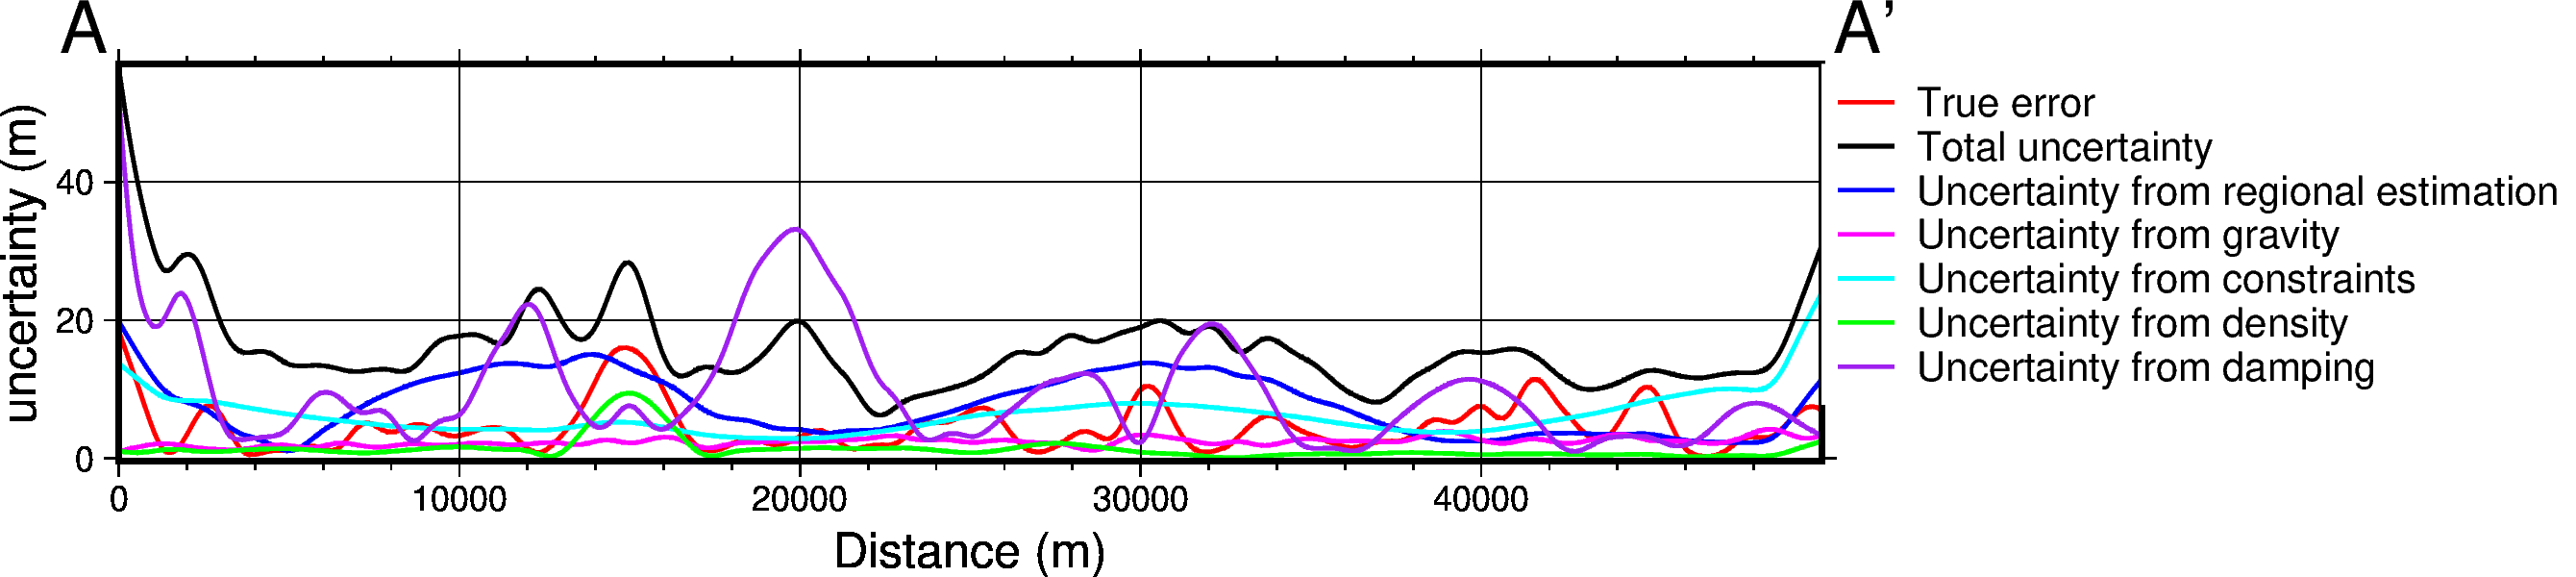

In [73]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[region[0], region[3]],
    stop=[region[1], region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()